In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

In [2]:
dataDirectory = "../Datasets/LFS_Composition.csv"
rawData = pd.read_csv(dataDirectory, header=0, nrows=None)

In [3]:
# splits the data into two distinct dataFrames: one with labour force percentage values and another with employment percentage values

dataWithEmploymentShares = rawData.copy()
dataWithLabourShares = rawData.copy()

for row in range(rawData.shape[0]):
    if "employment" in rawData.iloc[row]['Series']:
        dataWithLabourShares.drop(row, axis=0, inplace=True)
    else:
        dataWithEmploymentShares.drop(row, axis=0, inplace=True)

dataWithEmploymentShares.reset_index(inplace=True, drop=True)
dataWithLabourShares.reset_index(inplace=True, drop=True)

In [4]:
# puts the data in an easier to use format (each row contains a specific country's age group employment percentage values throughout time)

table = pd.pivot_table(dataWithEmploymentShares, index=['COUNTRY', 'AGE'], columns='TIME', values='Value')
table = table.reset_index().rename_axis(None, axis=1)

table.to_csv('../Datasets/lfsPivotted.csv', index=False)
pivottedDataDirectory = "../Datasets/lfsPivotted.csv"
pivottedData = pd.read_csv(pivottedDataDirectory, header=0, nrows=None)
os.remove('../Datasets/lfsPivotted.csv')

In [5]:
# removes rows with more NaNs than actual values

dataWithoutNans = pivottedData.copy()

for row in range(pivottedData.shape[0]):
    countNa = 0
    for column in range(2, pivottedData.shape[1]):
        if math.isnan(pivottedData.iloc[row][column]):
            countNa += 1

    if countNa >= math.floor(pivottedData.shape[1]/2):
        dataWithoutNans.drop(row, axis=0, inplace=True)

dataWithoutNans.reset_index(inplace=True, drop=True)

In [6]:
# detects which countries do not contain all the age groups up to 74 years of age

ageGroupCount = np.zeros(24)
ageGroups = ['1519', '1524', '2024', '2529', '2534', '2539', '3034', '3039', '3539', '3544', '4044', '4049', '4549', '4554', '5054', '5059', '5559', '5564', '6064', '6569', '6574', '7074', '7579', '8084']
countriesToBeRemoved = set()

for country in dataWithoutNans['COUNTRY'].unique():
    countryData = dataWithoutNans.loc[dataWithoutNans['COUNTRY'] == country]

    for ageGroup in range(countryData.shape[0]):
        currentAgeGroup = str(countryData.iloc[ageGroup][1])
        if currentAgeGroup in ageGroups:
            ageGroupCount[ageGroups.index(currentAgeGroup)] += 1

    if not int(6569) in countryData['AGE'].unique():
        #print("6569 missing country: " + country)
        countriesToBeRemoved.add(country)

    if not int(7074) in countryData['AGE'].unique():
        #print("7074 missing countries: " + country)
        countriesToBeRemoved.add(country)

"""for index, ageGroup in enumerate(ageGroups):
    print(ageGroup + " - " + str(ageGroupCount[index]))"""

'for index, ageGroup in enumerate(ageGroups):\n    print(ageGroup + " - " + str(ageGroupCount[index]))'

In [7]:
# drops countries that do not have 6569 and 7074 data as well as all the occurrences of 7579 data, instead of dropping 6569, 7074 and 7579 (due to not all the countries containing that data)

dataWithConsistentAgeGroups = dataWithoutNans.copy()

for country in countriesToBeRemoved:
    indicesToDrop = dataWithoutNans[dataWithoutNans.COUNTRY == country].index
    dataWithConsistentAgeGroups.drop(indicesToDrop, inplace=True)

indicesToDrop = dataWithoutNans[dataWithoutNans.AGE == 7579].index
dataWithConsistentAgeGroups.drop(indicesToDrop, inplace=True)

dataWithConsistentAgeGroups.reset_index(inplace=True, drop=True)

ageGroupCount = np.zeros(24)

for country in dataWithConsistentAgeGroups['COUNTRY'].unique():
    countryData = dataWithConsistentAgeGroups.loc[dataWithConsistentAgeGroups['COUNTRY'] == country]

    for ageGroup in range(countryData.shape[0]):
        currentAgeGroup = str(countryData.iloc[ageGroup][1])
        if currentAgeGroup in ageGroups:
            ageGroupCount[ageGroups.index(currentAgeGroup)] += 1

"""for index, ageGroup in enumerate(ageGroups):
    print(ageGroup + " - " + str(ageGroupCount[index]))"""

'for index, ageGroup in enumerate(ageGroups):\n    print(ageGroup + " - " + str(ageGroupCount[index]))'

In [8]:
# inferes remaining NaNs from the nearest (past or future) rate of change

dataWithInferences = dataWithConsistentAgeGroups.copy()

#print(dataWithInferences.iloc[47])

for row in range(dataWithConsistentAgeGroups.shape[0]):
    foundFirstValidEntry = False
    tracebackColumns = []
    for column in range(2, dataWithConsistentAgeGroups.shape[1]):
        if math.isnan(dataWithConsistentAgeGroups.iloc[row][column]):
            if not foundFirstValidEntry:
                tracebackColumns.append(column)
            else:
                previousValue = dataWithInferences.iloc[row, column-1]
                previousPreviousValue = dataWithInferences.iloc[row, column-2]
                previousGrowthRate = (previousValue - previousPreviousValue)/(previousPreviousValue)
                dataWithInferences.iloc[row, column] = previousValue * (1 + previousGrowthRate)
        else:
            if not foundFirstValidEntry:
                foundFirstValidEntry = True
                currentValue = dataWithConsistentAgeGroups.iloc[row][column]
                nextValue = dataWithConsistentAgeGroups.iloc[row, column+1]
                tracebackColumns.reverse()

                if math.isnan(nextValue):
                    for tracebackColumn in tracebackColumns:
                        dataWithInferences.iloc[row, tracebackColumn] = currentValue
                else:
                    subsequentGrowthRate = (currentValue - nextValue)/(nextValue)
                    for index, tracebackColumn in enumerate(tracebackColumns):
                        dataWithInferences.iloc[row, tracebackColumn] = dataWithInferences.iloc[row, tracebackColumn+1] * (1 + subsequentGrowthRate)

#print(dataWithInferences.iloc[47])

/var/folders/jv/flhd9_611gvdf13cfv1w9t640000gn/T/ipykernel_6375/63821784.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleanedData = cleanedData.append(df, ignore_index=True)


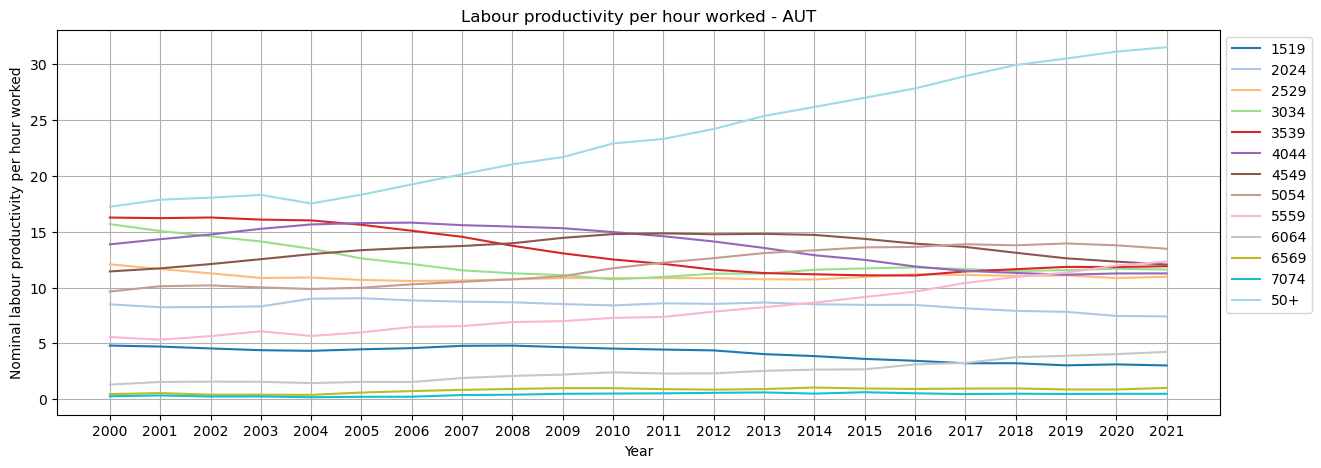

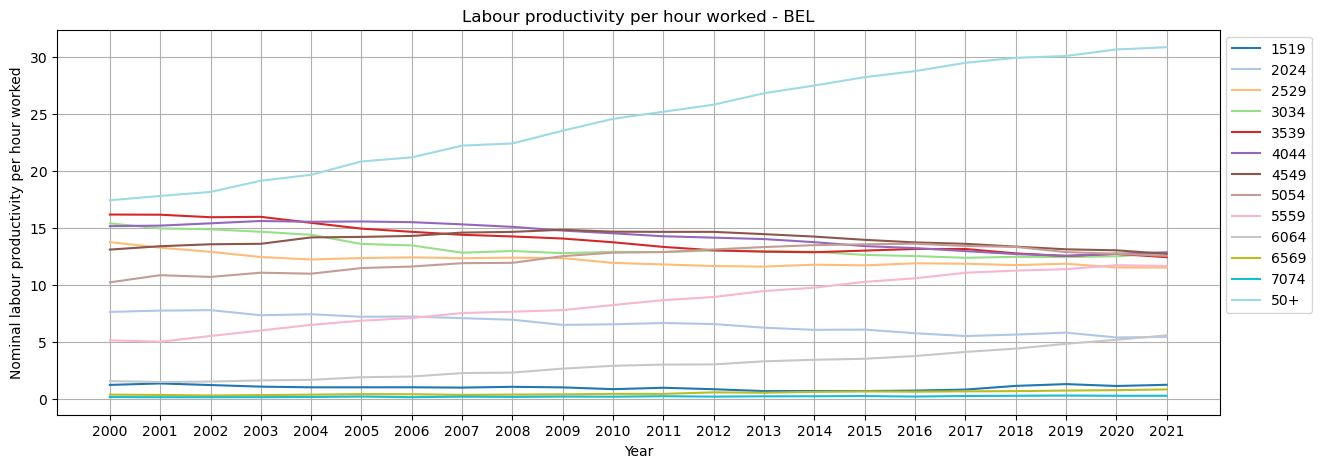

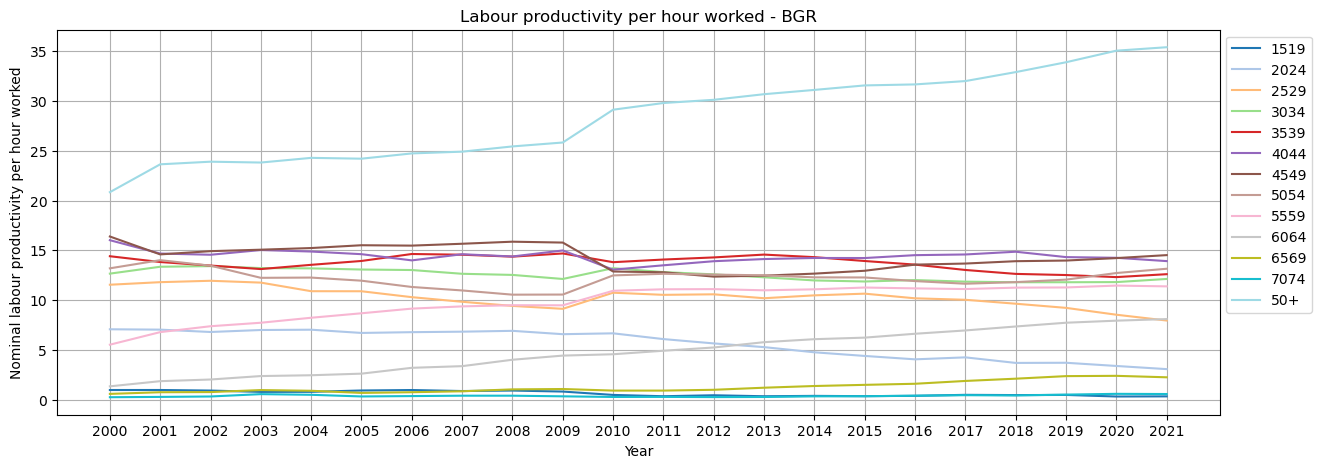

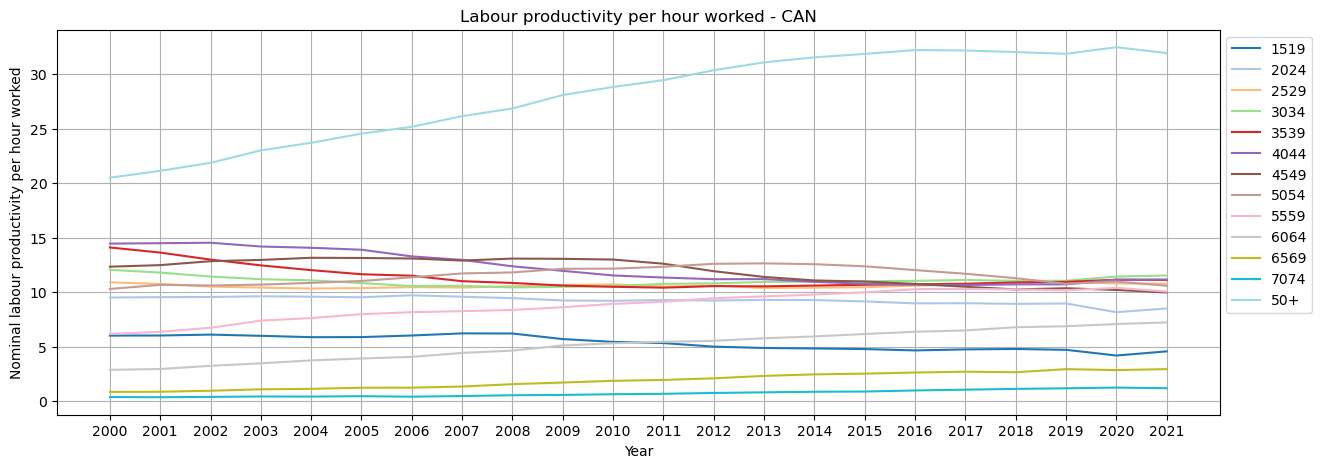

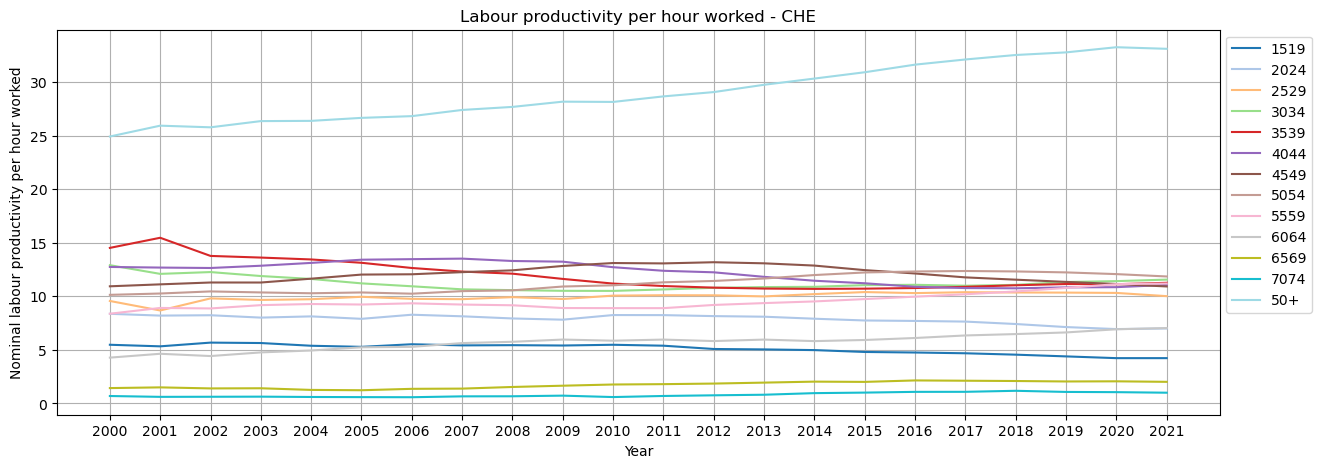

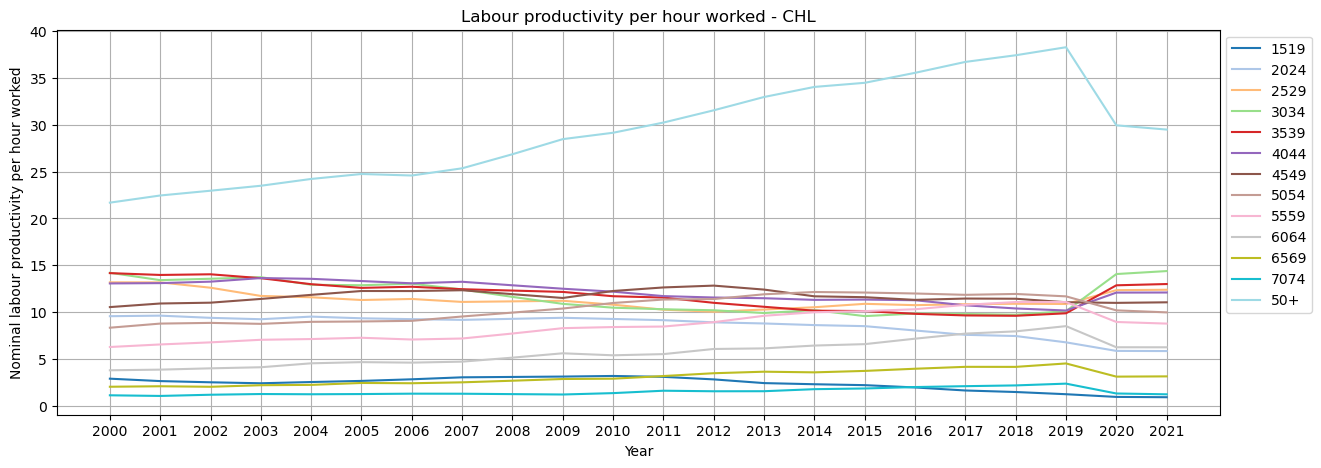

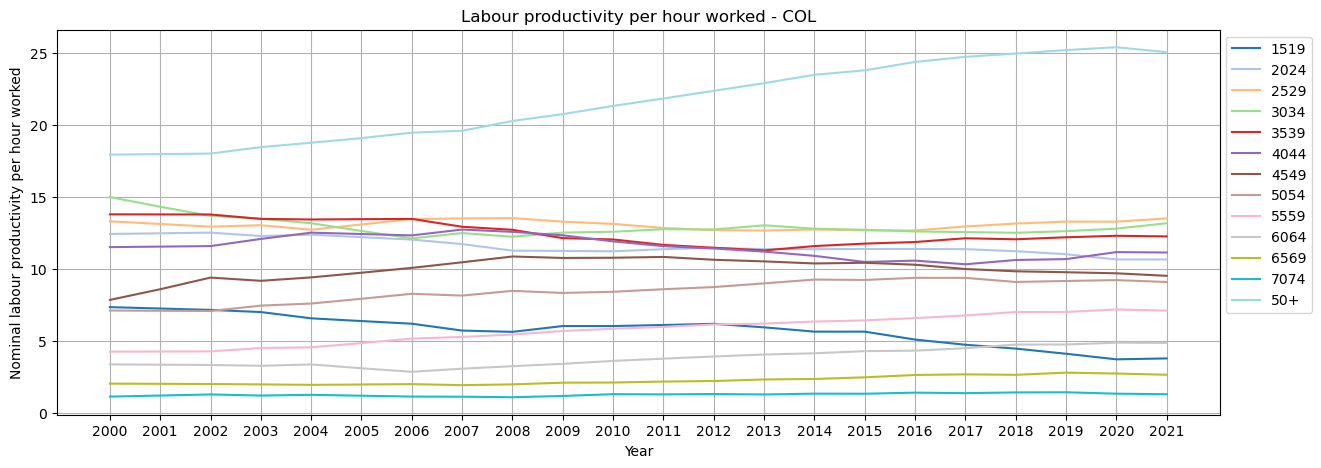

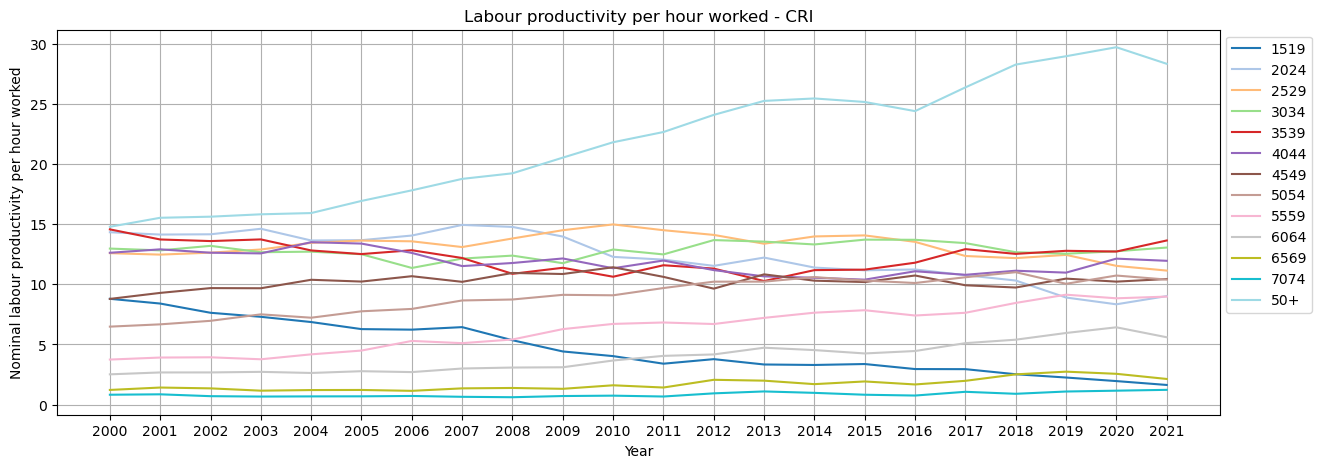

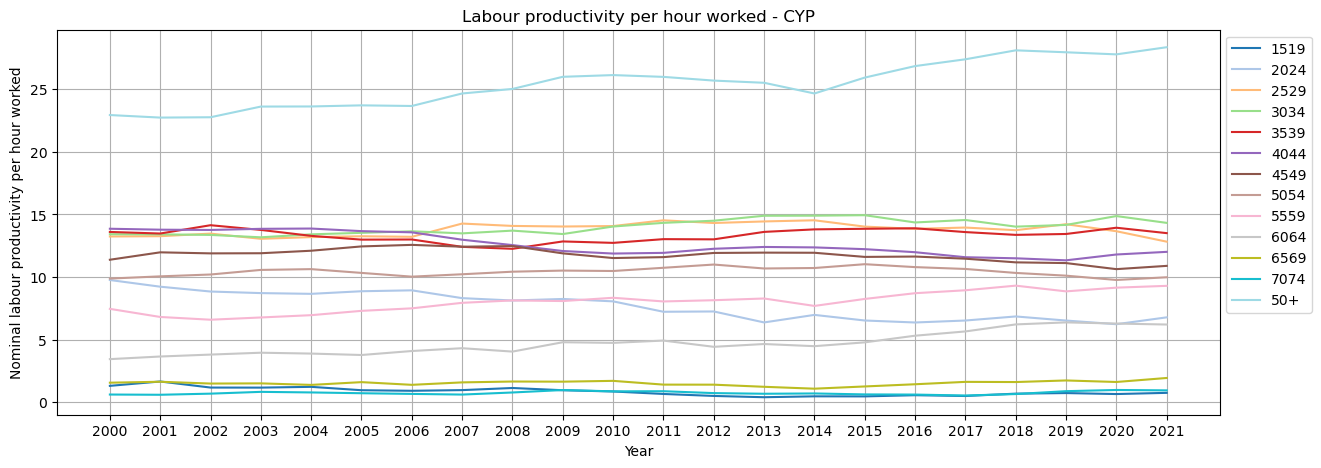

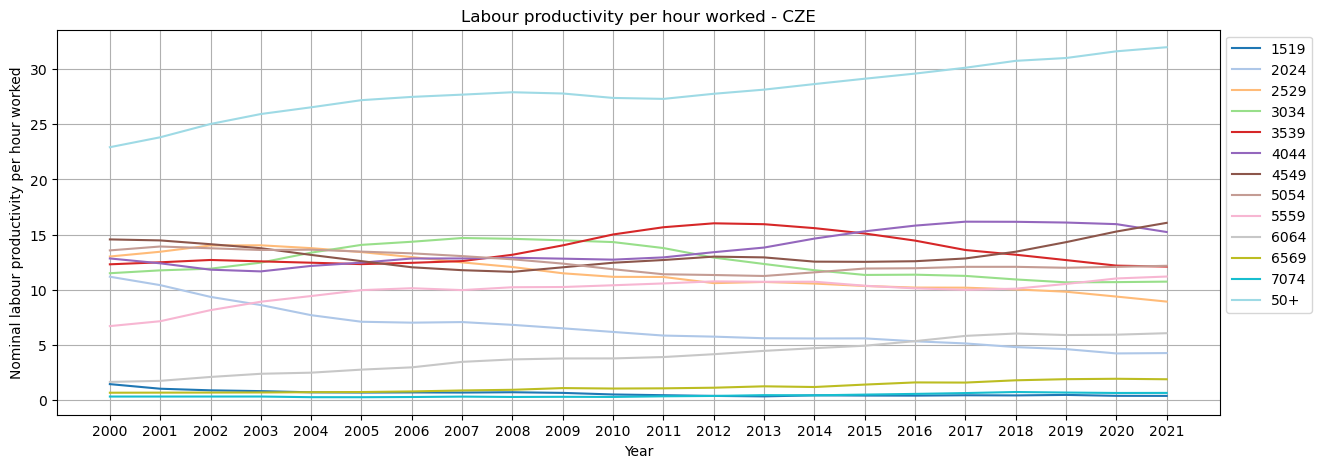

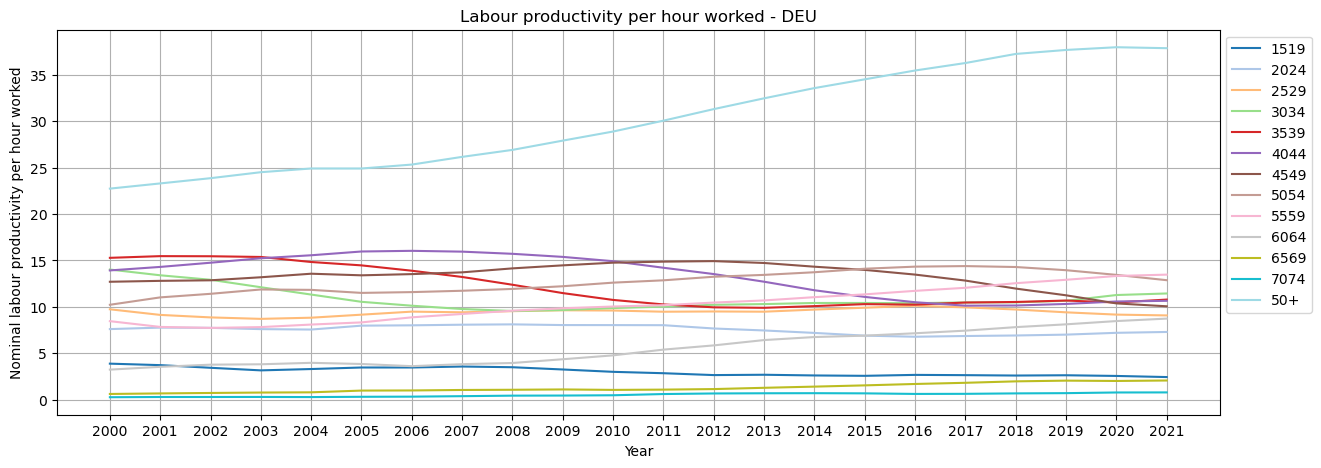

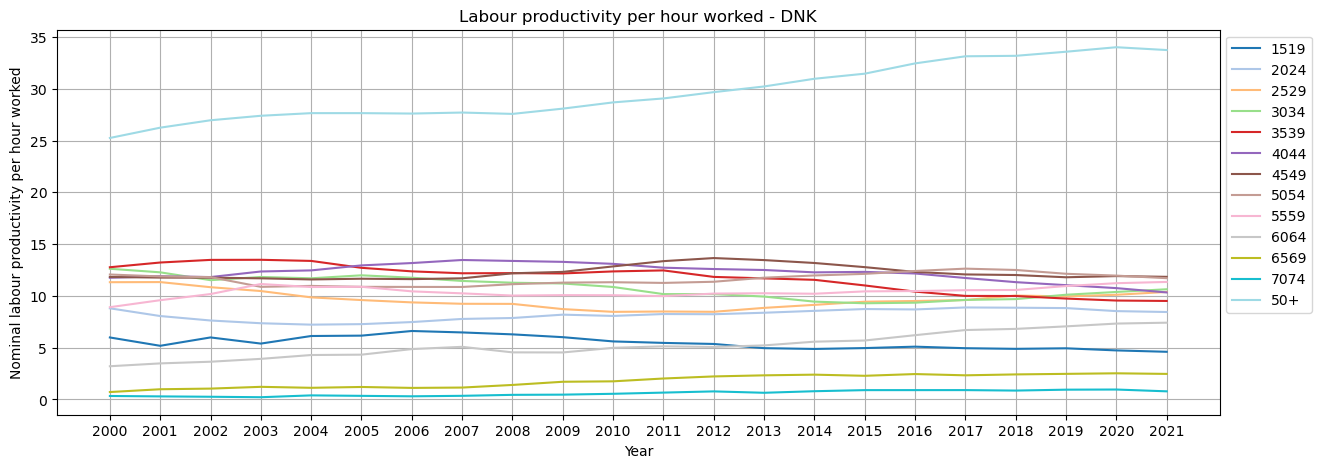

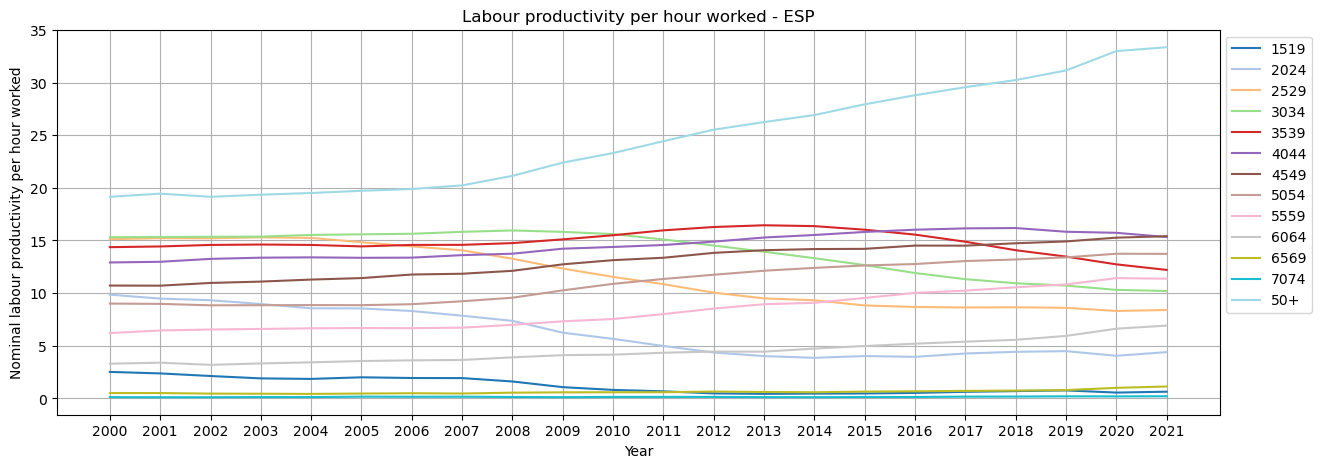

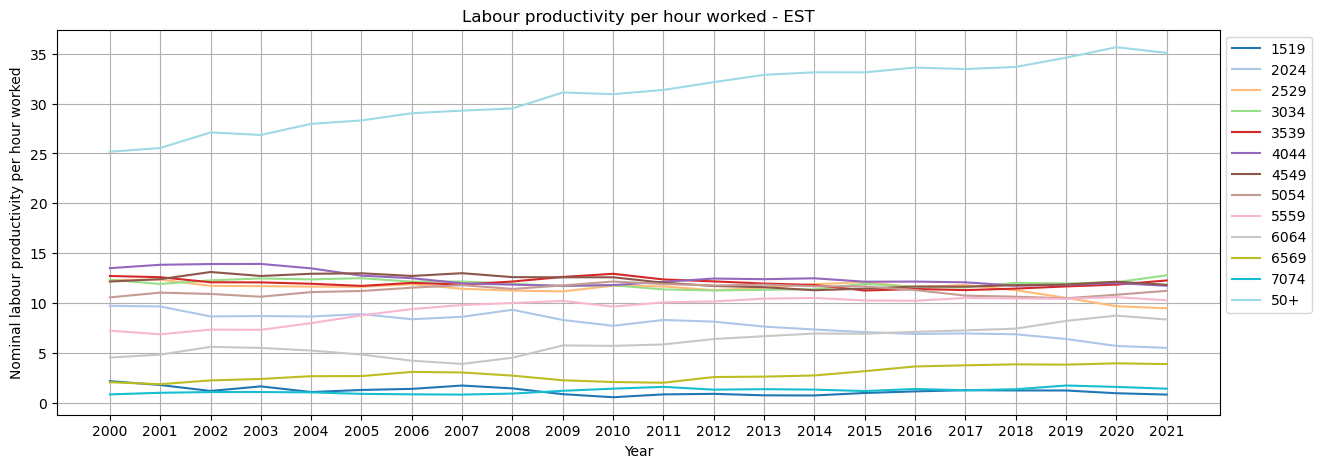

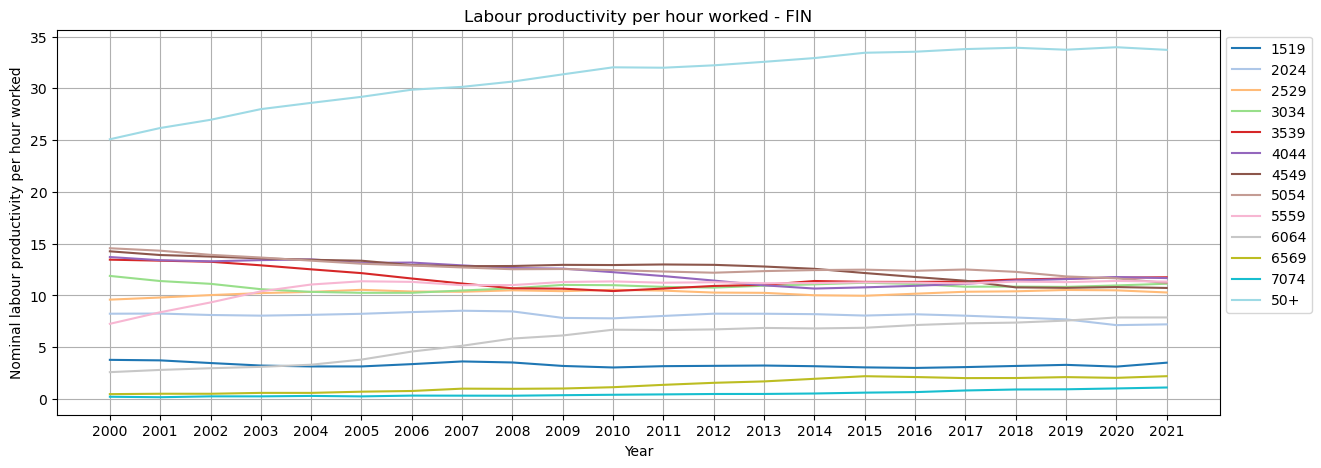

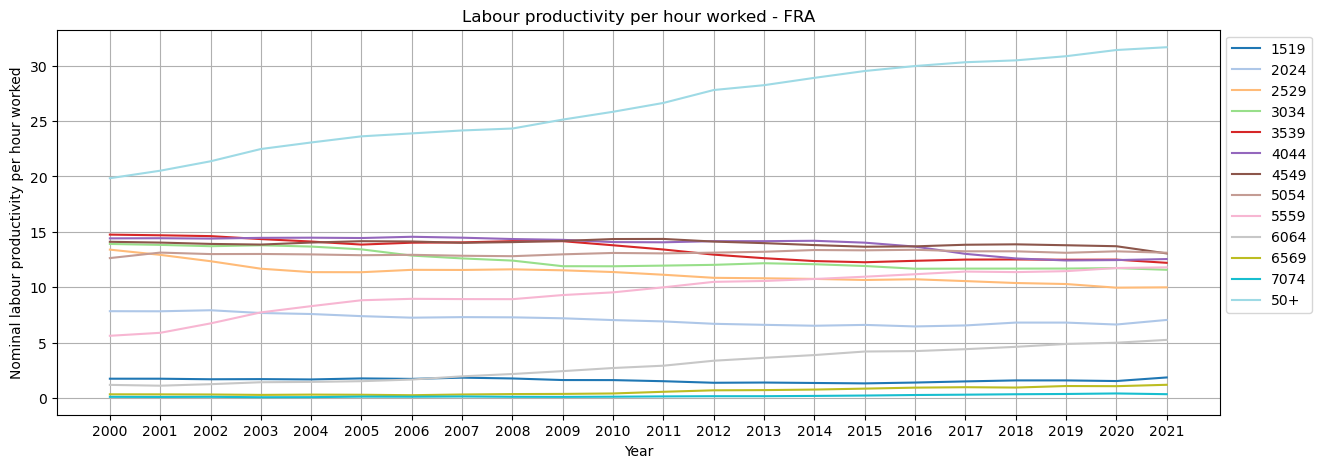

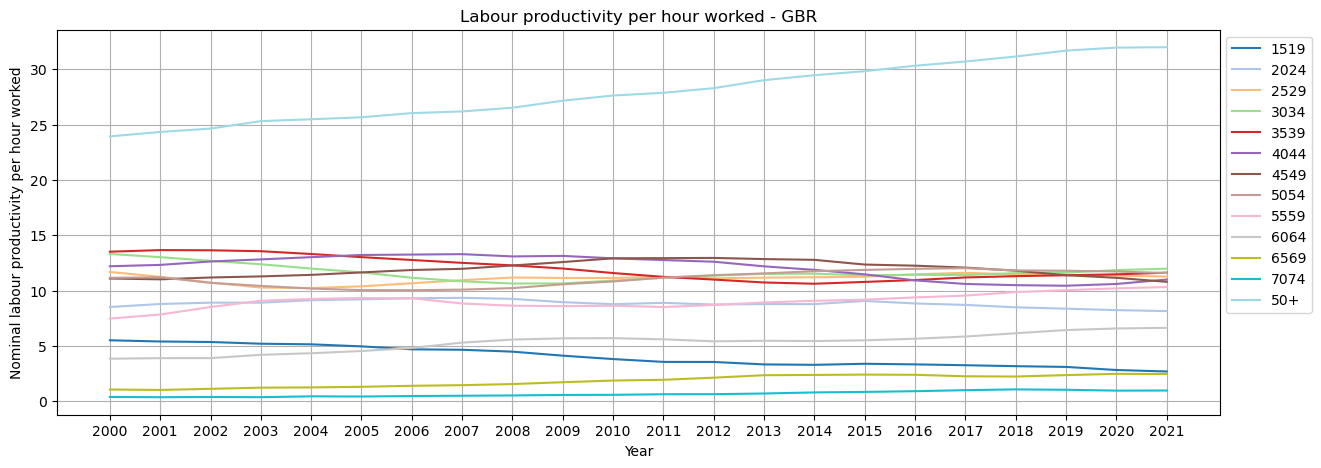

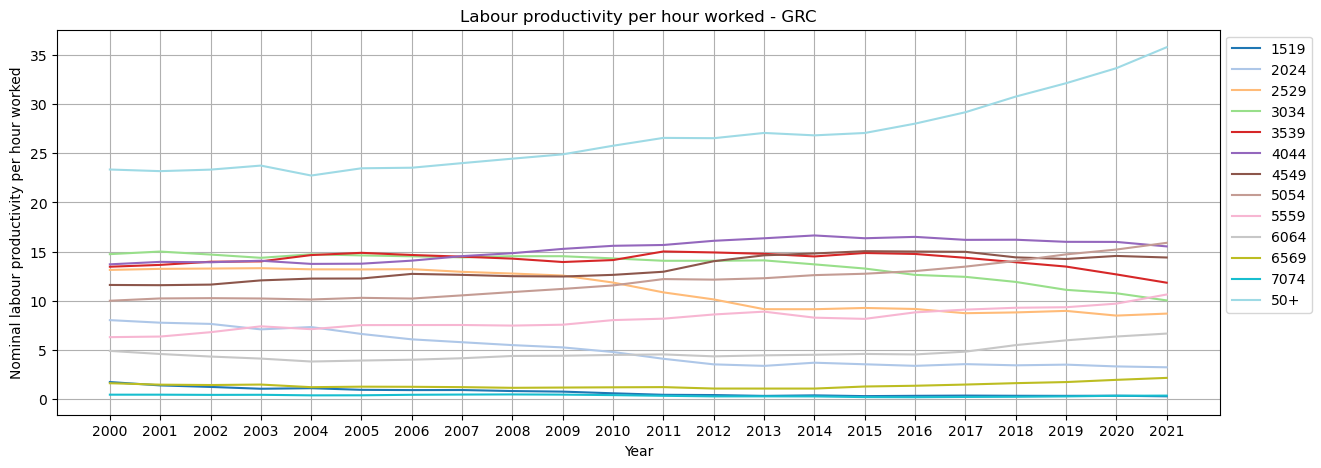

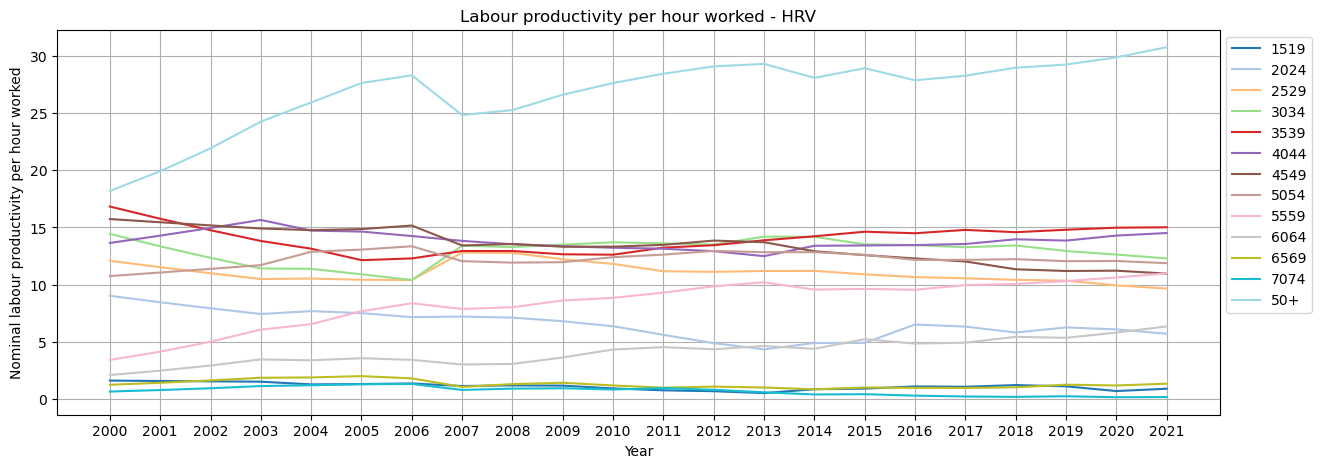

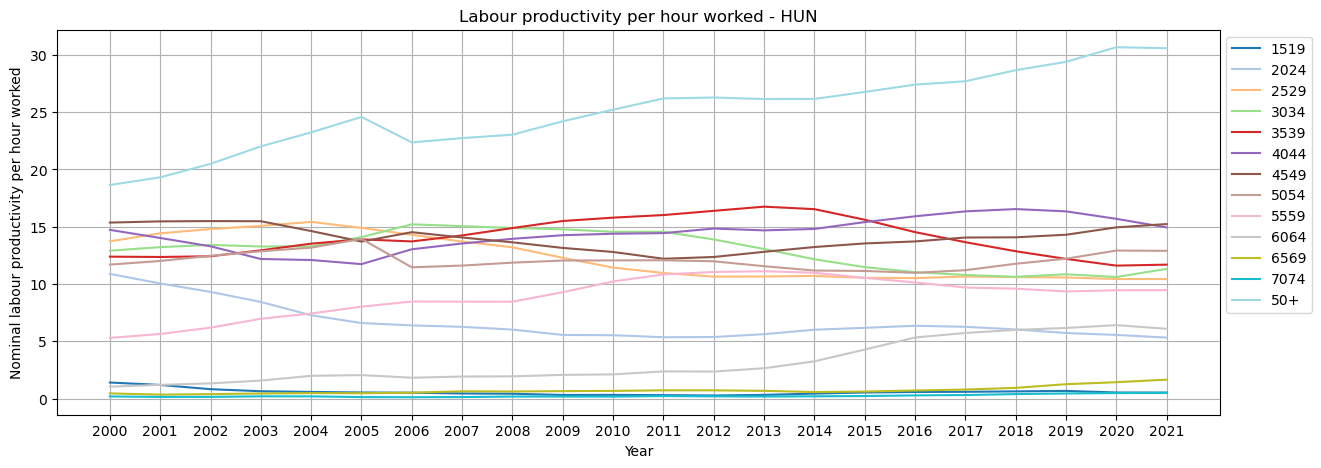

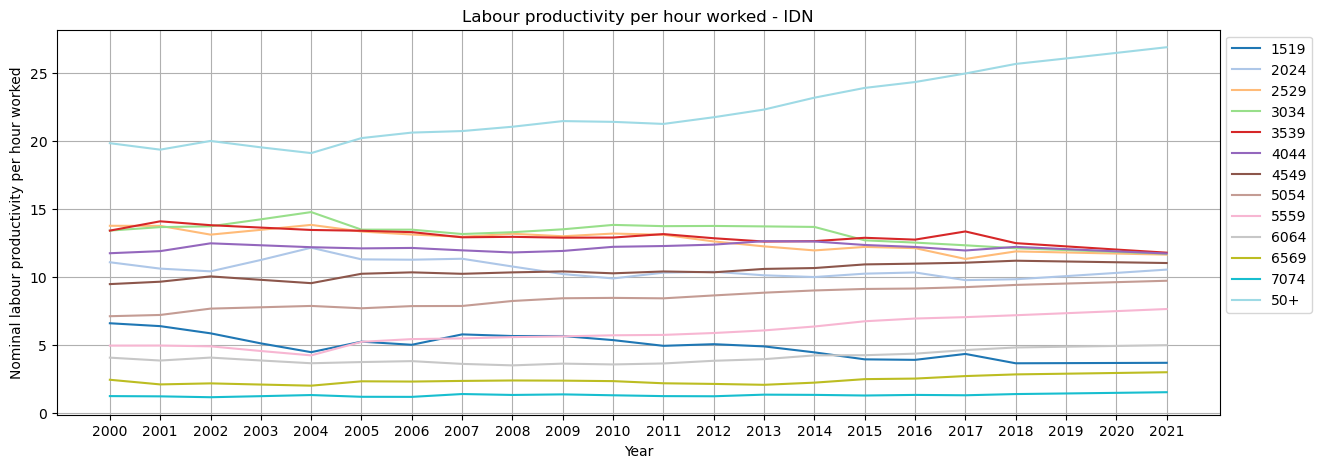

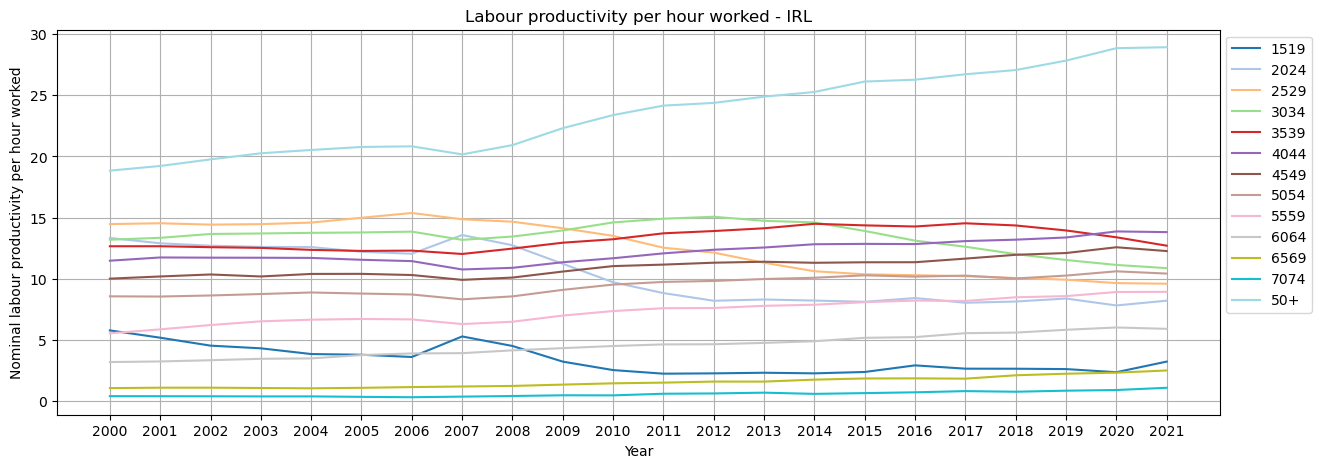

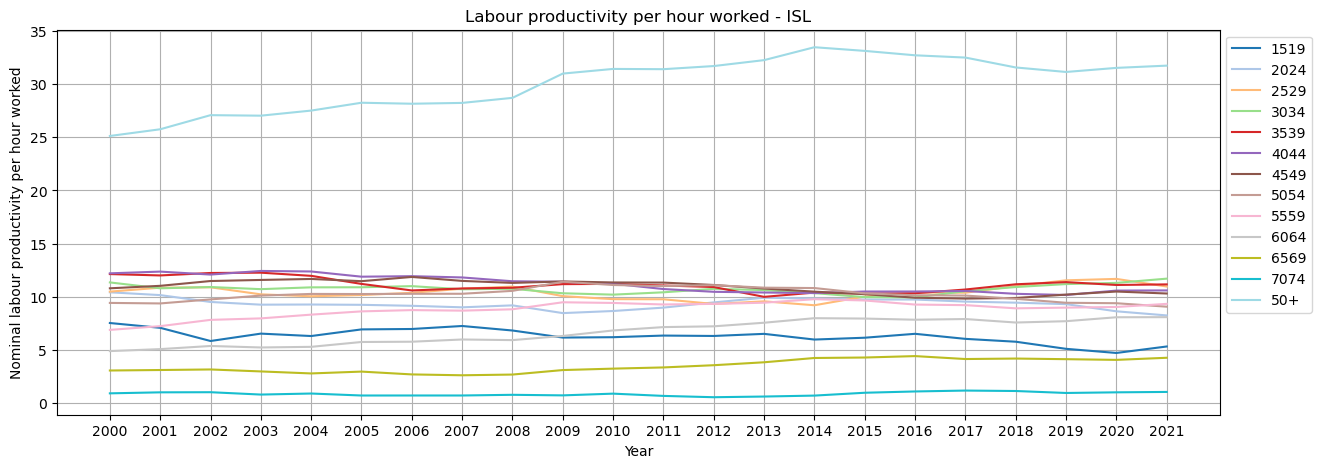

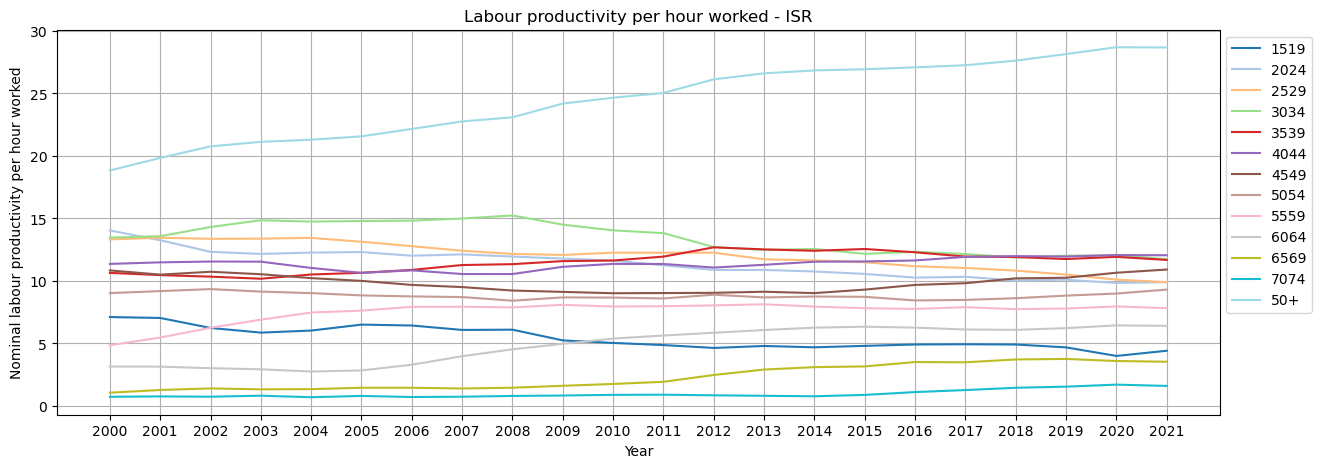

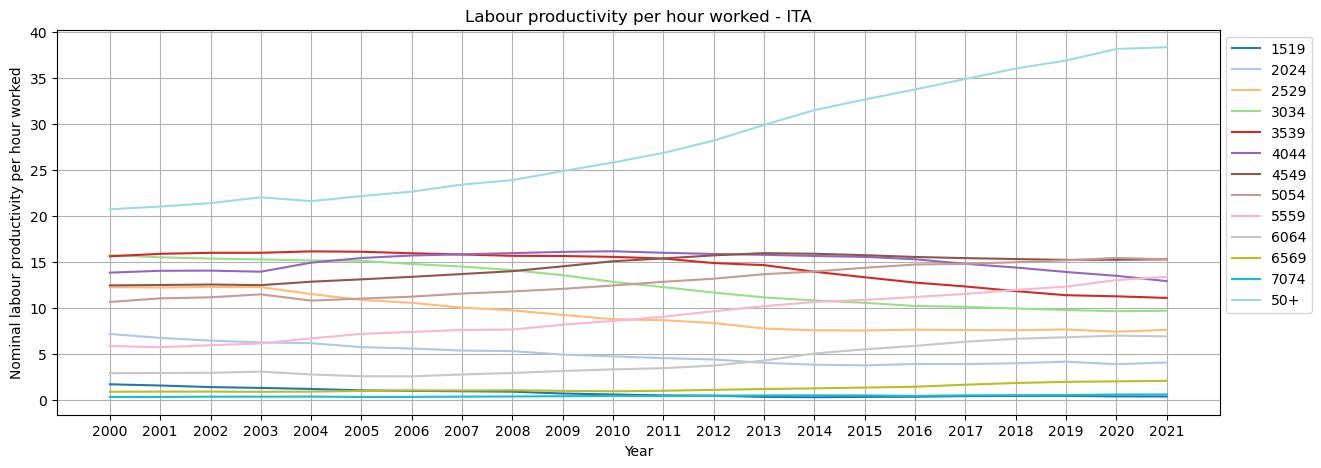

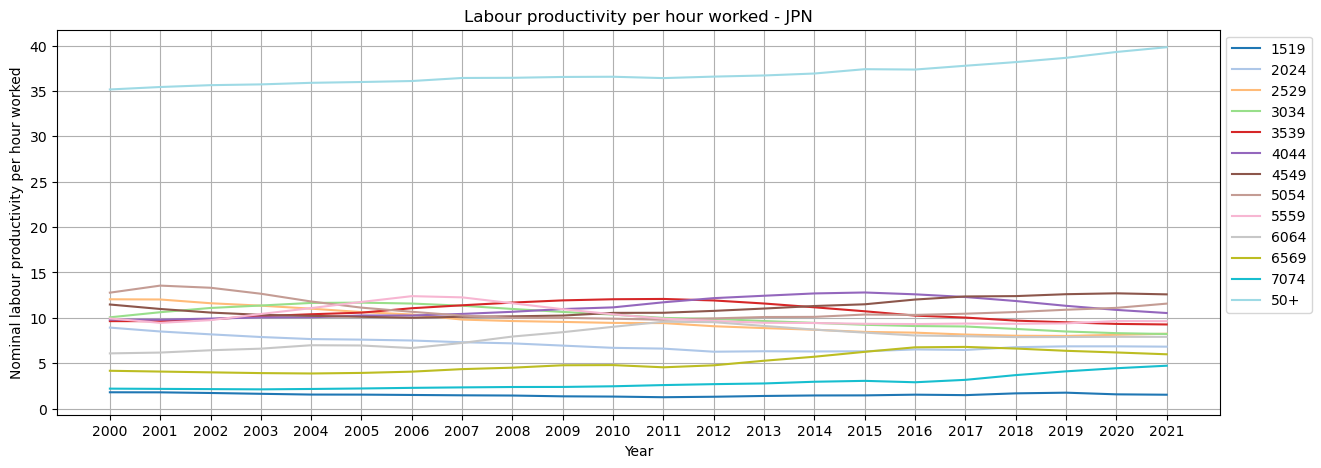

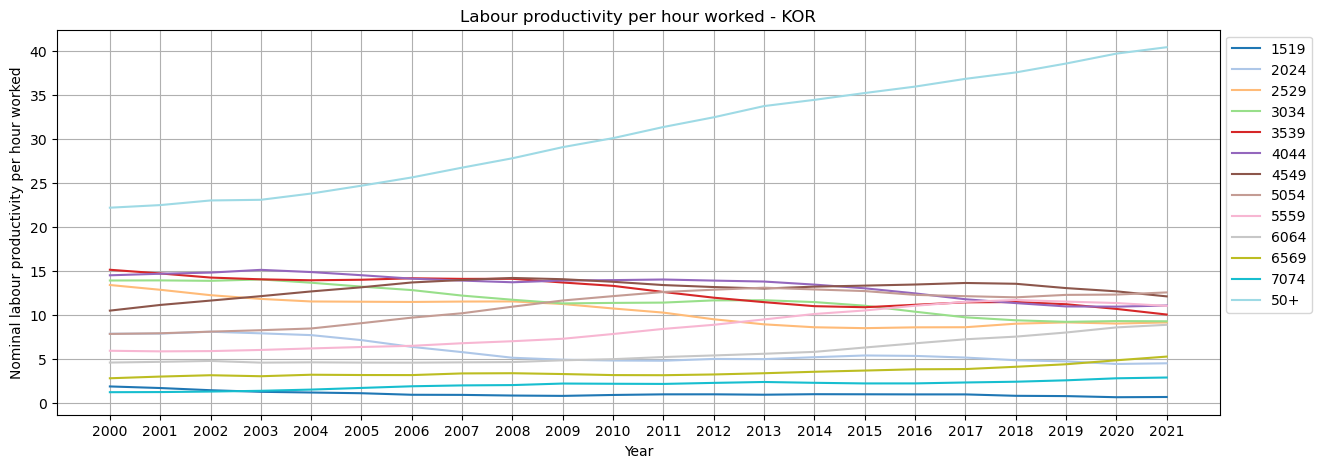

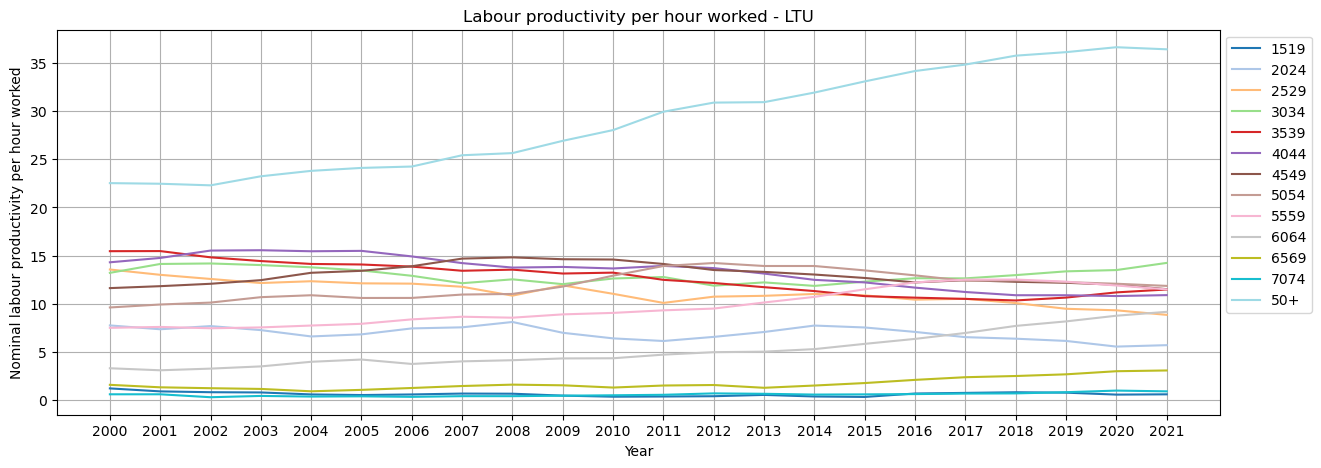

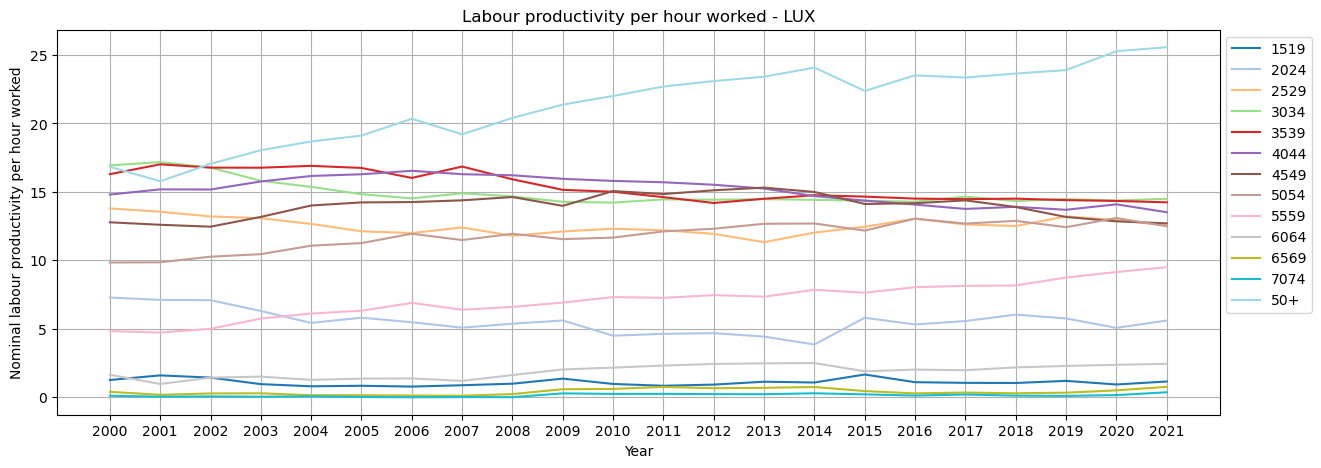

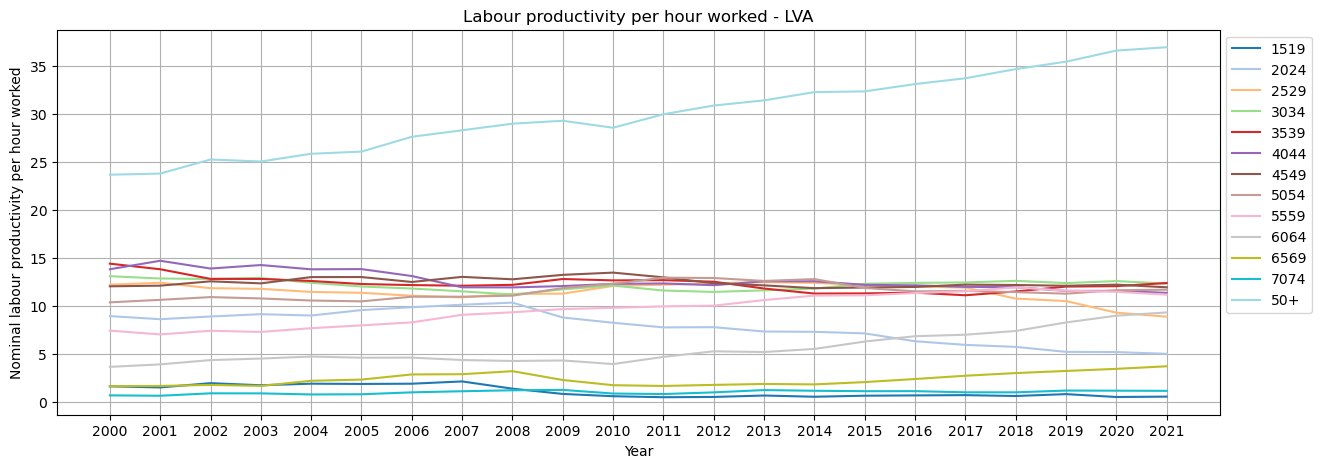

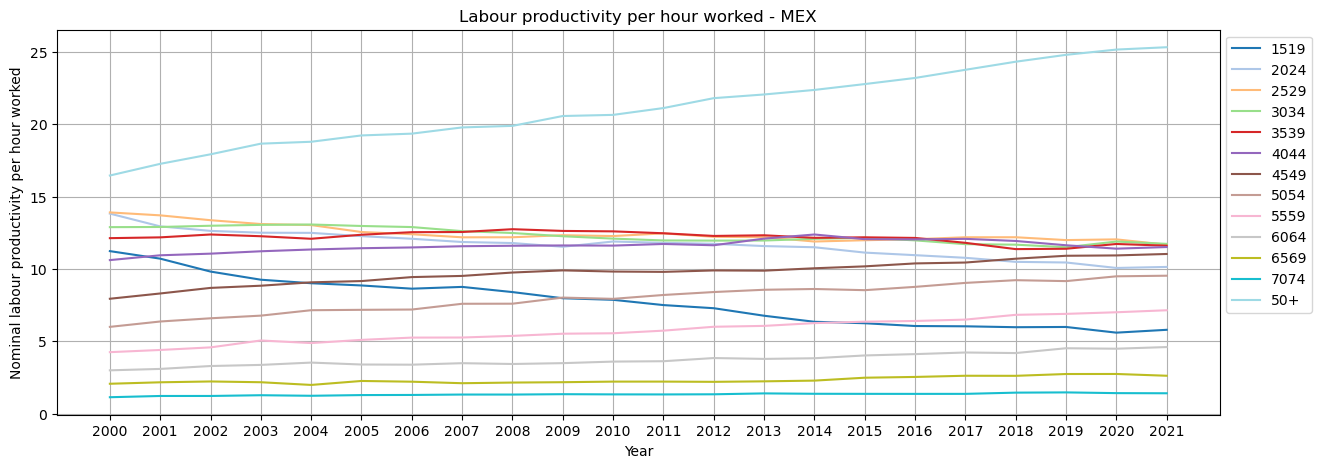

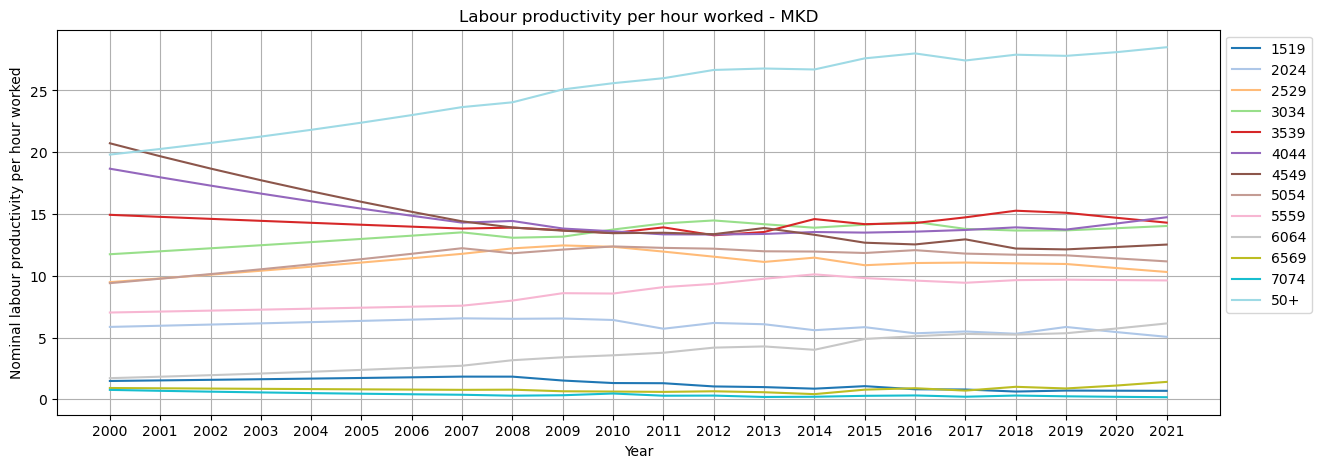

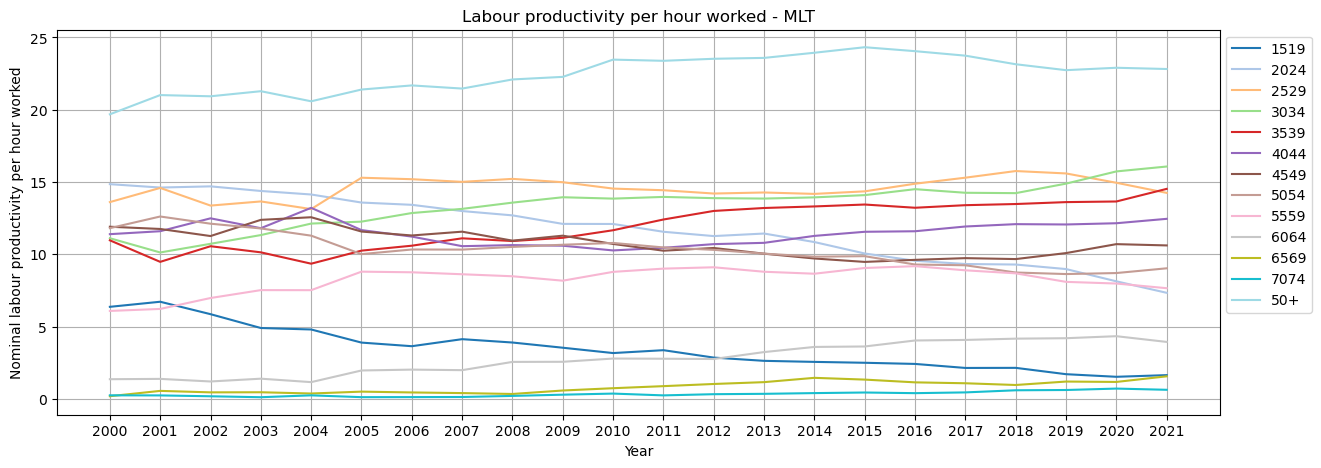

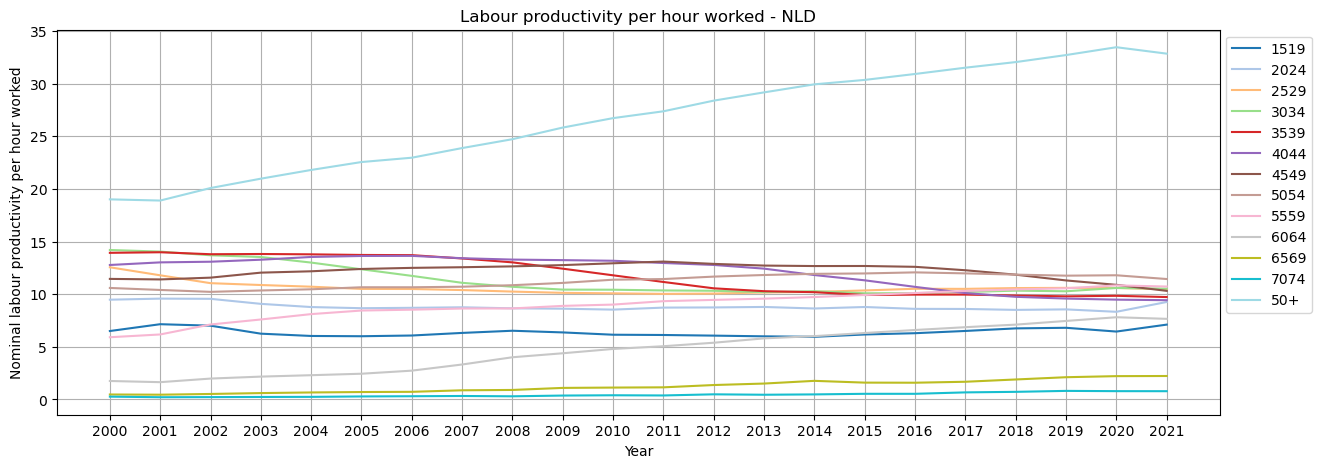

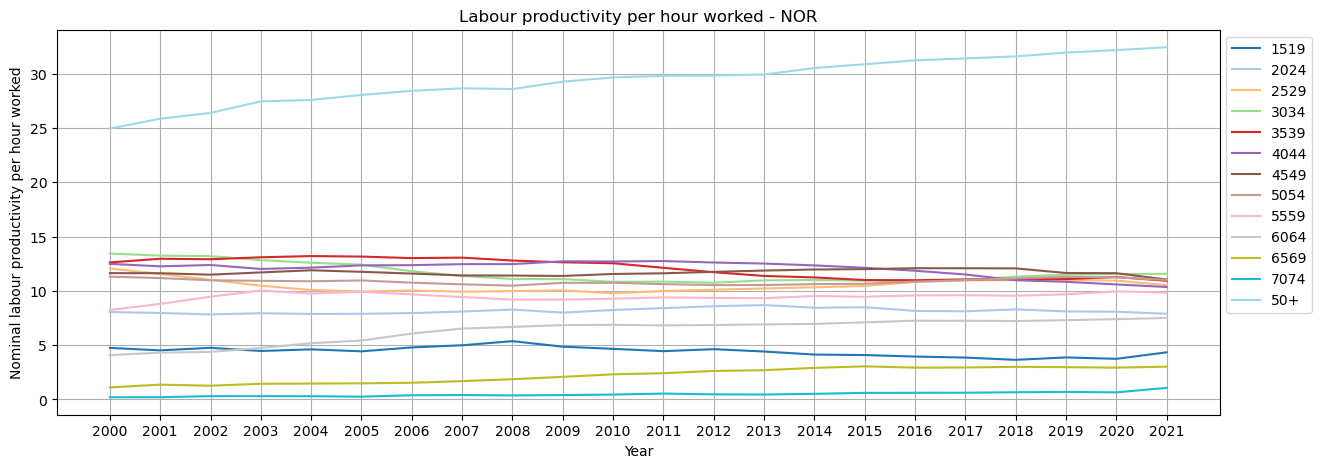

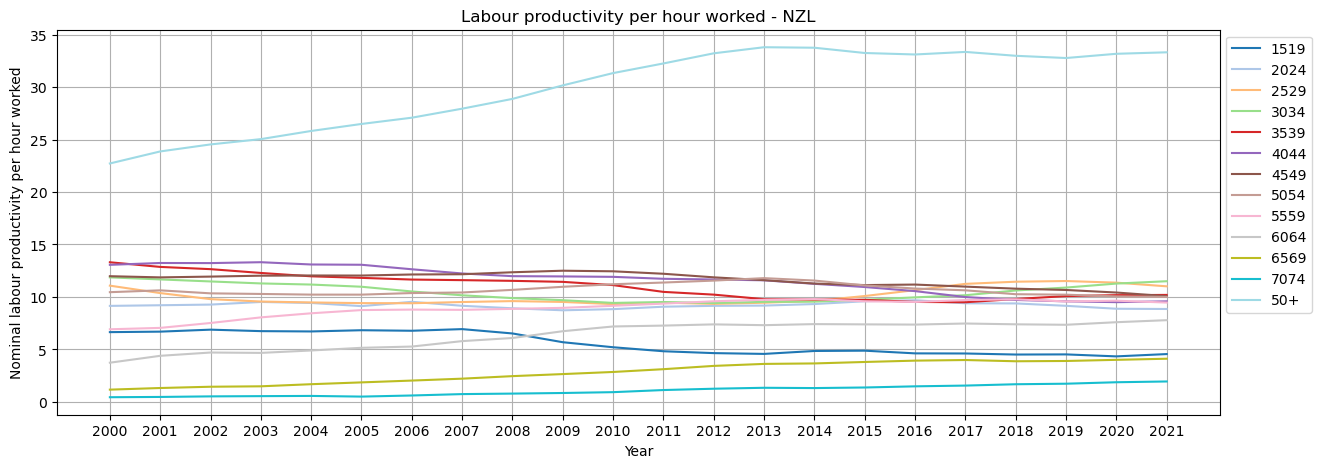

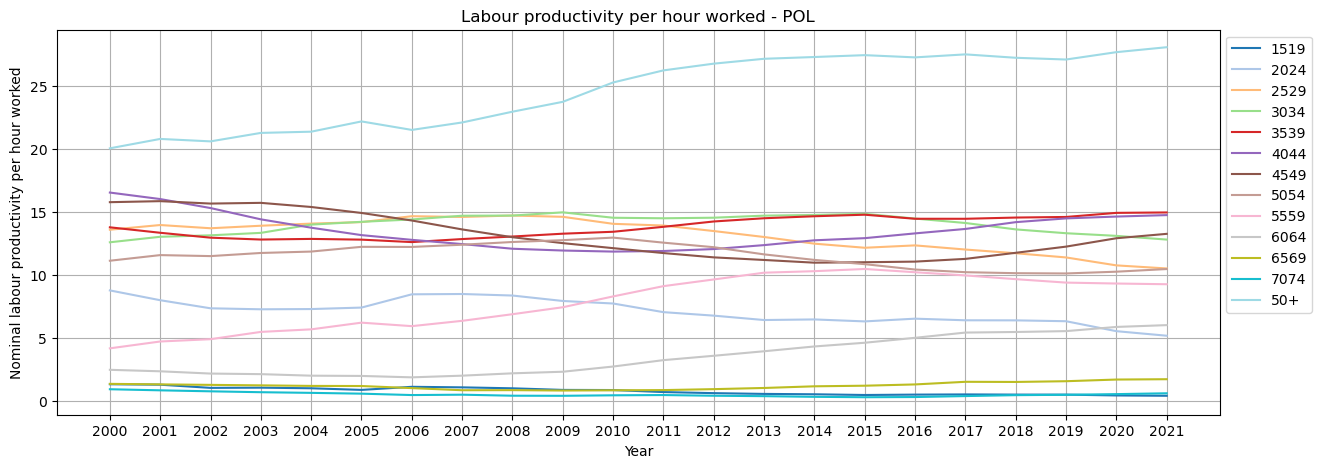

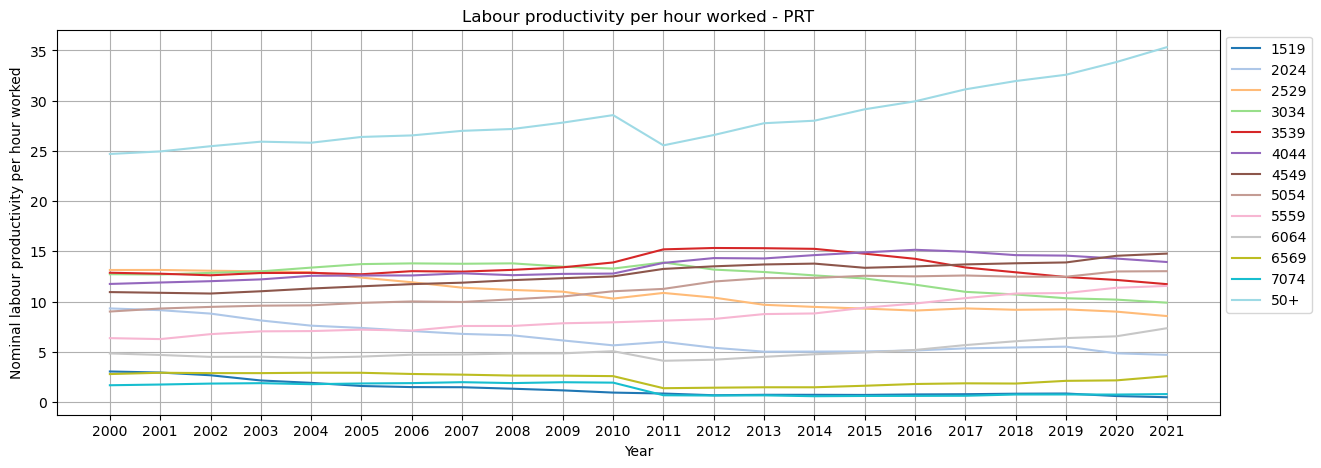

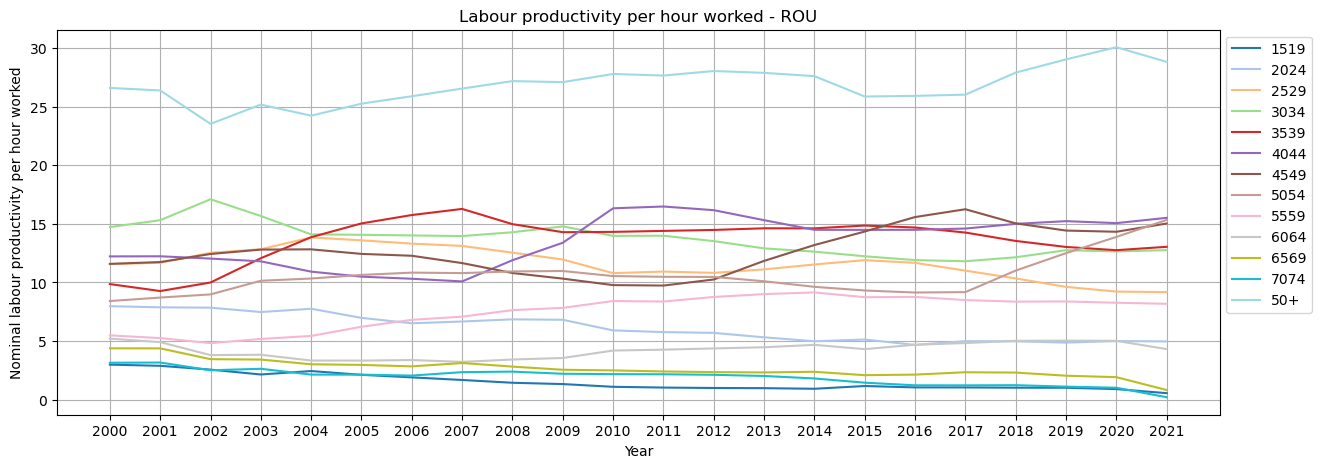

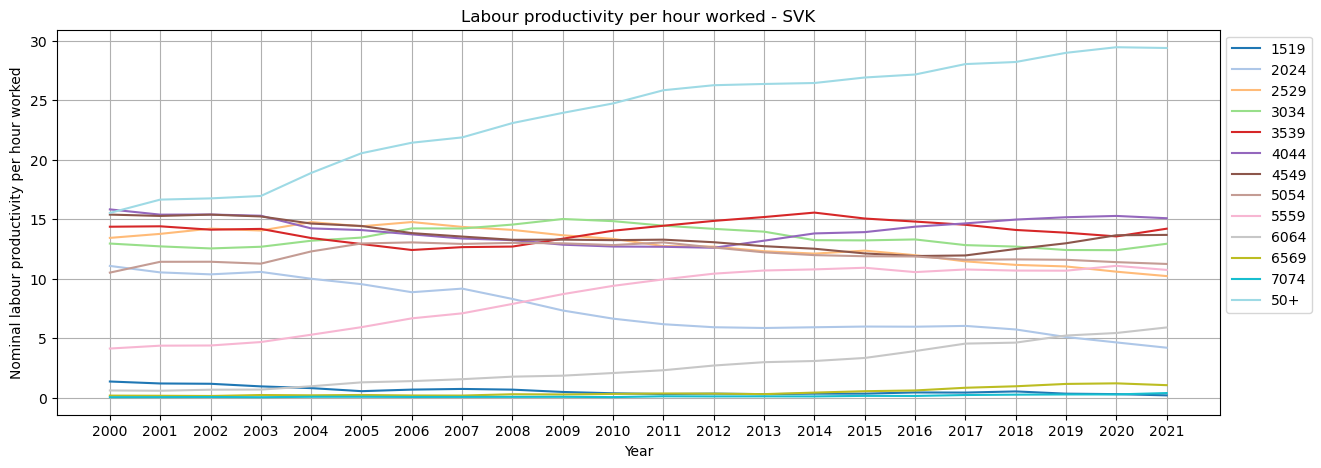

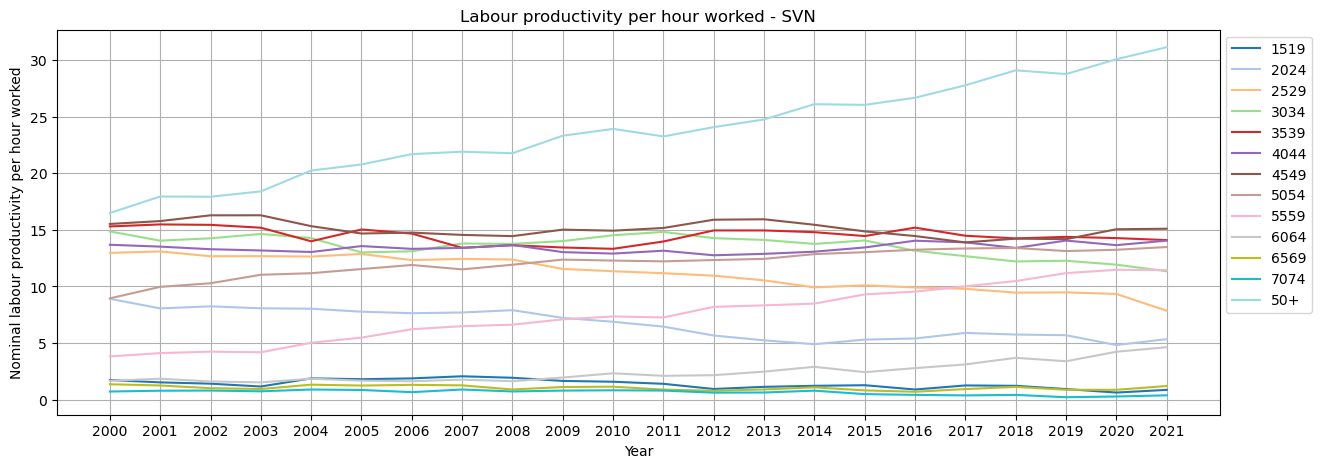

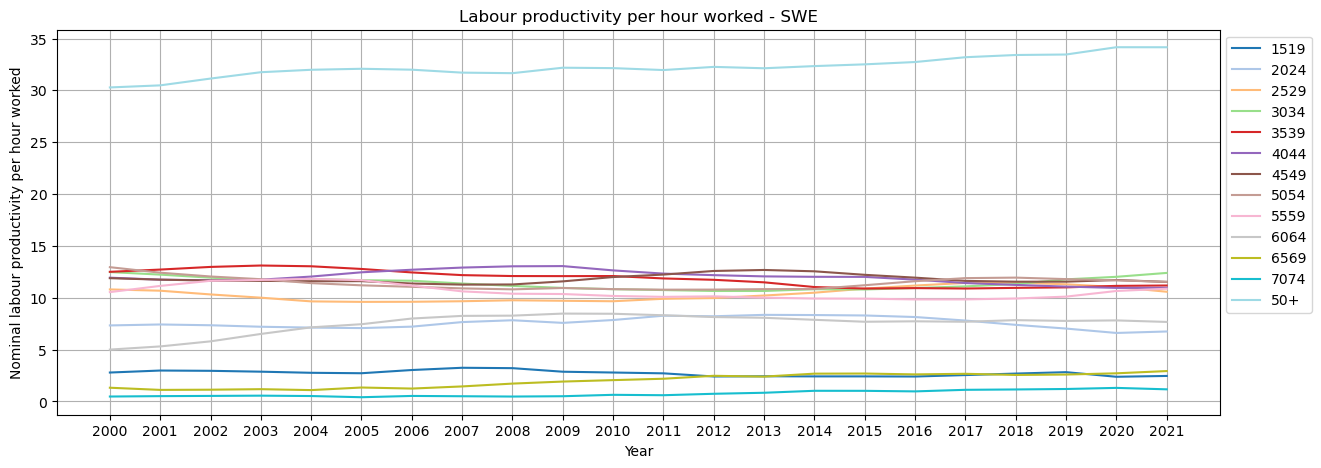

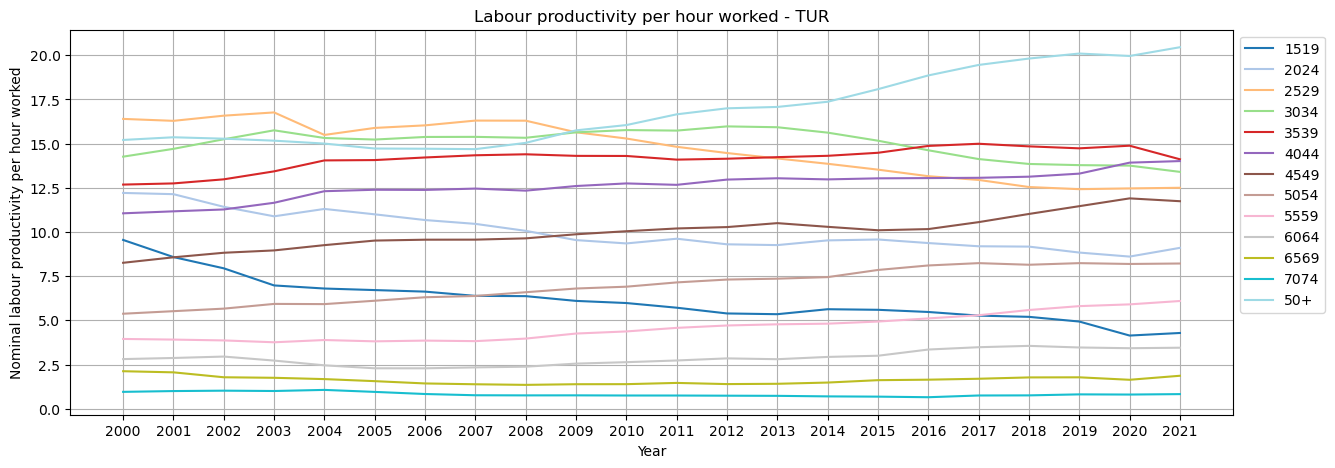

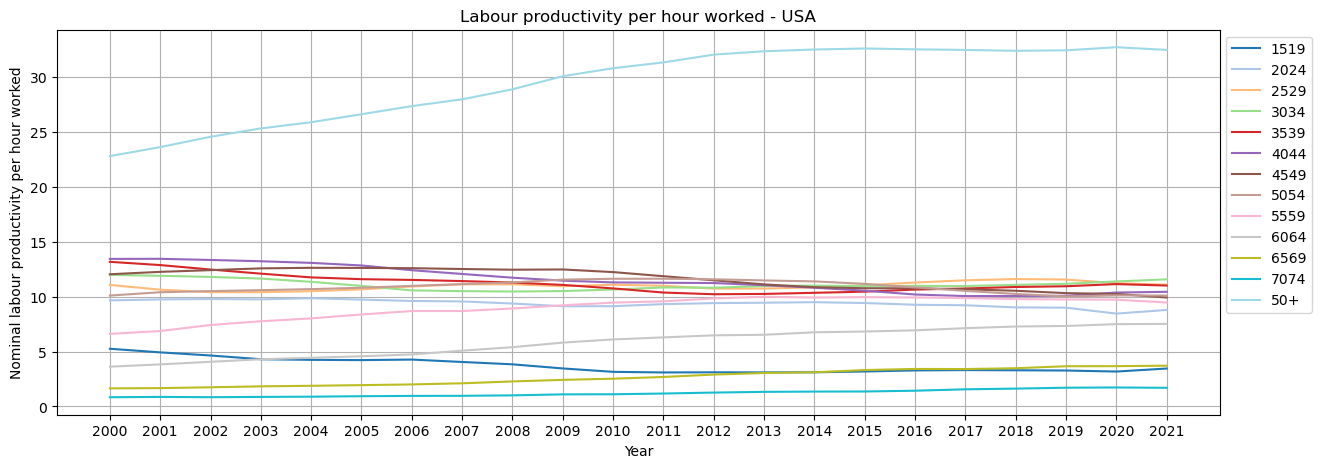

In [17]:
# calculates the target variable (50-74 share of employment in each country) and plots each country's labour force composition throughout time

cleanedData = dataWithInferences
numberOfRows = cleanedData.shape[0]
numberOfColumns = cleanedData.shape[1]

colors = plt.cm.tab20(np.linspace(0, 1, len(cleanedData['AGE'].unique())+1))

for country in cleanedData['COUNTRY'].unique():
    plt.figure(figsize=(15, 5))

    countryData = cleanedData.loc[cleanedData['COUNTRY'] == country]

    startIndex50over = sys.maxsize
    aggregated50overShare = np.zeros(len(countryData.columns[2:]))

    for ageGroup in range(countryData.shape[0]):
        plt.plot(np.array(cleanedData.columns[2:]), countryData.iloc[ageGroup][2:], label=countryData.iloc[ageGroup][1], color=colors[ageGroup])
        
        if str(countryData.iloc[ageGroup][1]).startswith('50'):
            startIndex50over = ageGroup

        if ageGroup >= startIndex50over:
            aggregated50overShare += countryData.iloc[ageGroup][2:]

    plt.plot(np.array(cleanedData.columns[2:]), aggregated50overShare, label='50+', color=colors[-1])

    aggregated50overShareIndices = np.array([country, '5074'])
    aggregated50overShare = np.concatenate((aggregated50overShareIndices, aggregated50overShare))
    aggregated50overShare = aggregated50overShare.reshape(1, -1)
    df = pd.DataFrame(aggregated50overShare, columns=cleanedData.columns)
    cleanedData = cleanedData.append(df, ignore_index=True)
    
    plt.grid()
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
    plt.xlabel('Year') 
    plt.ylabel('Nominal labour productivity per hour worked') 
    plt.title("Labour productivity per hour worked - " + country)

    plt.show()

In [10]:
# reads the cleaned productivity dataset

productivityPreprocessedDataDirectory = '../Datasets/cleaned_Productivity.csv'
cleanedProductivityData = pd.read_csv(productivityPreprocessedDataDirectory, header=0, nrows=None)
cleanedProductivityData.rename(columns={'LOCATION': 'COUNTRY'}, inplace=True)

In [11]:
# extracts the target variable rows from the whole labour force composition dataset

compatibleData = pd.DataFrame(columns=cleanedData.columns)

for country in cleanedData['COUNTRY'].unique():
    country50overData = cleanedData.loc[cleanedData['COUNTRY'] == country].iloc[-1]

    df = pd.DataFrame([country50overData], columns=cleanedData.columns)
    compatibleData = pd.concat([compatibleData, df])

In [12]:
# drops the 'AGE' column because it is not needed anymore, we only have one unique value in it: 5074

compatibleData = compatibleData.drop(['AGE'], axis=1)
compatibleData = compatibleData.reset_index(drop=True)

0.9397323840632982


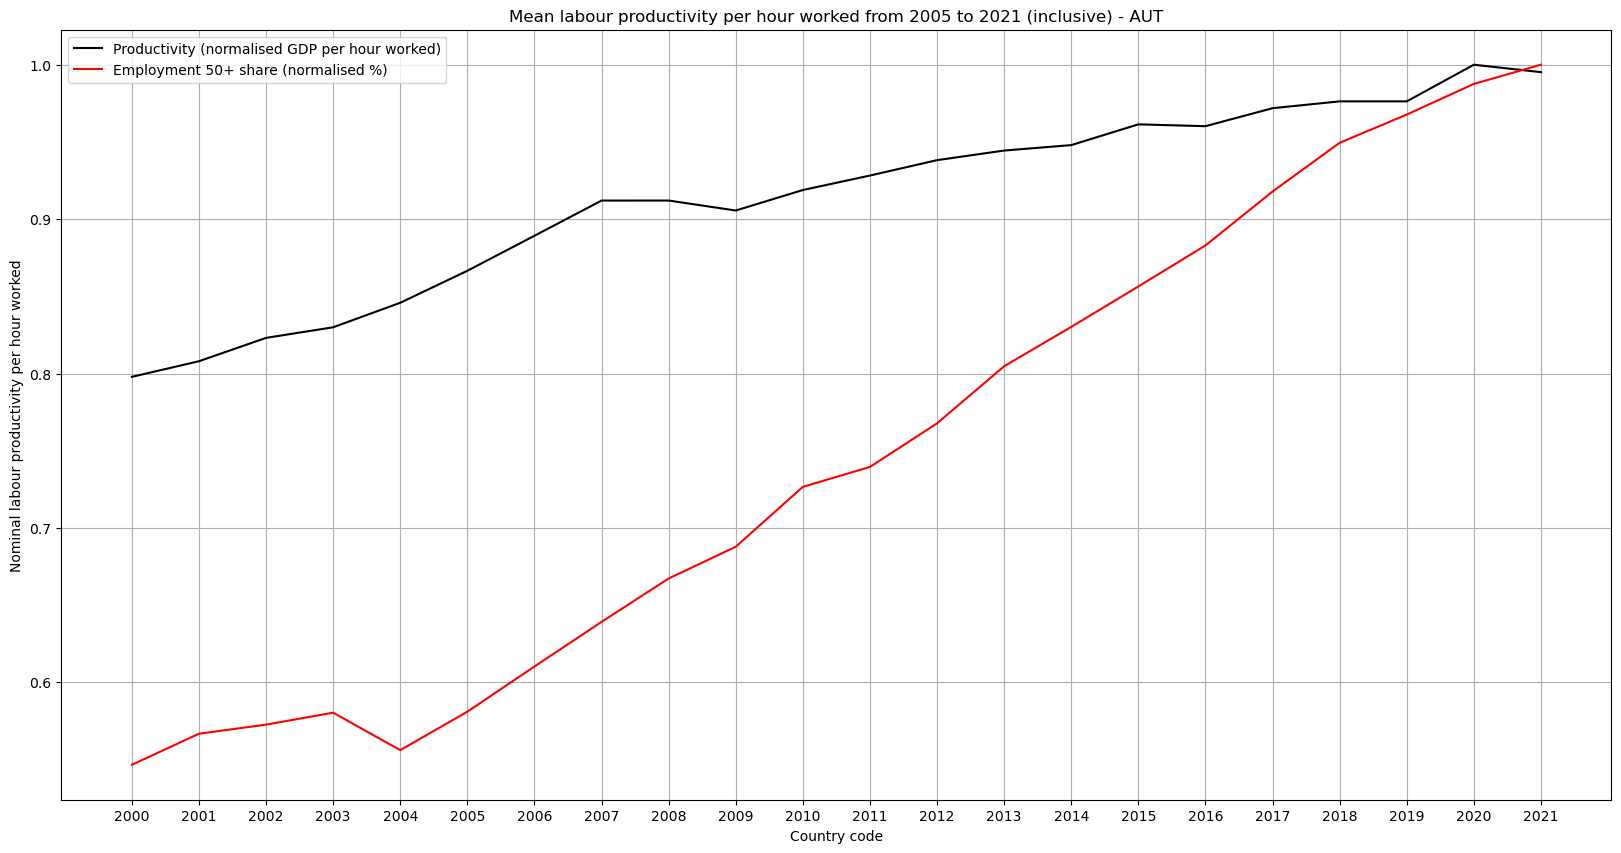

0.9642718331242619


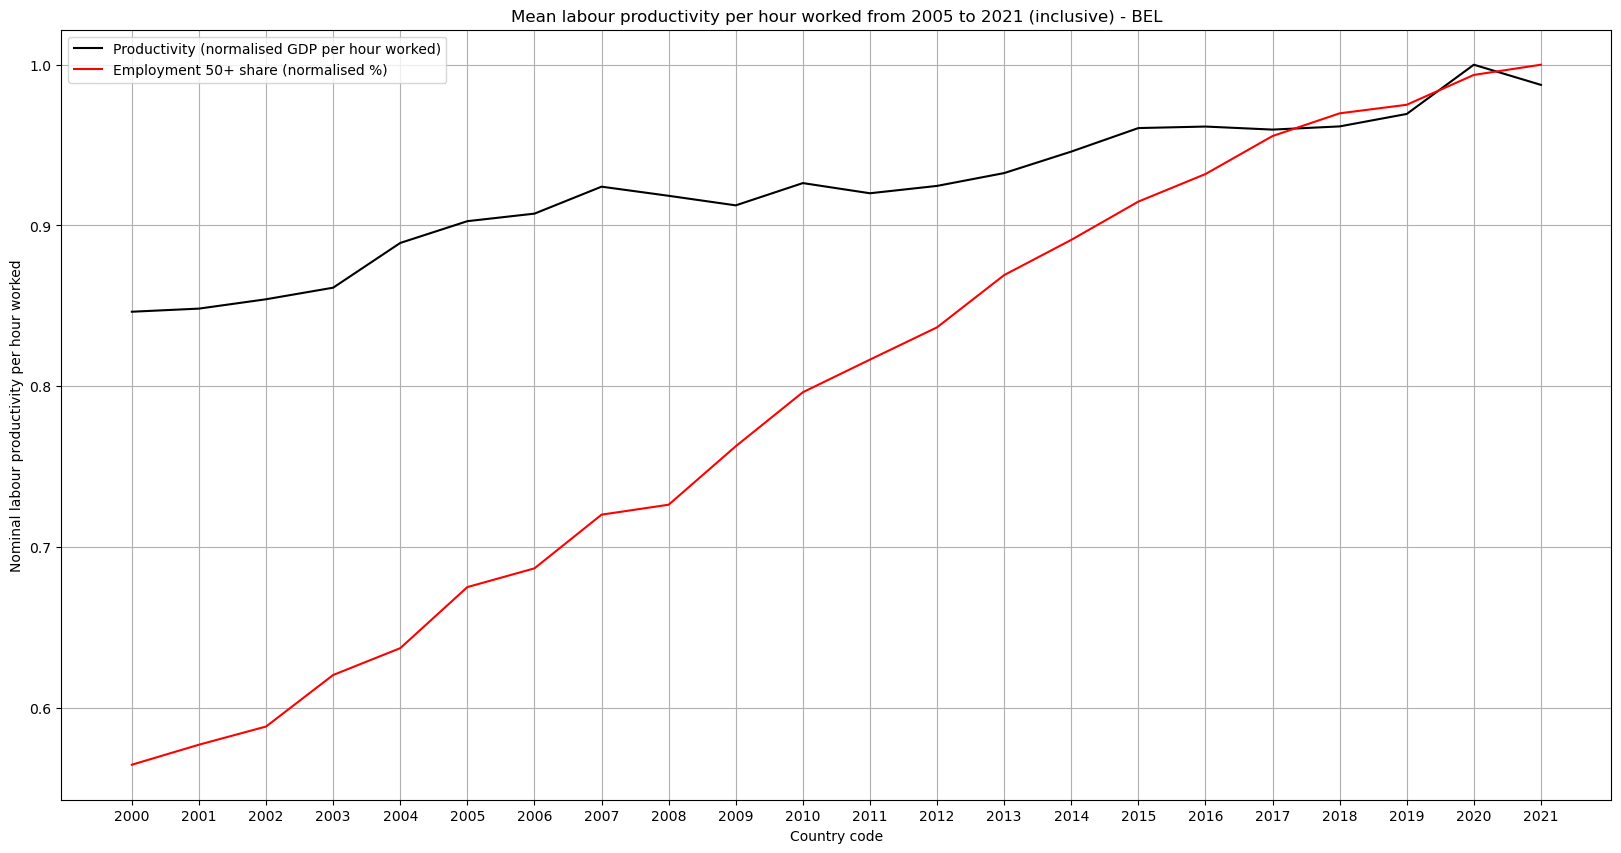

0.982733015002075


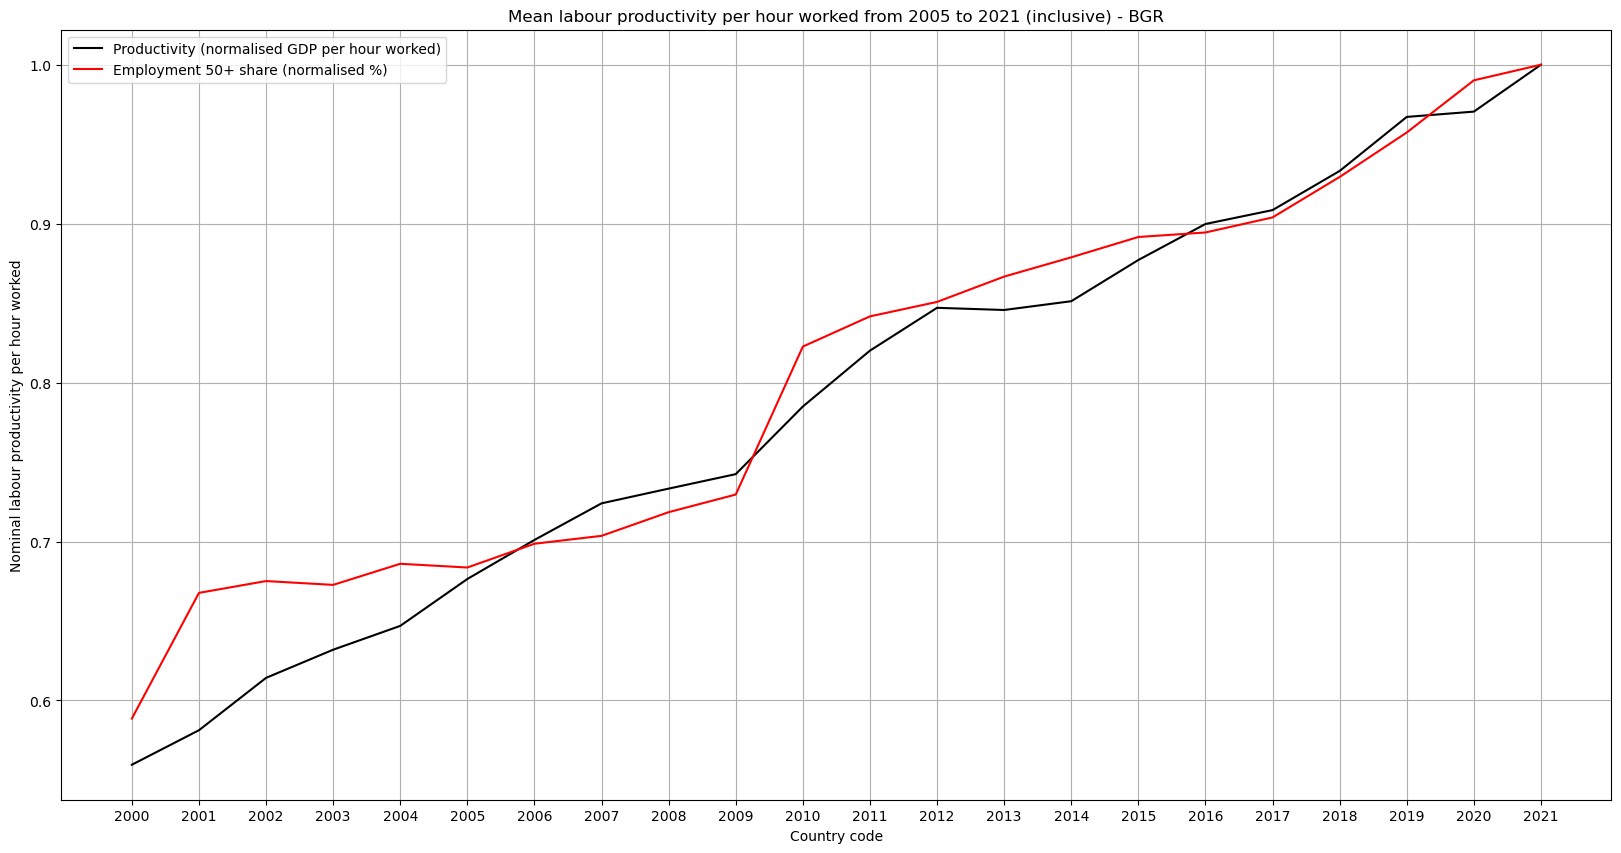

0.9097160802058933


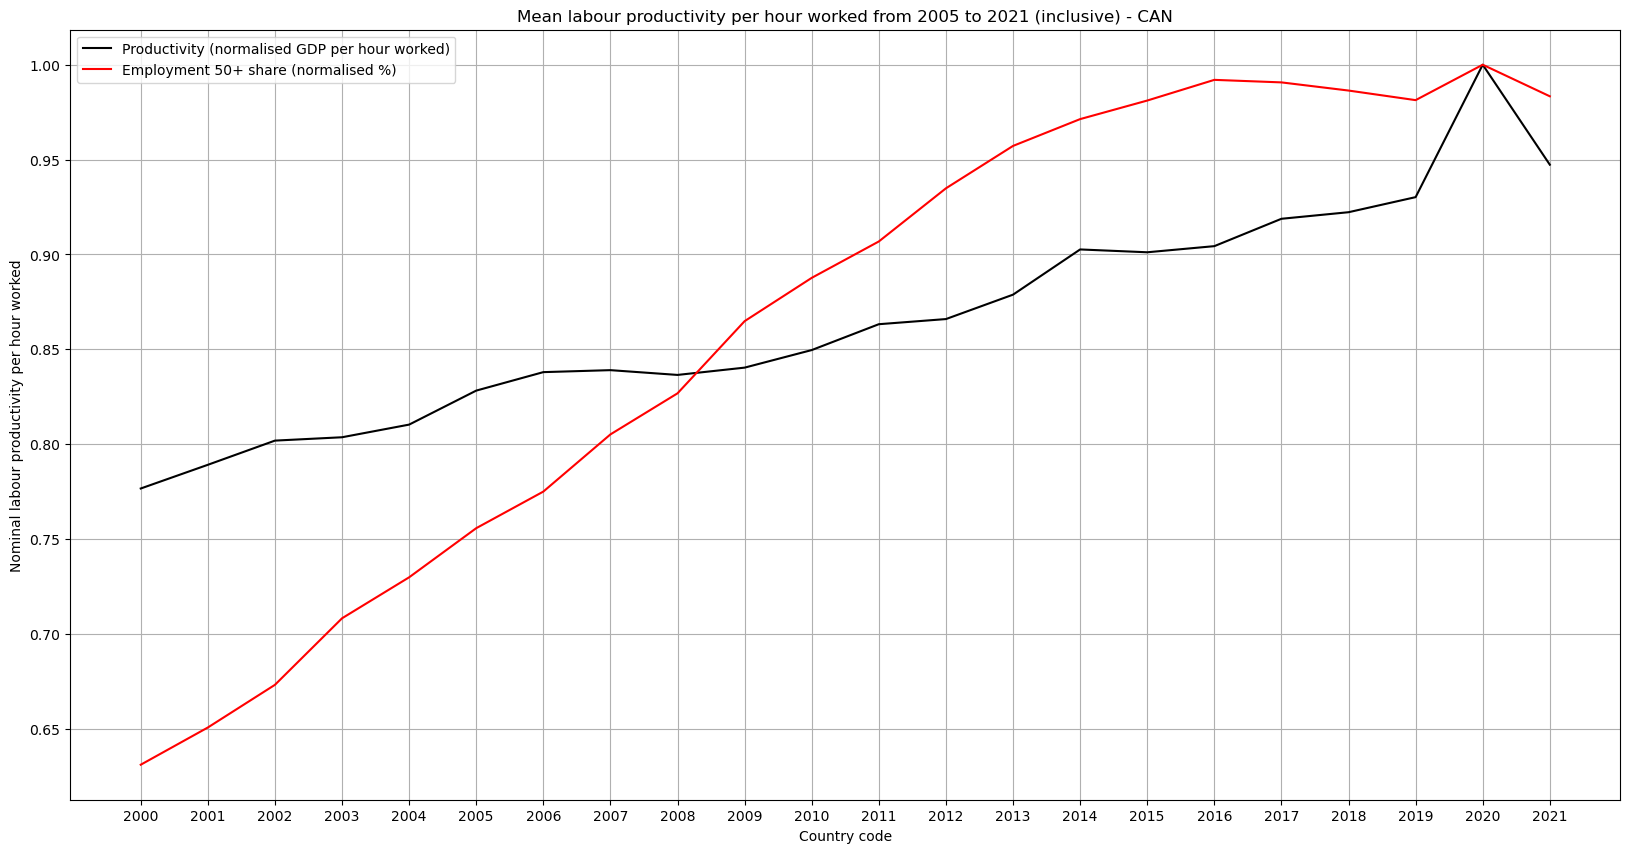

0.9640954864195038


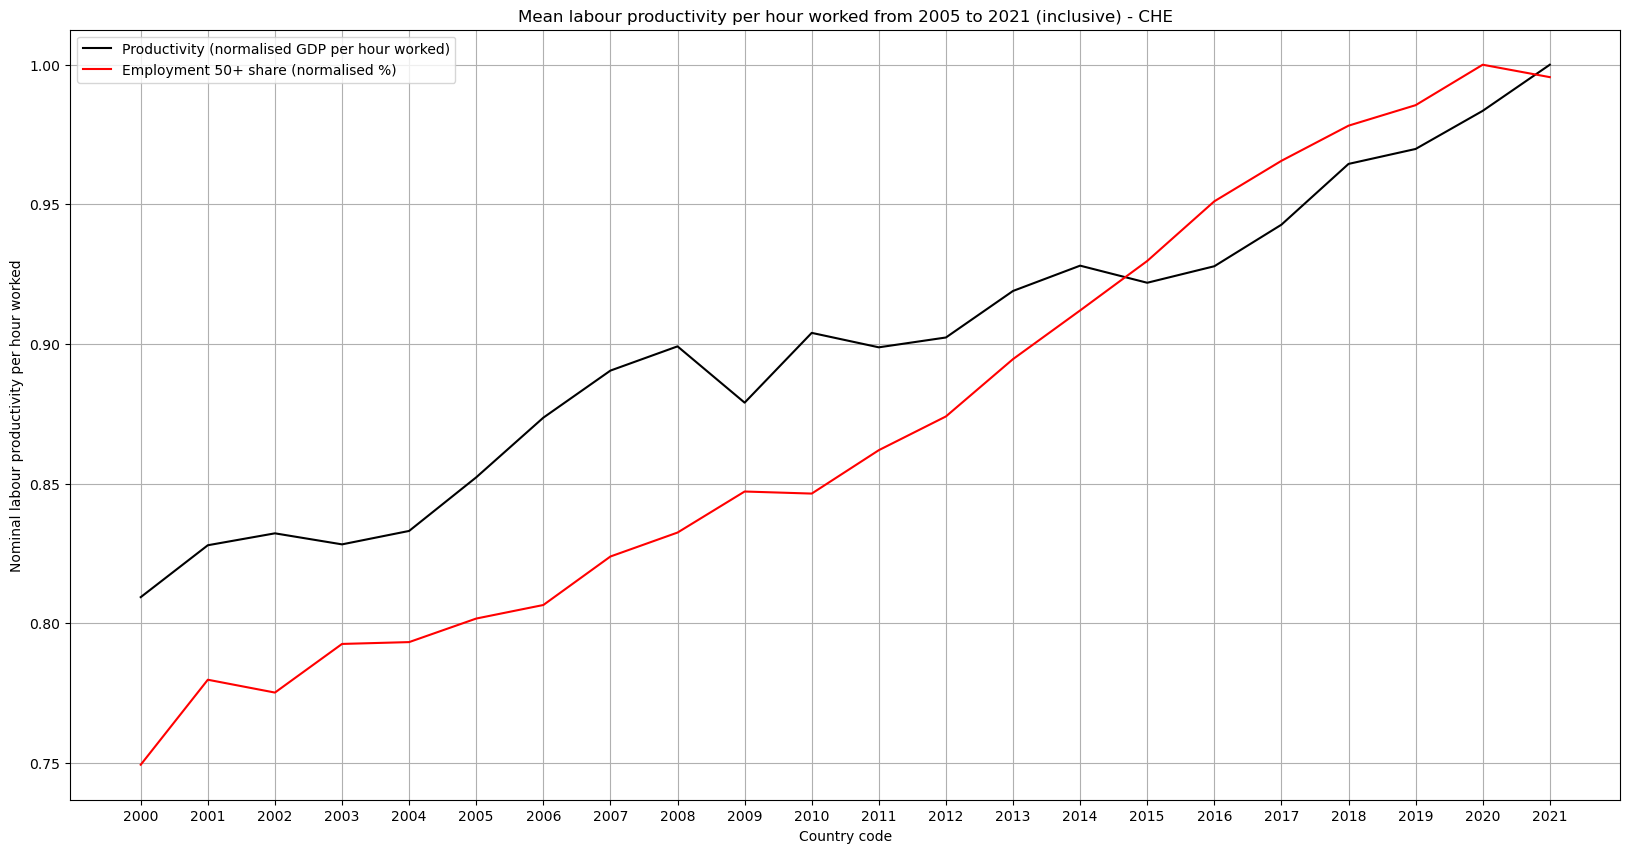

0.7369121944982573


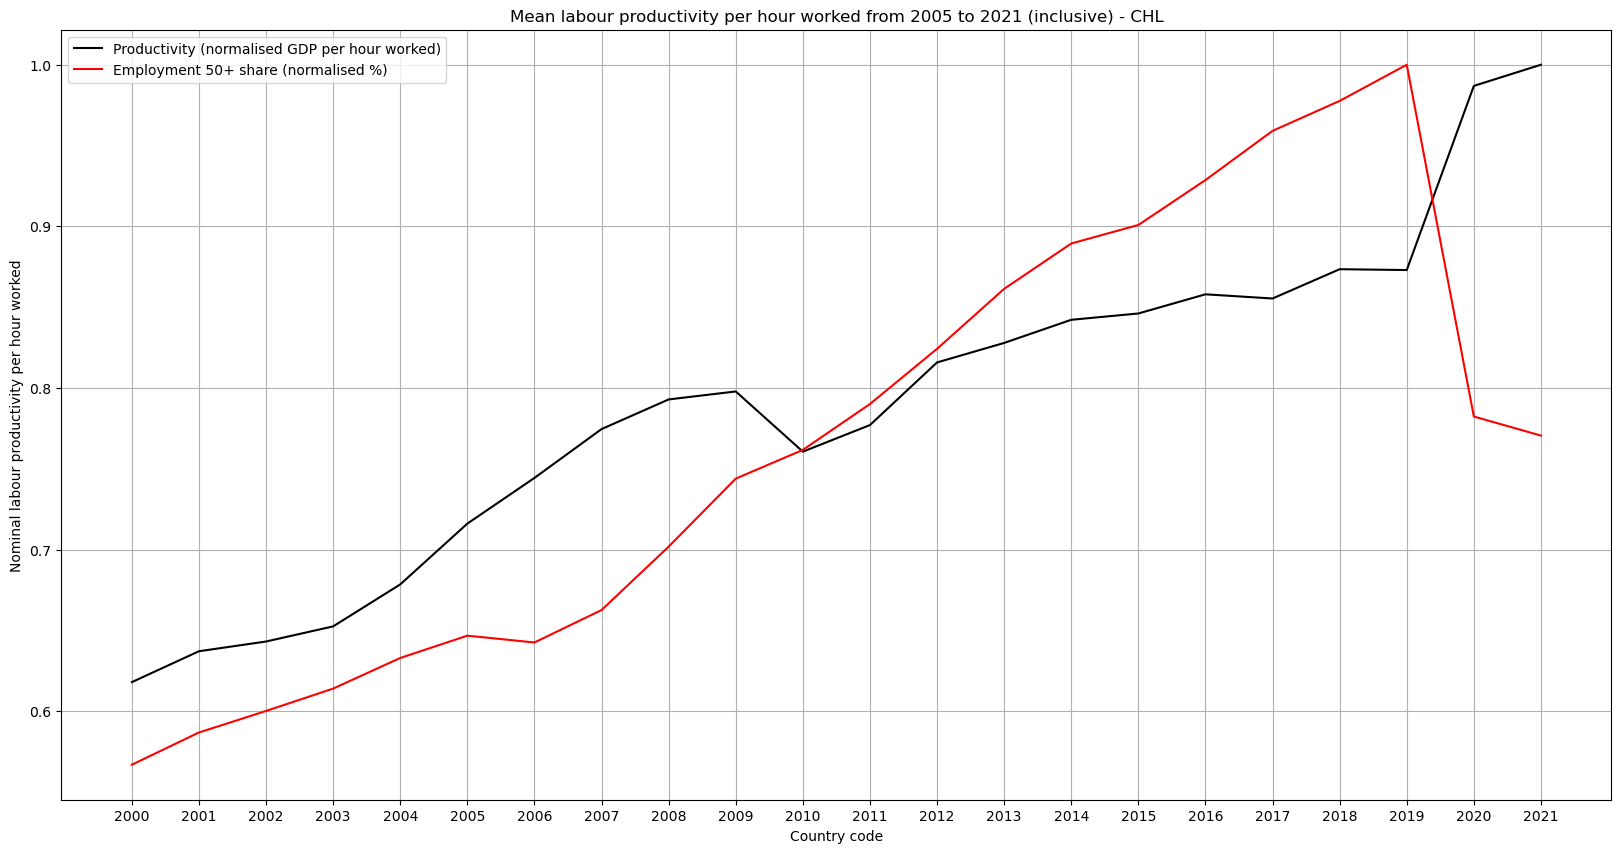

0.9225918665101072


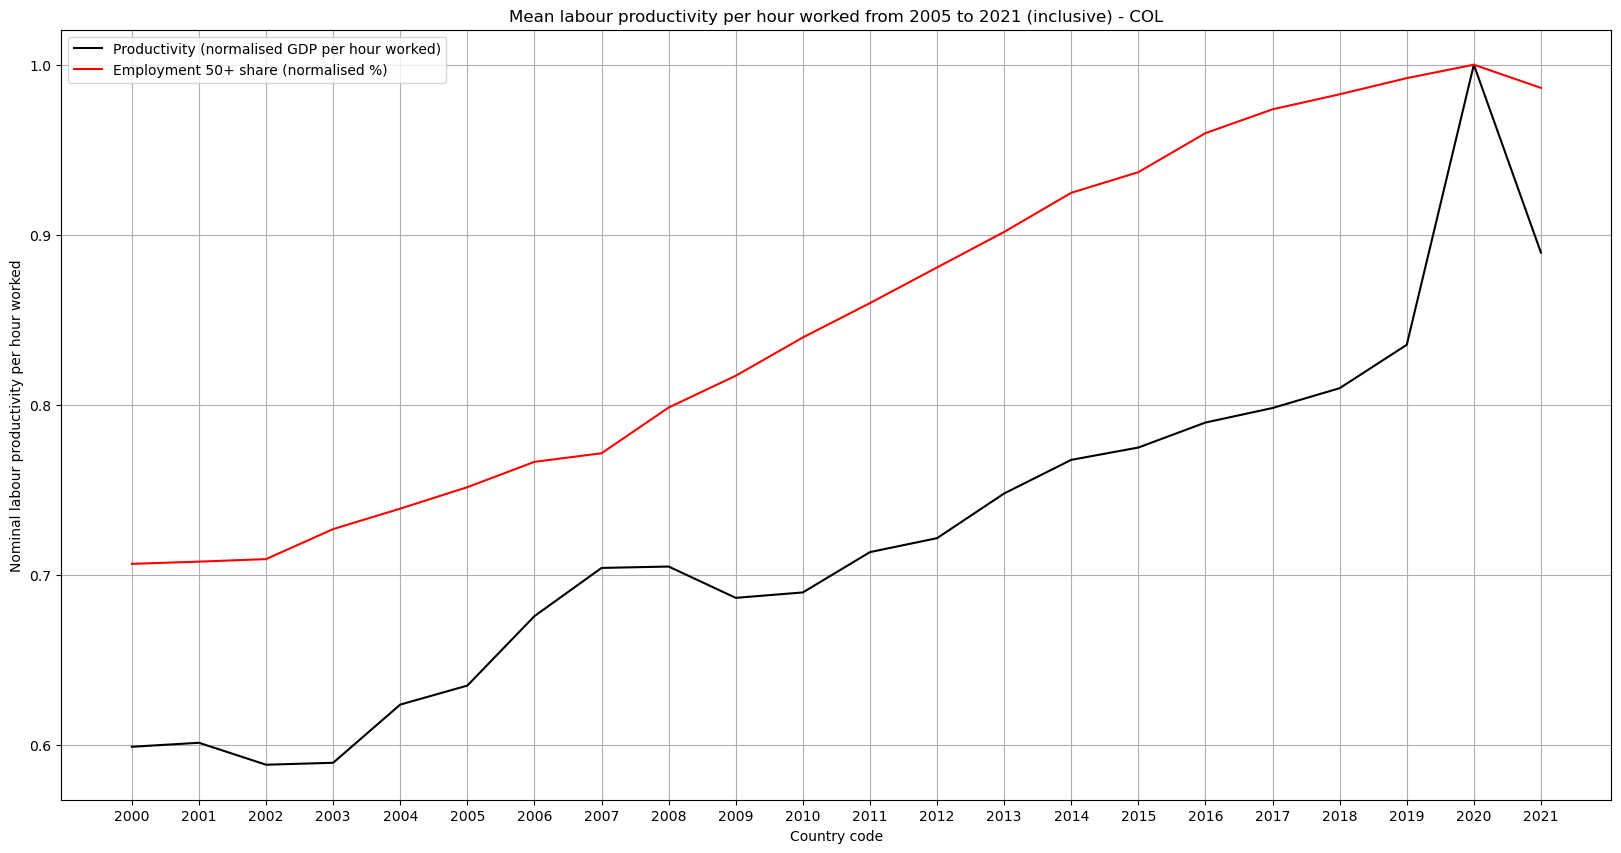

0.9644070343468073


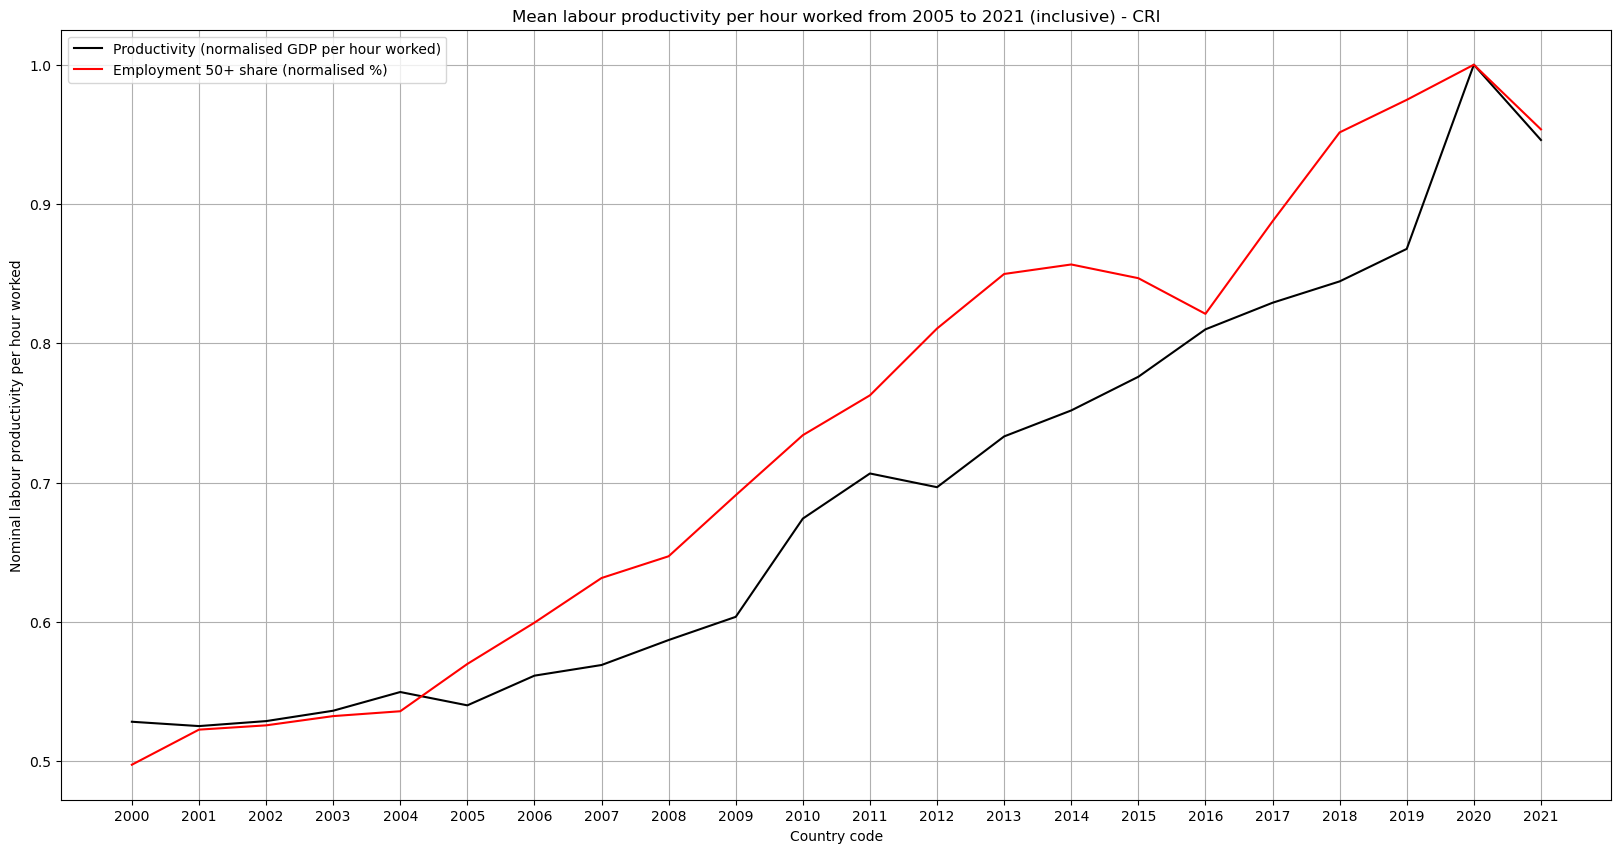

0.9766861393450853


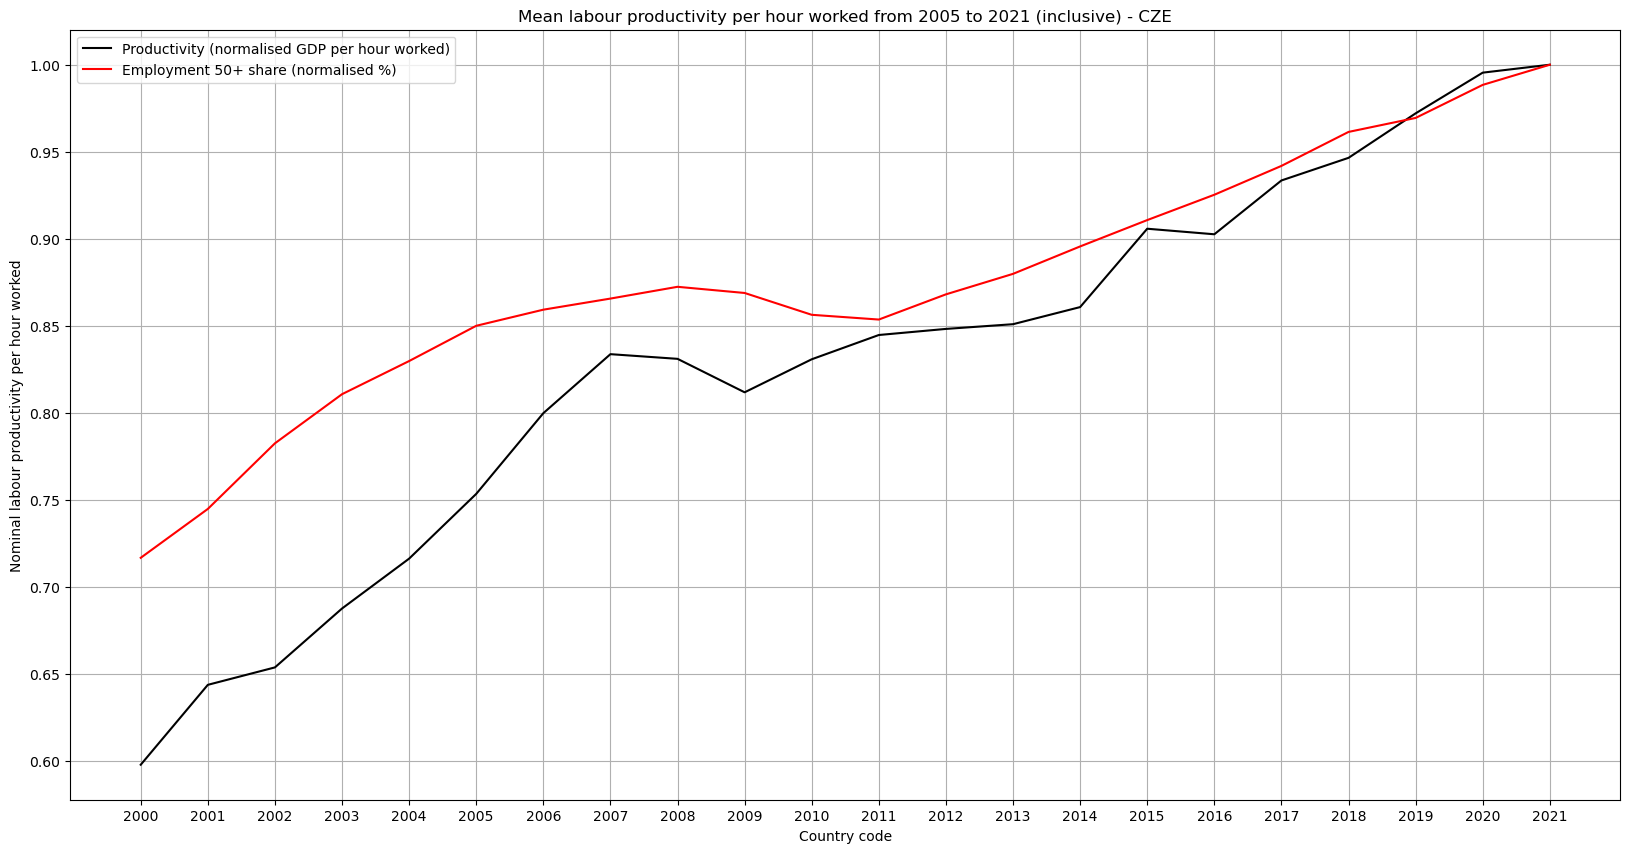

0.9703859590971571


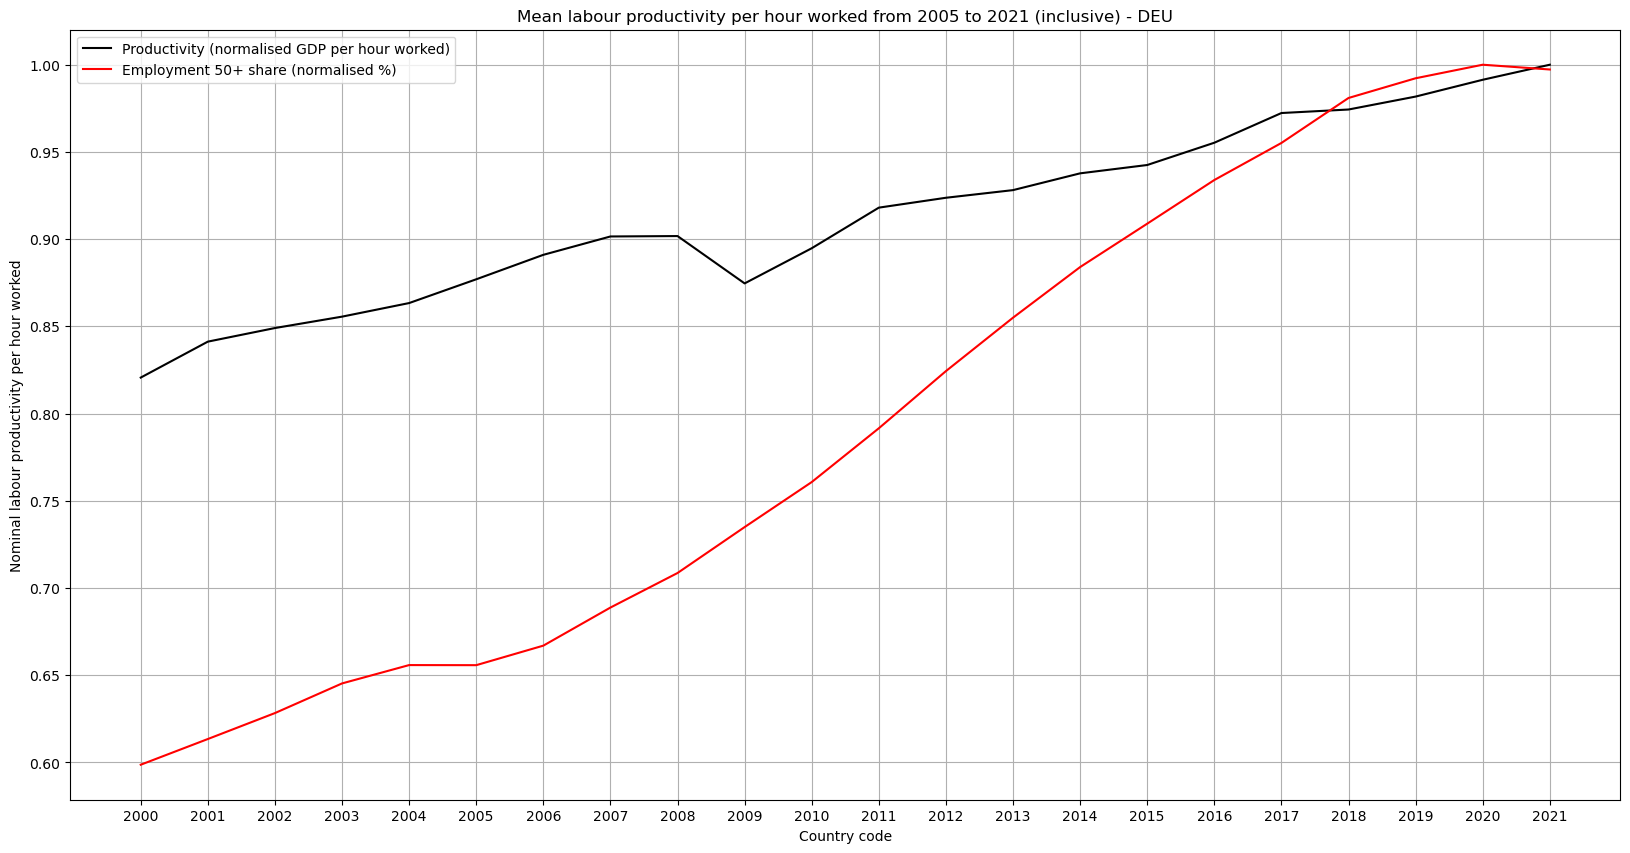

0.980321808043904


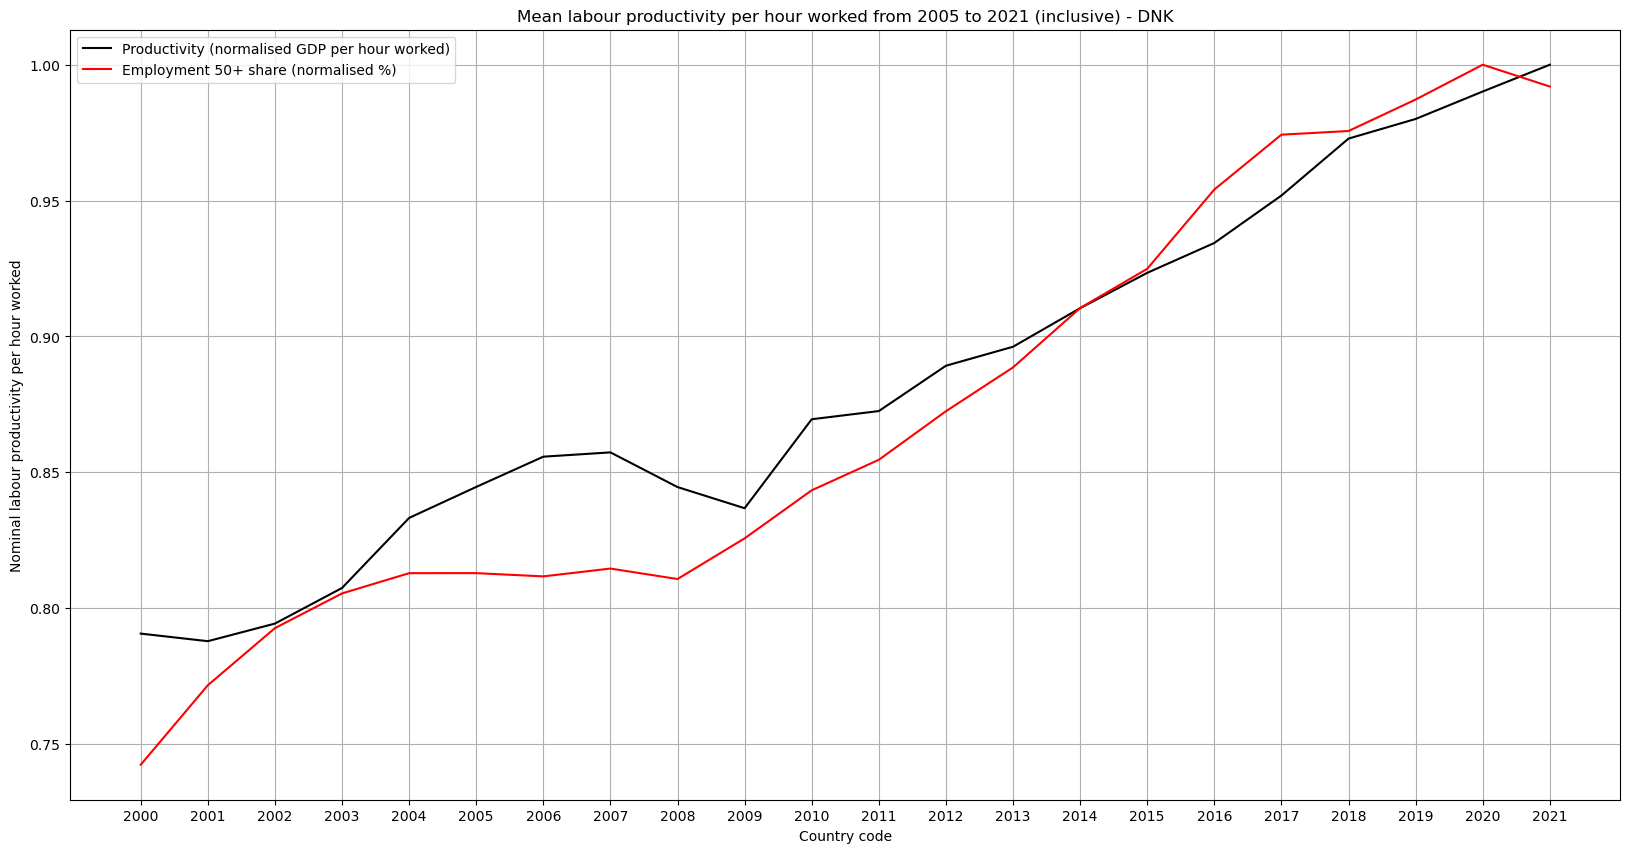

0.9602364085450935


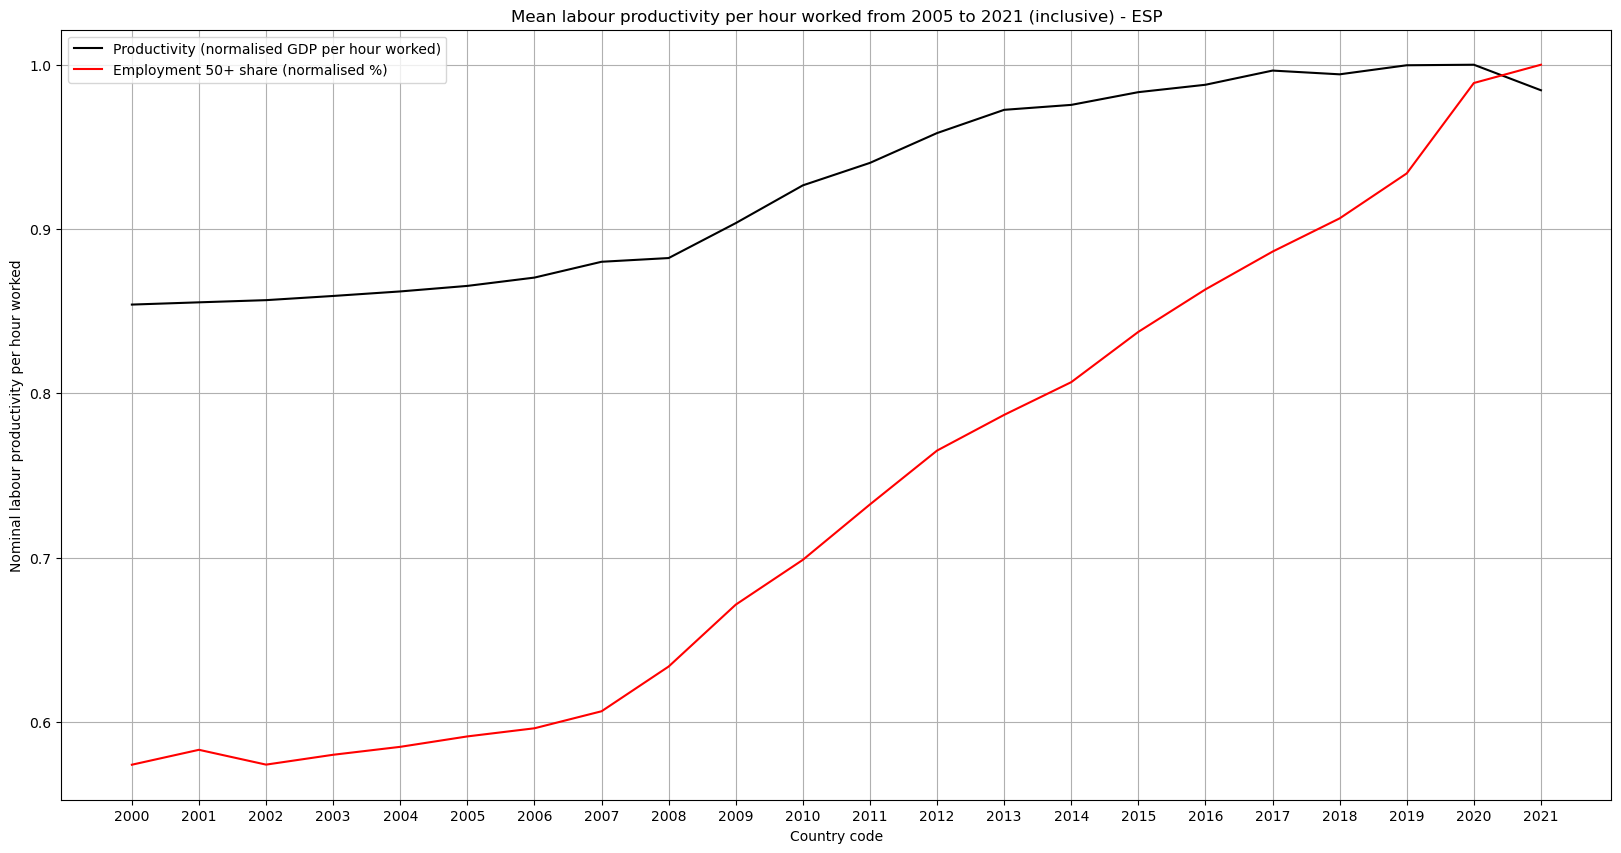

0.974593925131167


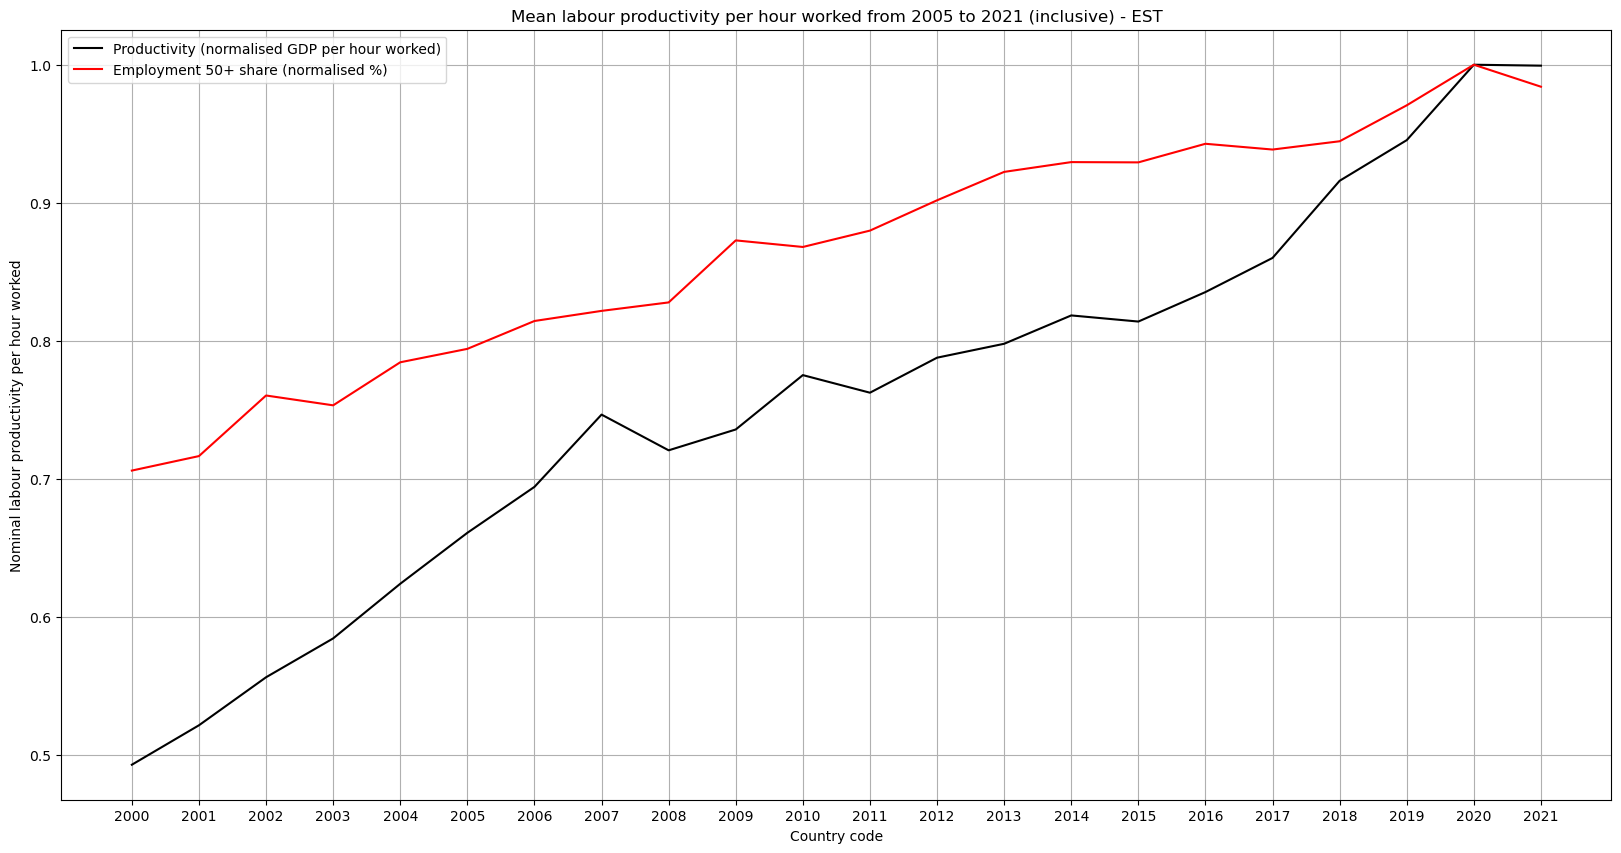

0.937622074976351


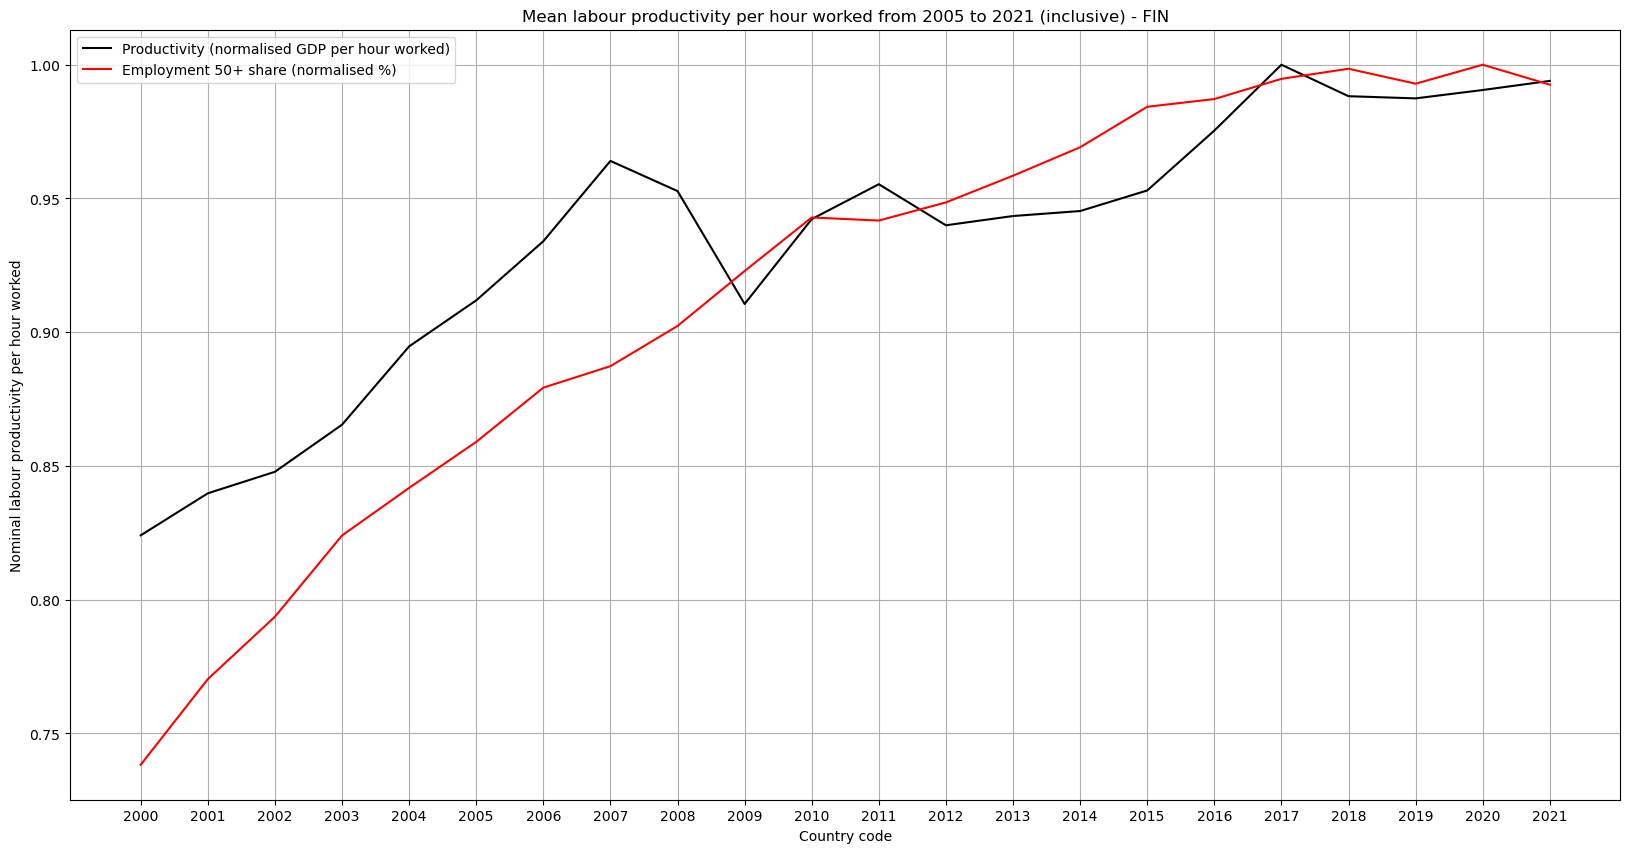

0.9695869118357484


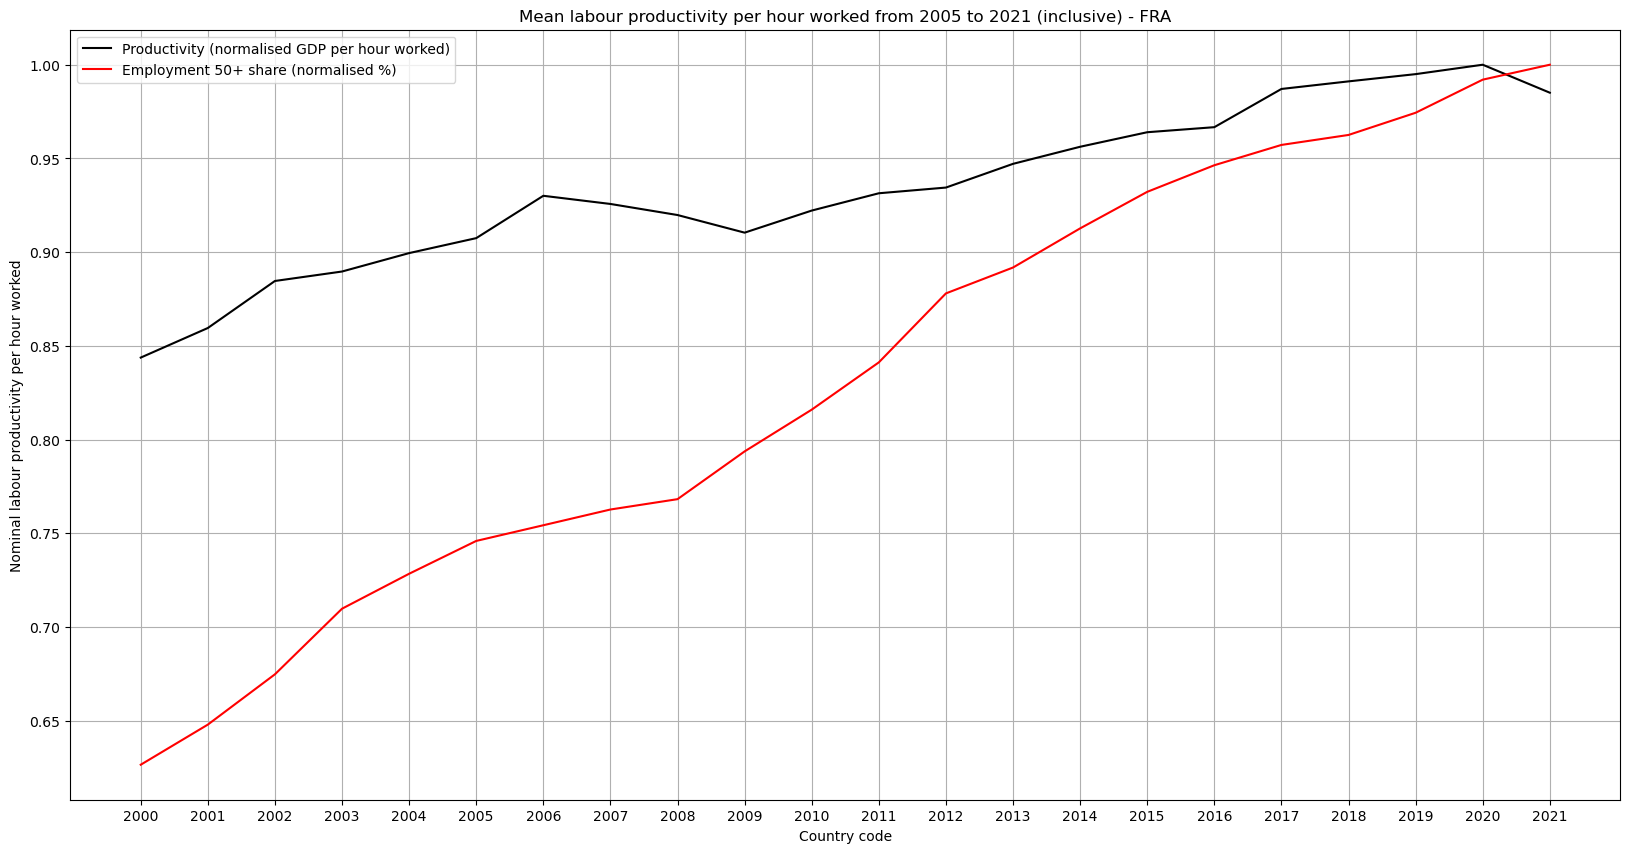

0.9203051667932654


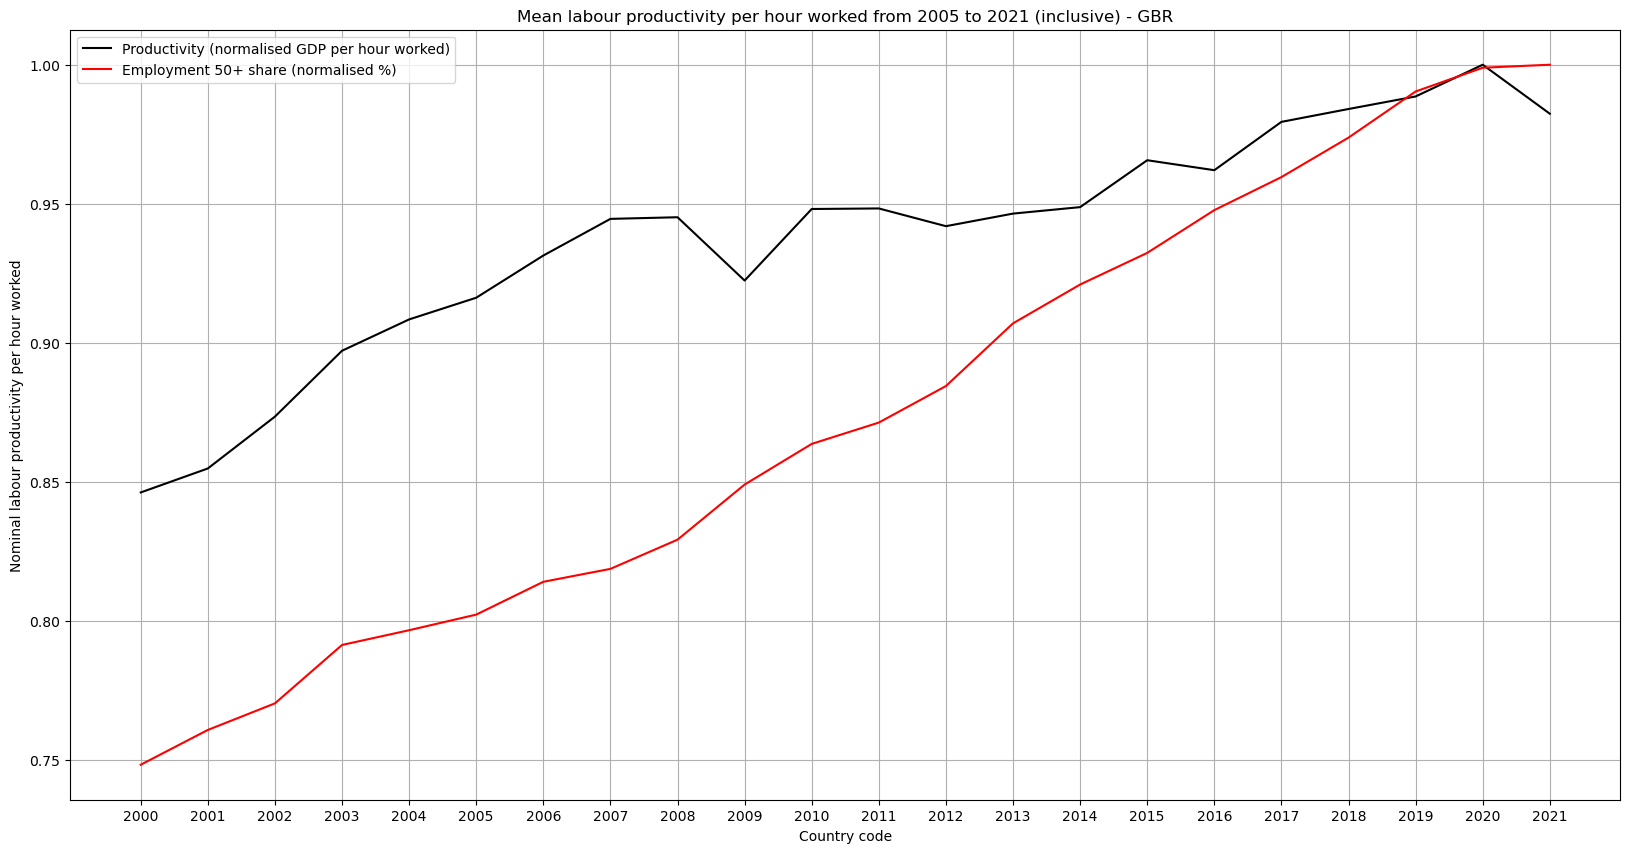

-0.6921448971843558


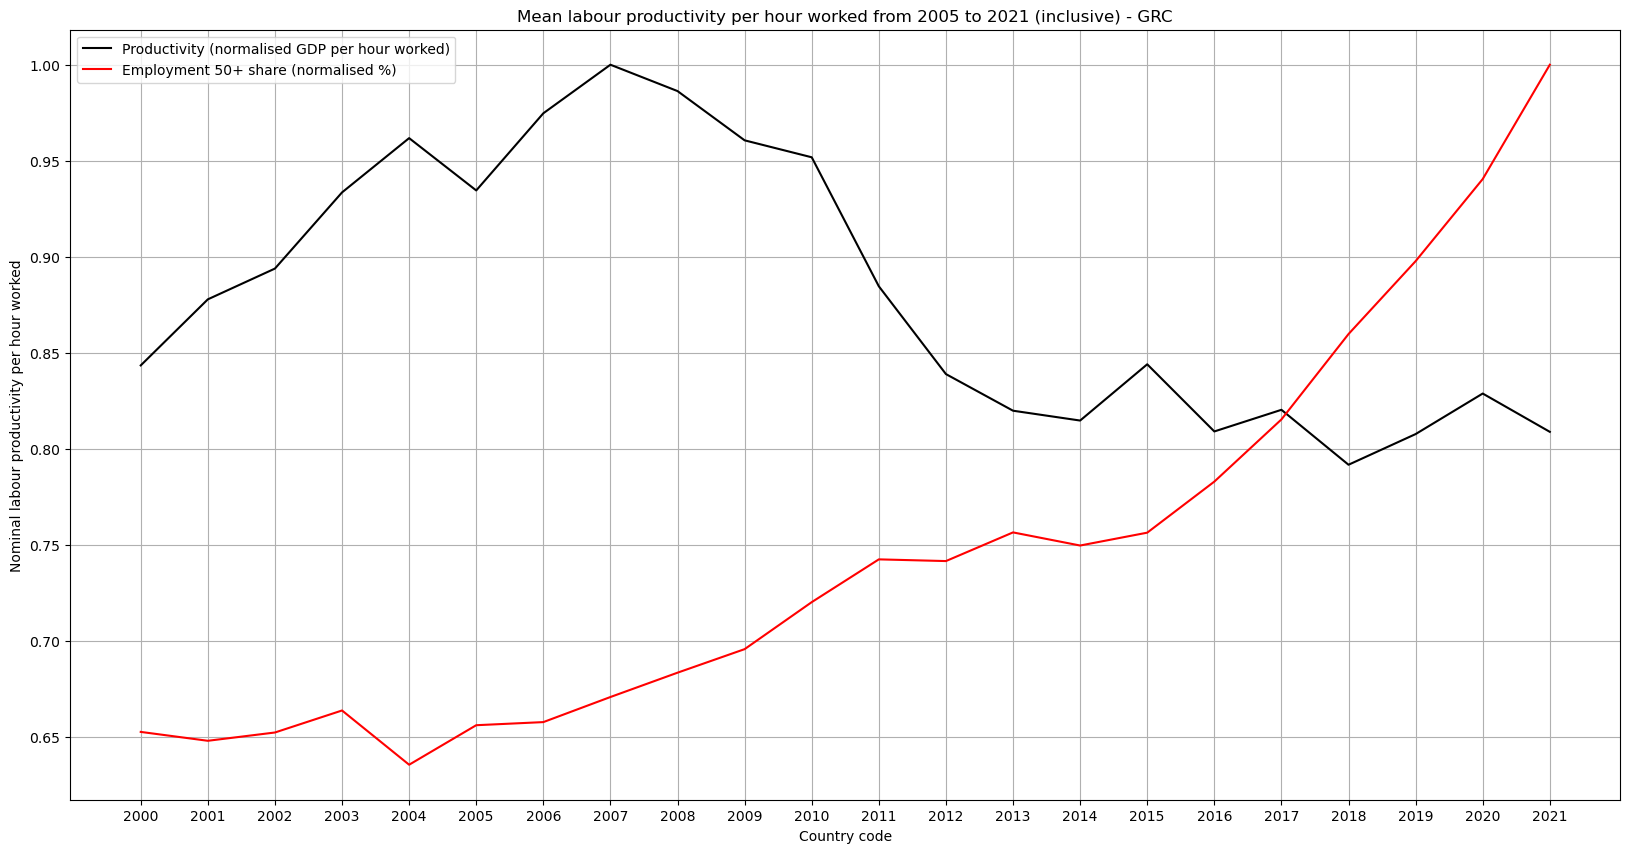

0.8474263731582851


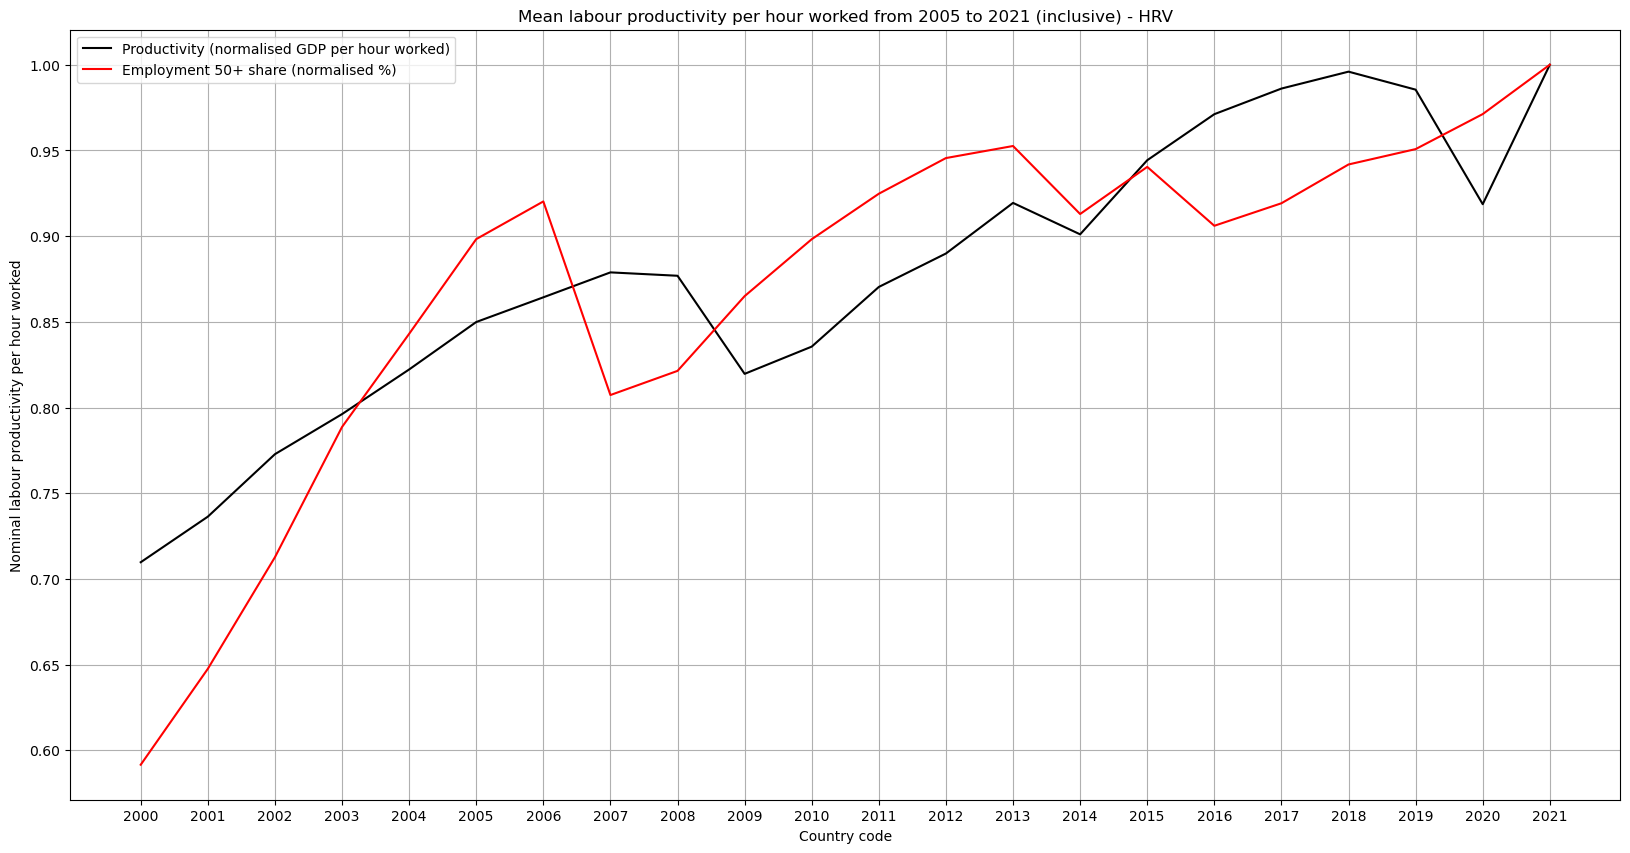

0.9202666160518197


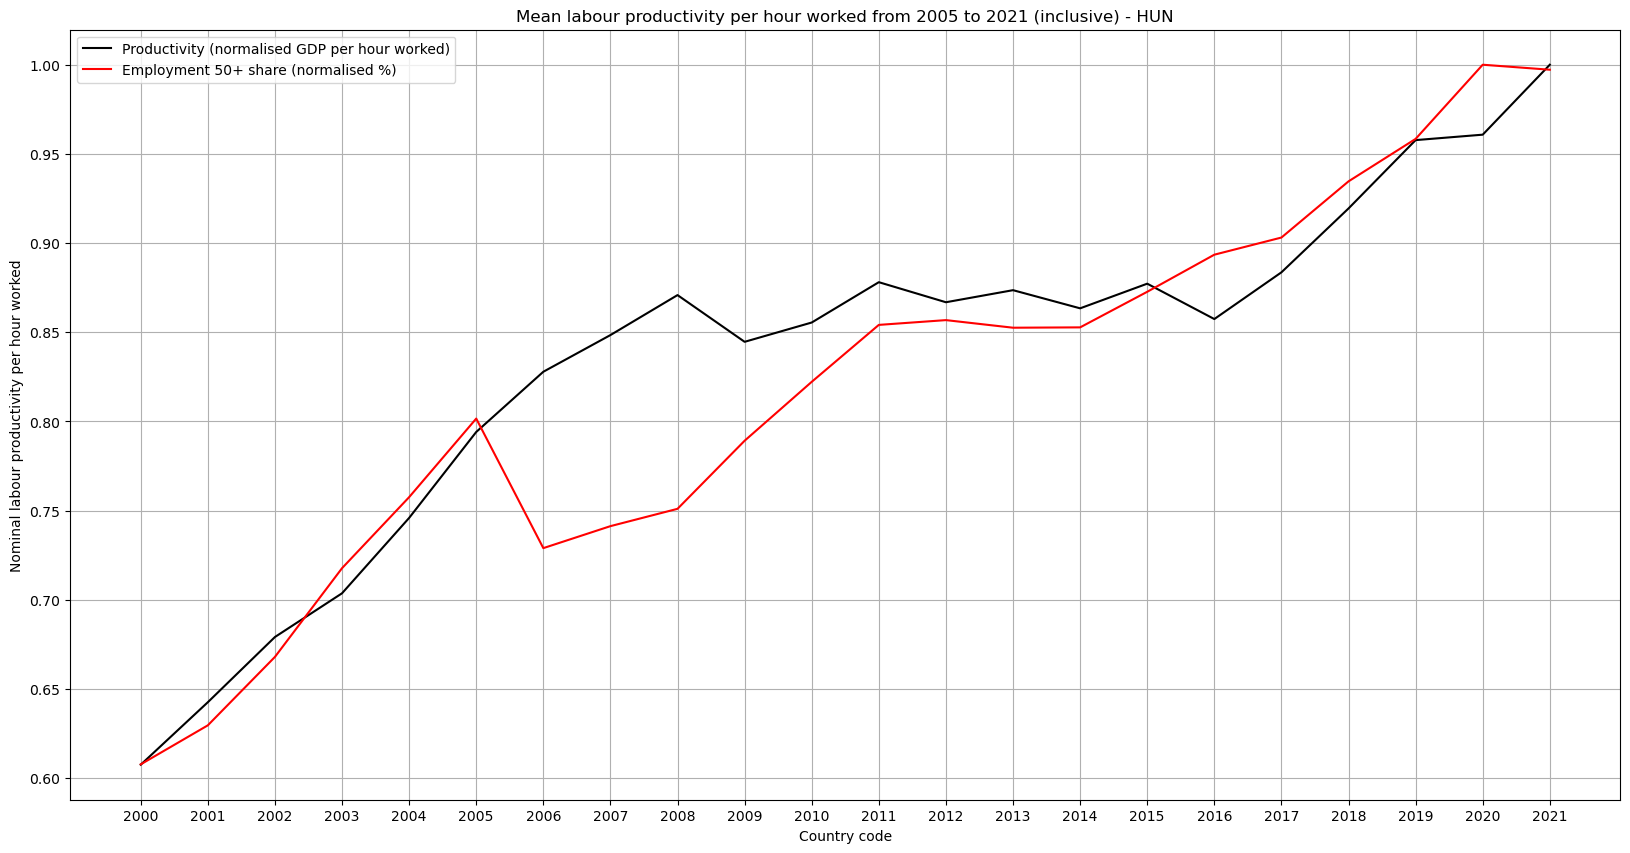

0.9488216676102412


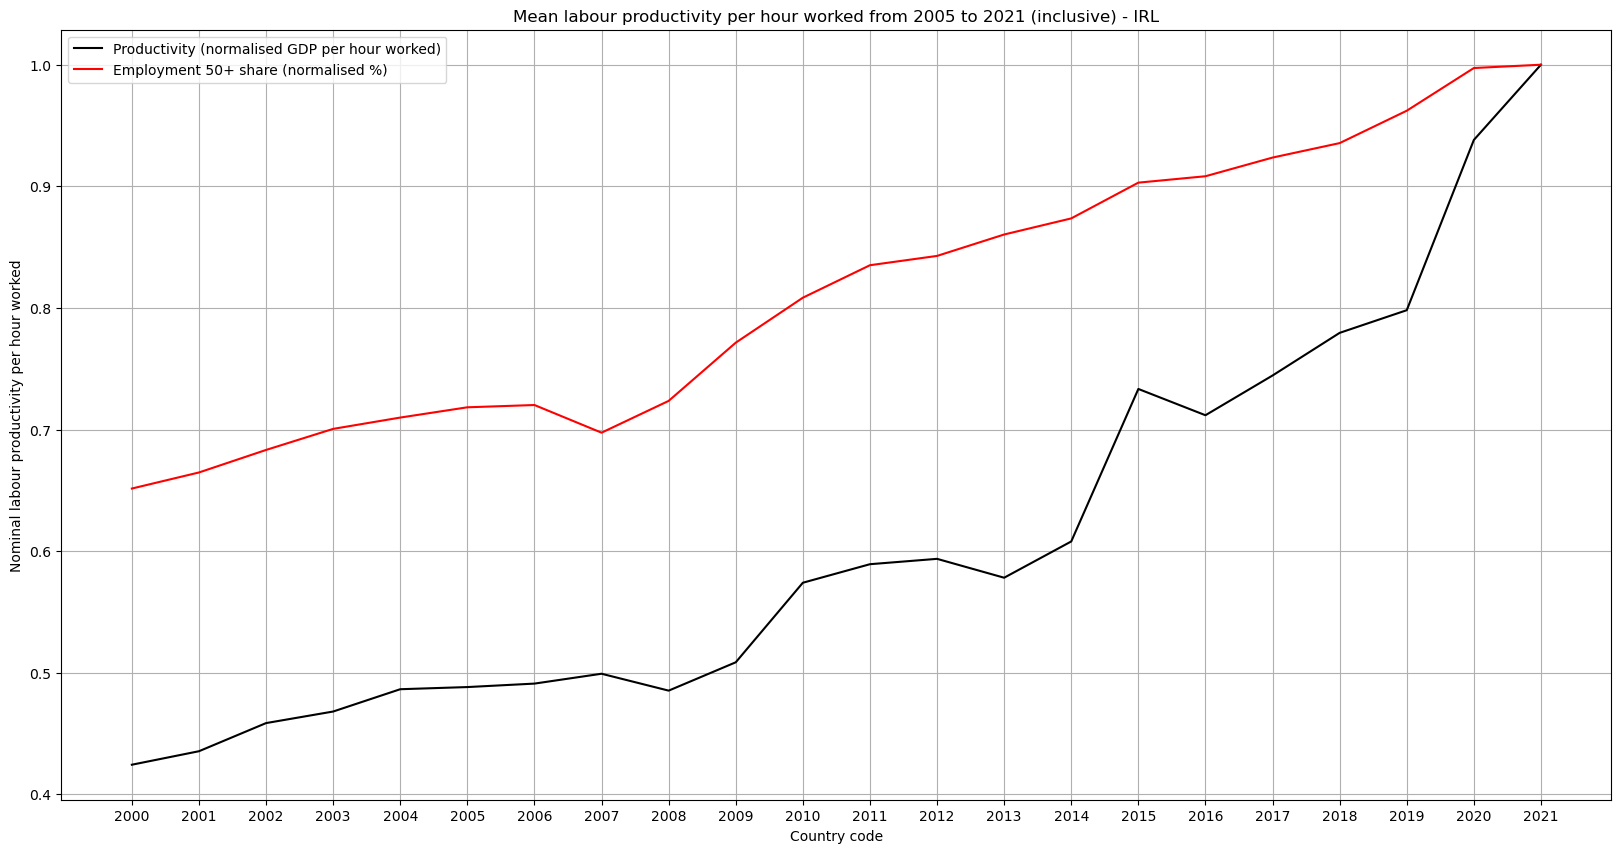

0.875334129735742


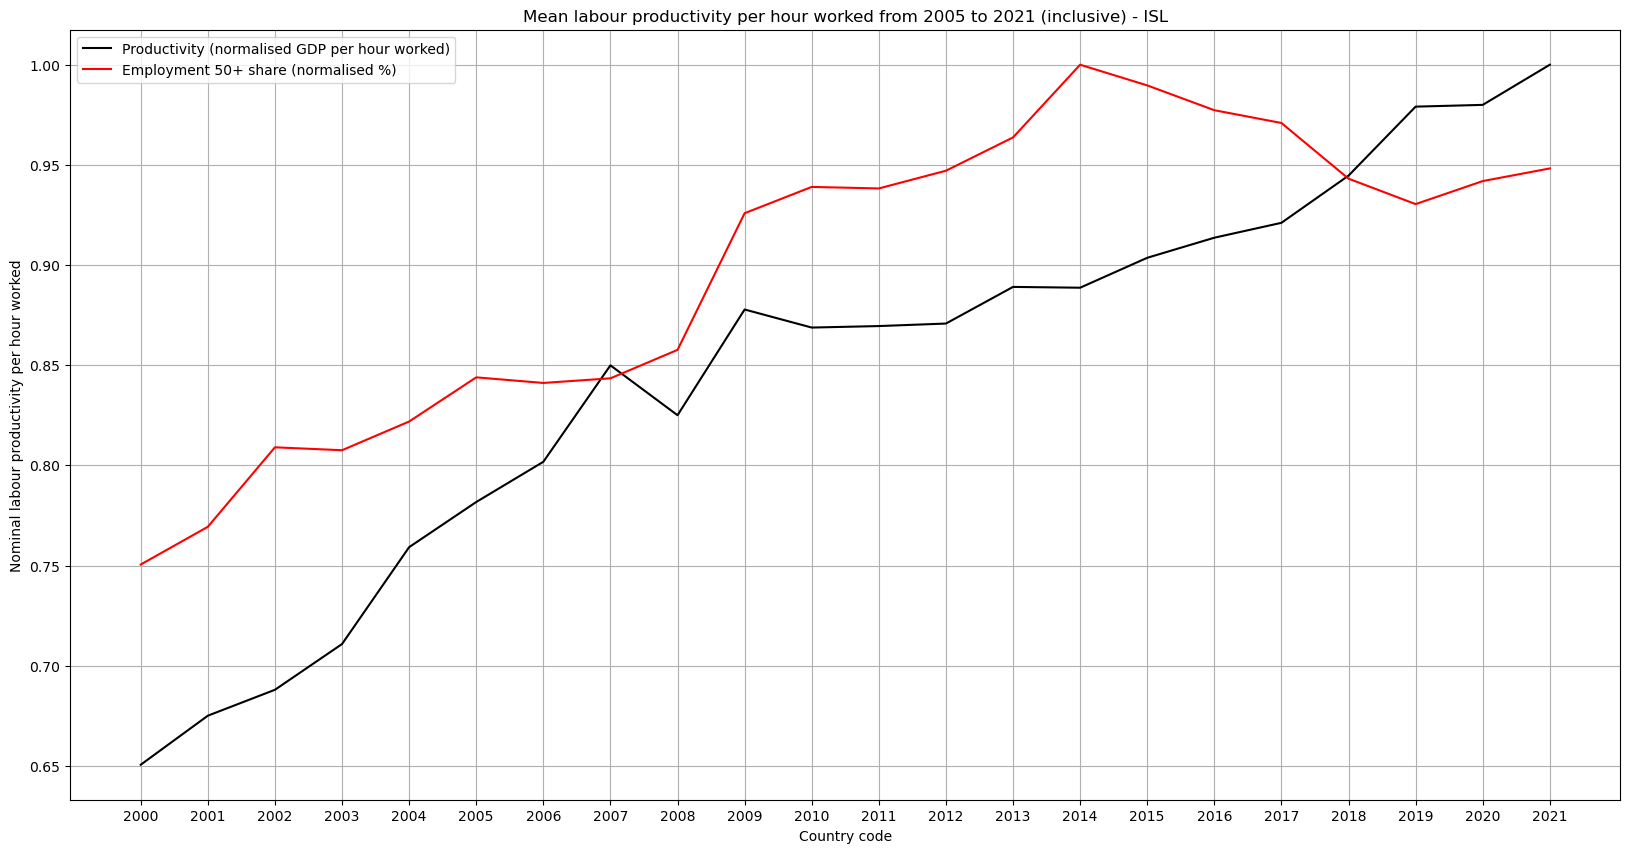

0.9363058023000438


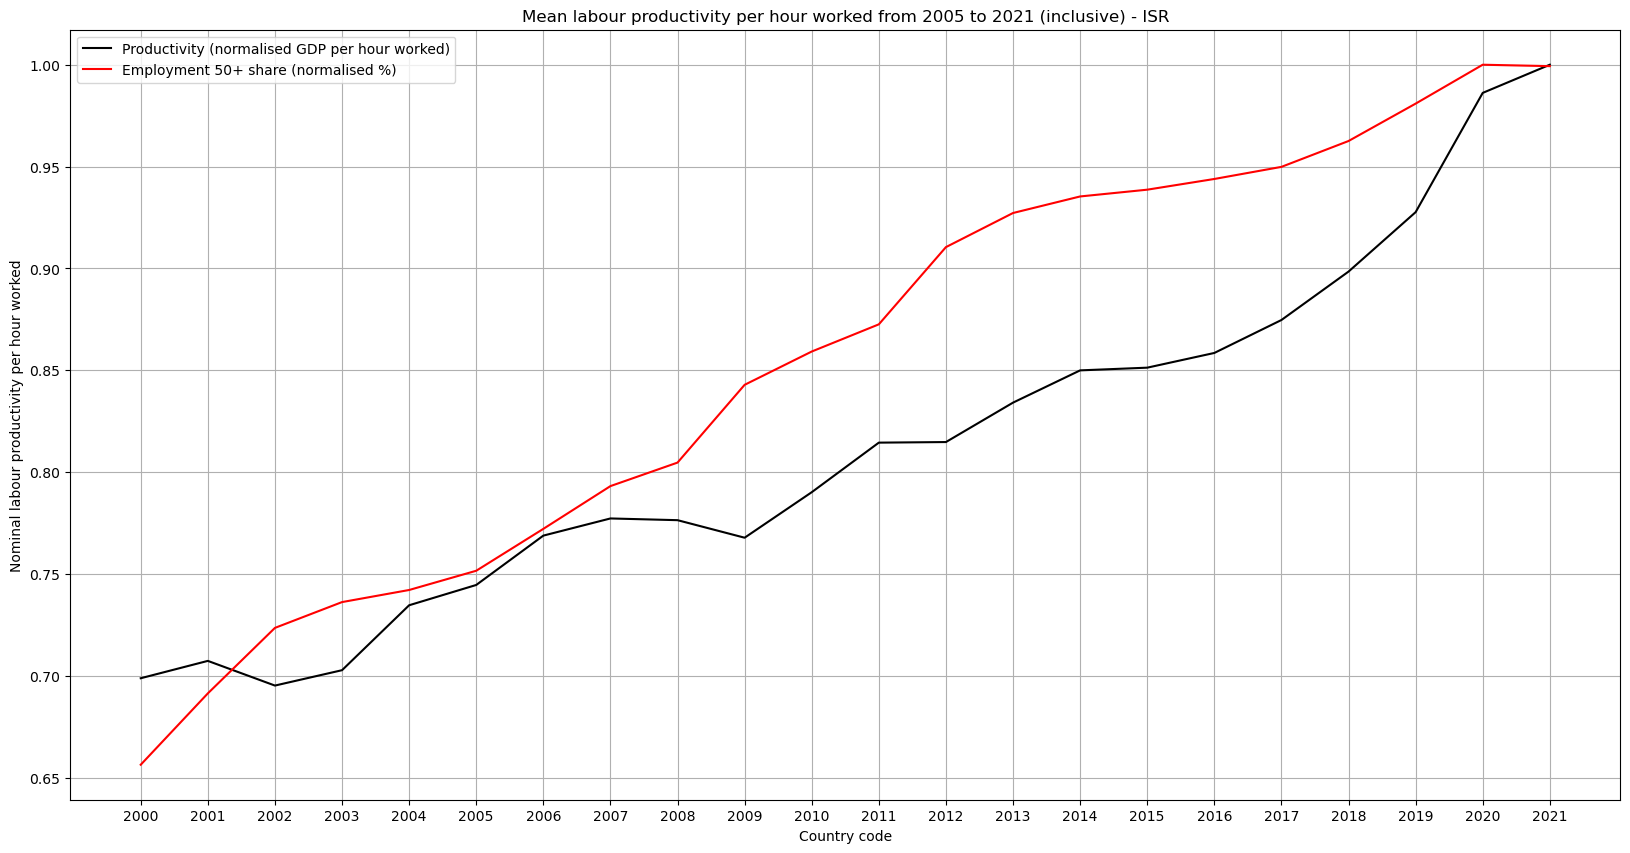

0.7251634759960904


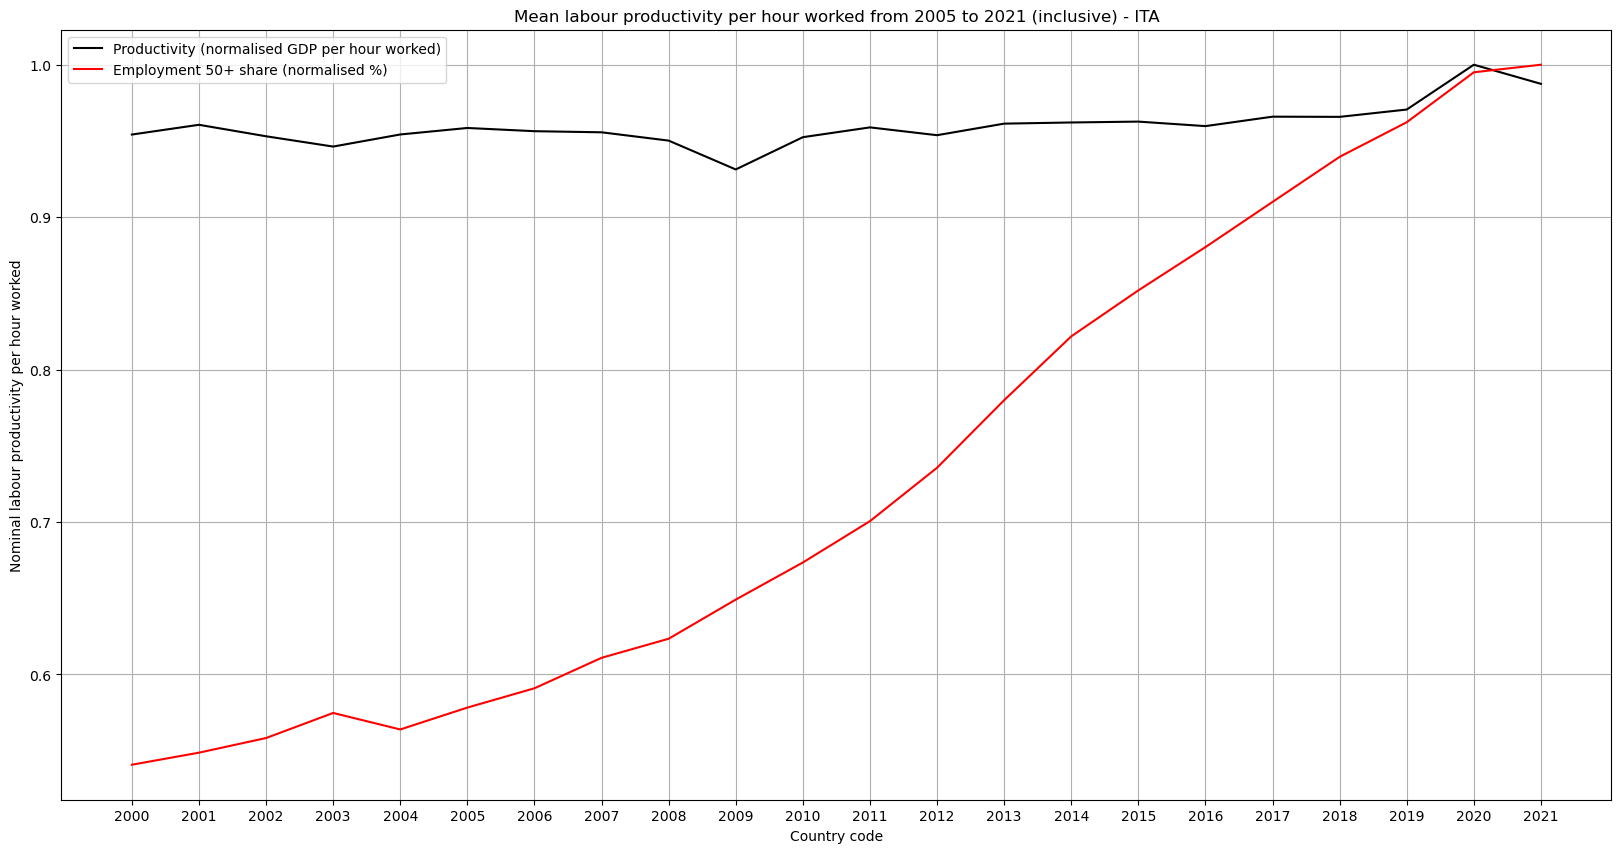

0.8993181883416417


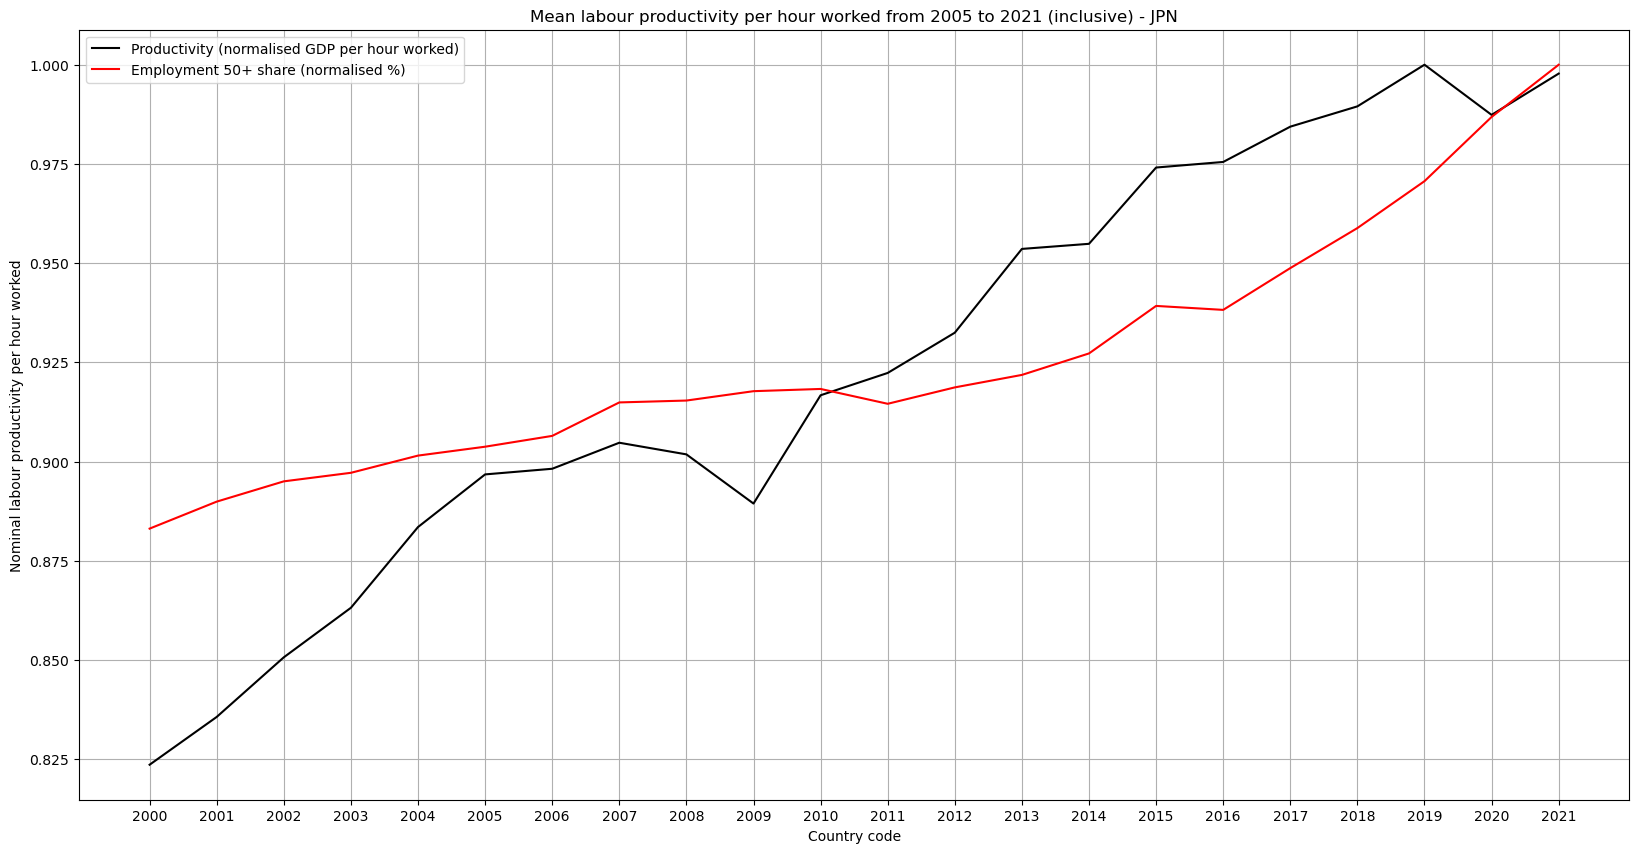

0.9928133061995889


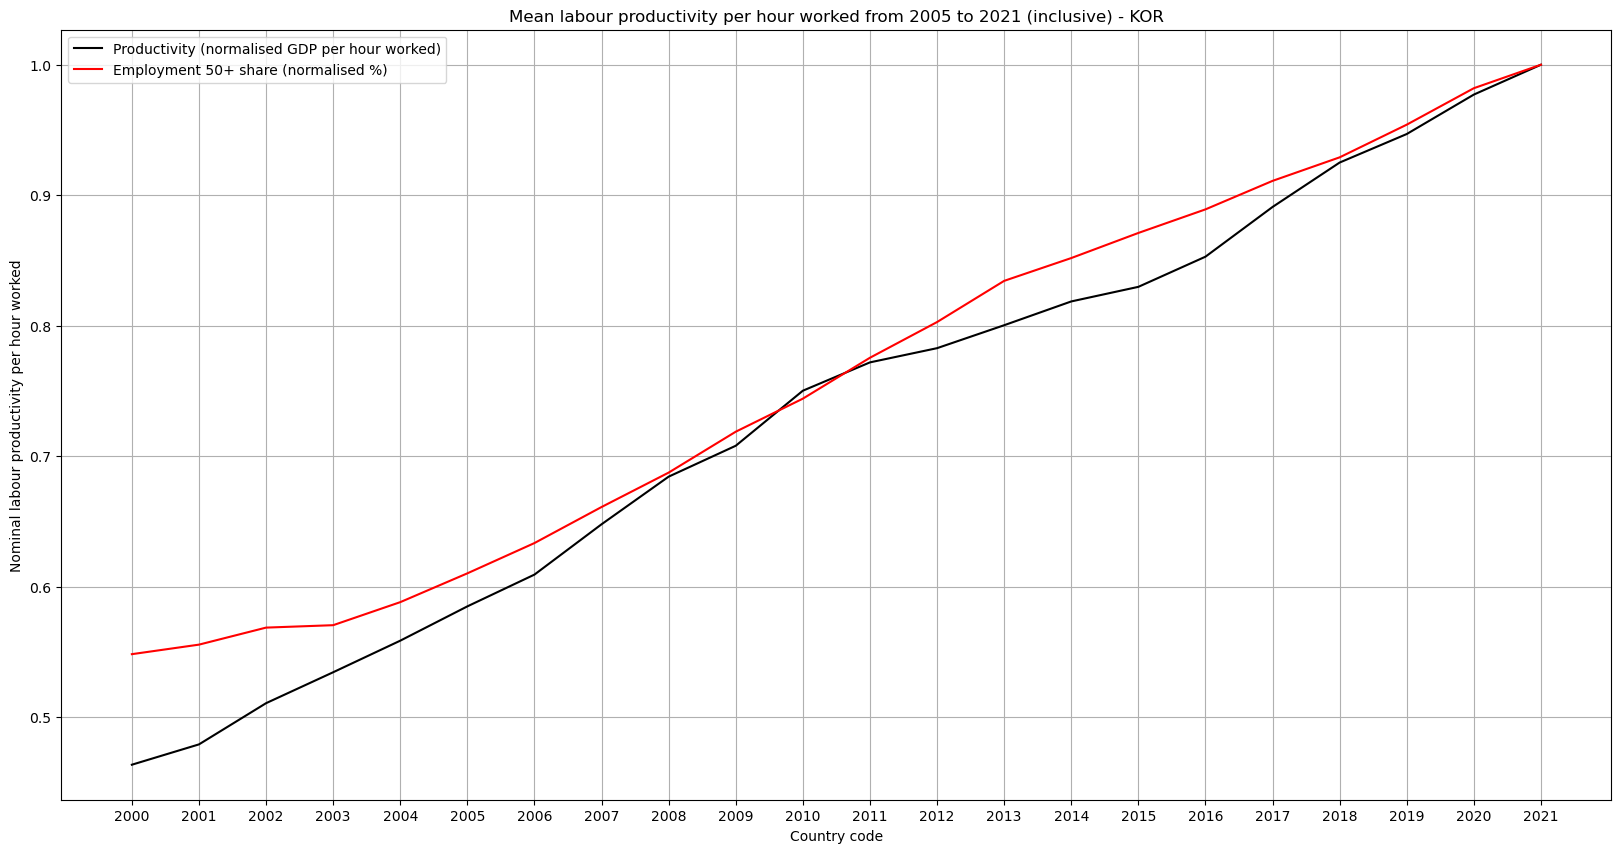

0.9527104287664606


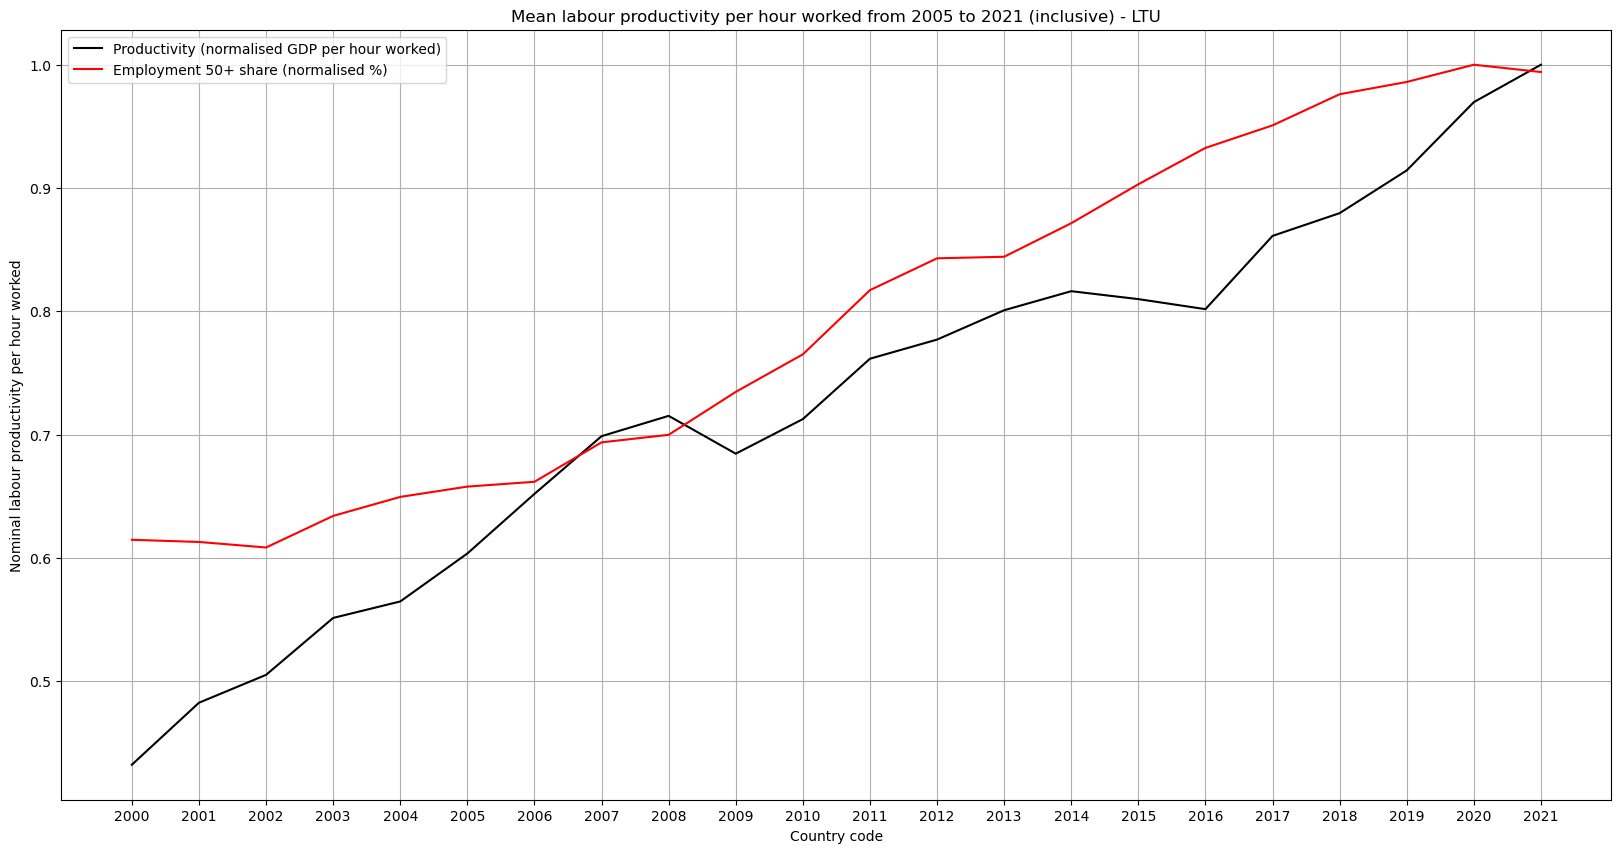

0.39357950869516145


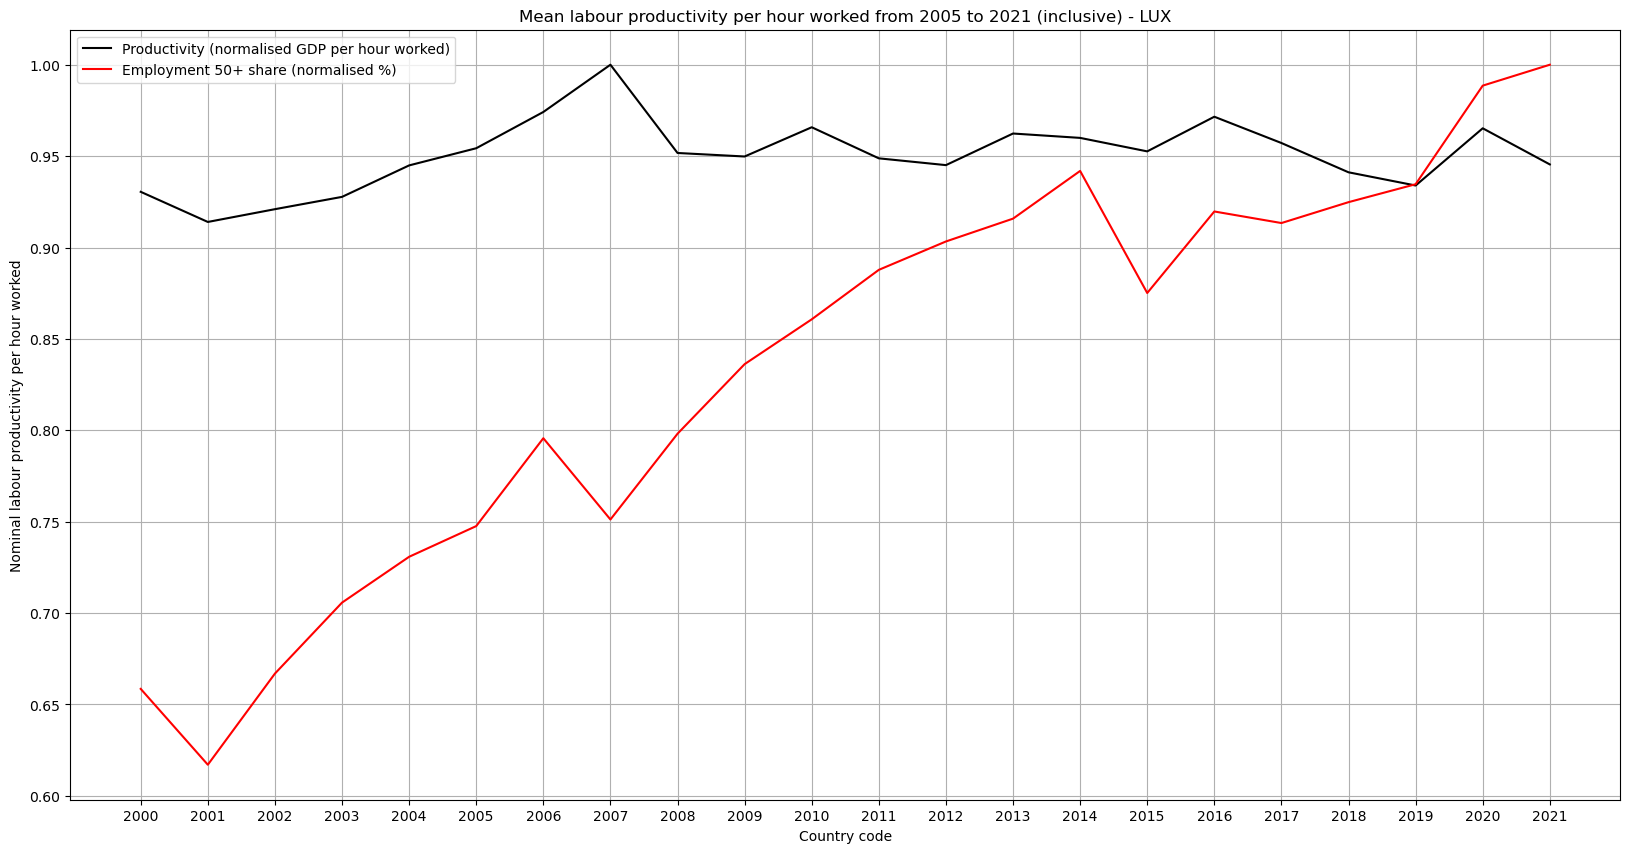

0.9890987782008939


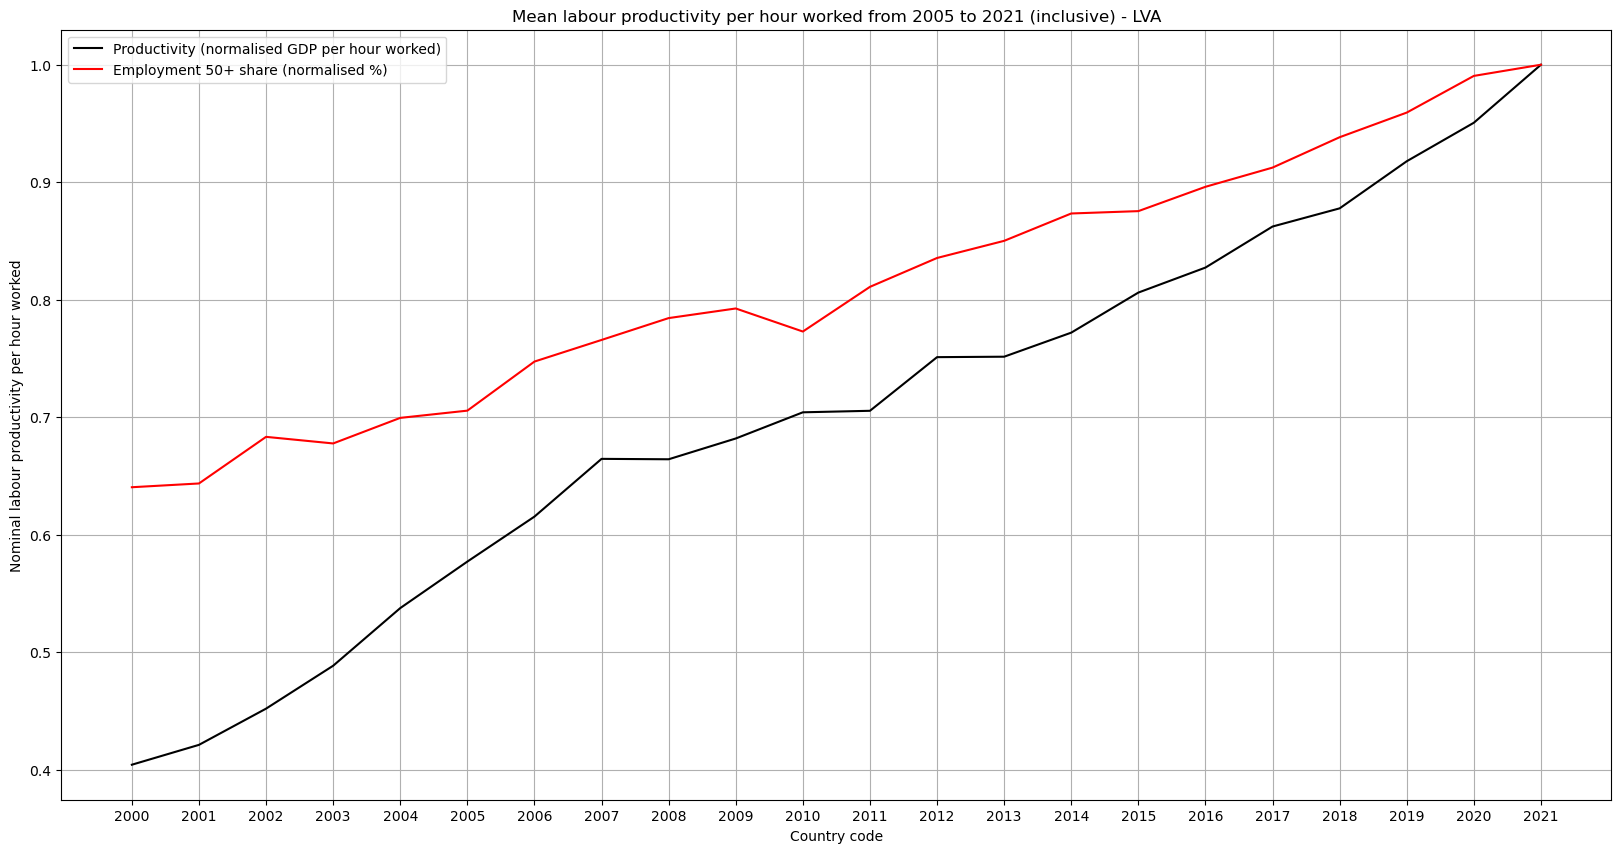

-0.11346459477483573


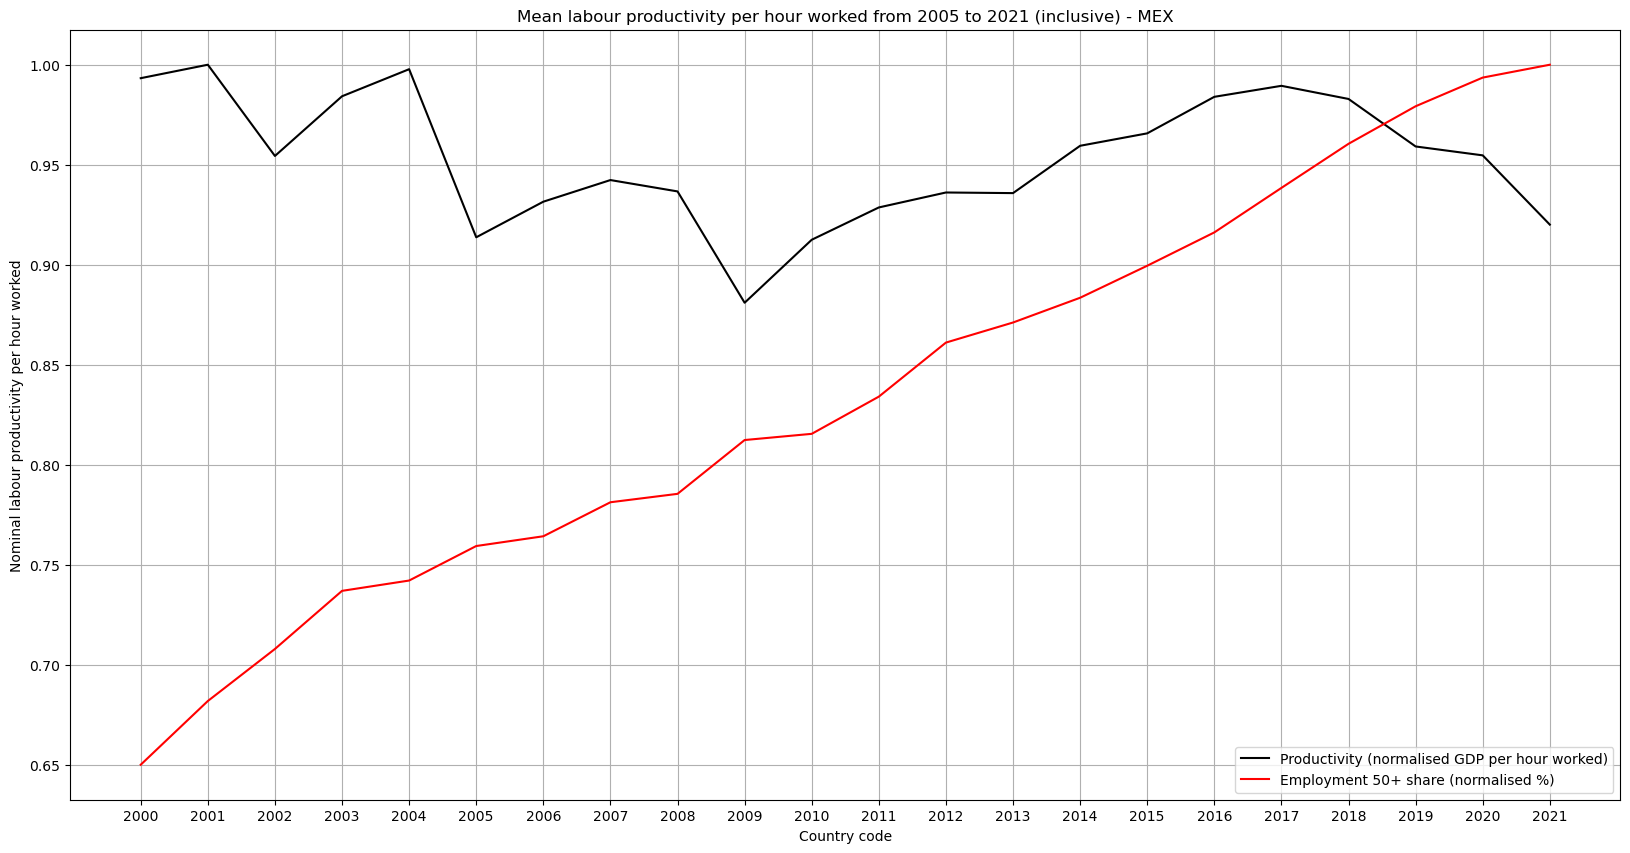

0.919392807867713


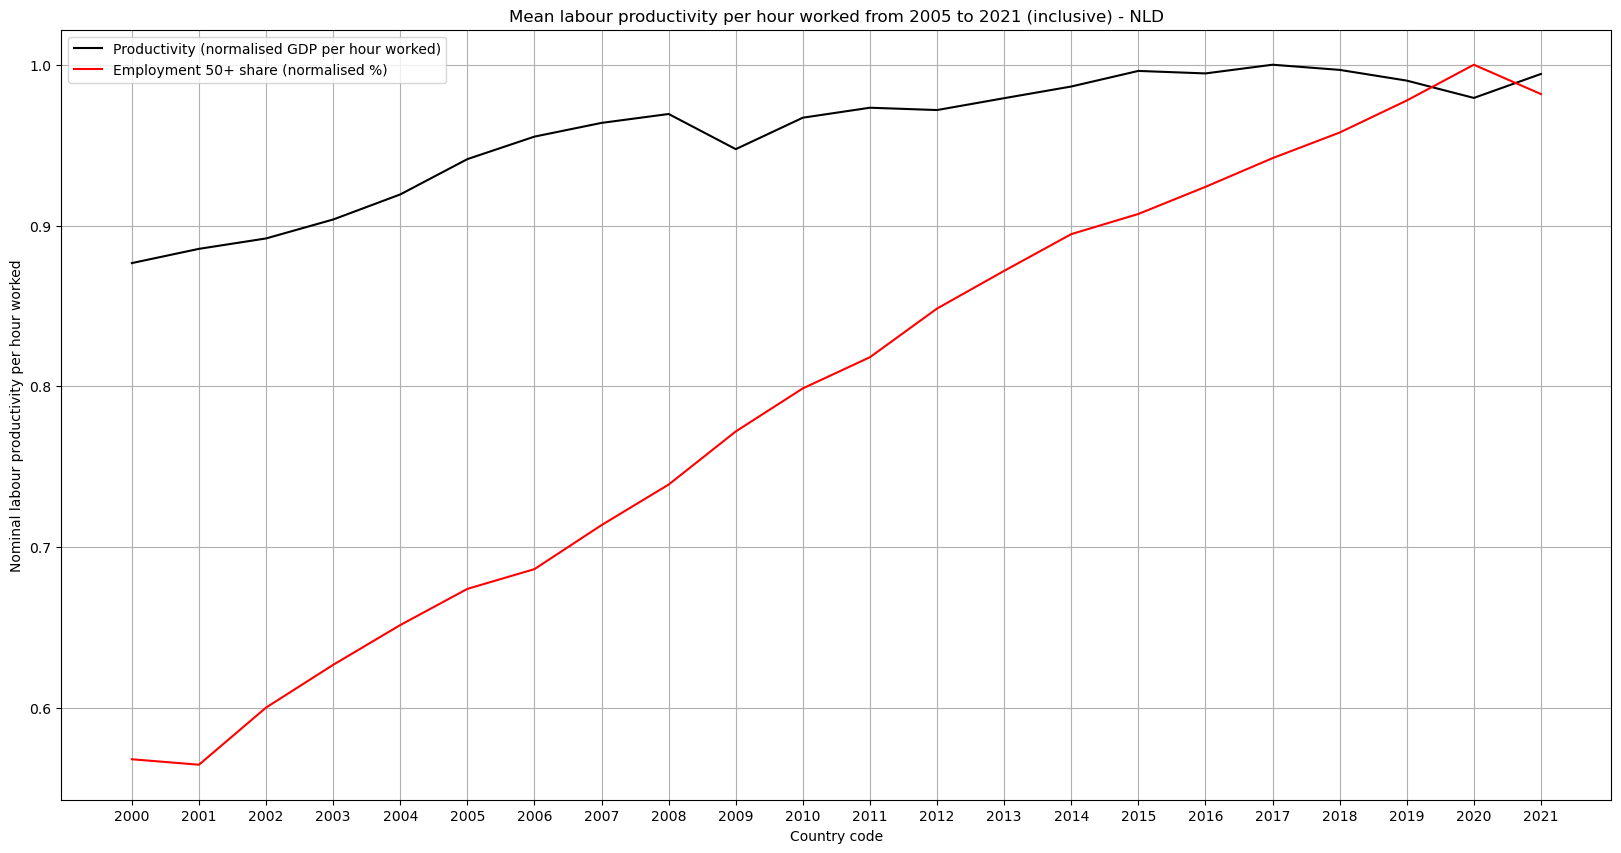

0.7185621694959249


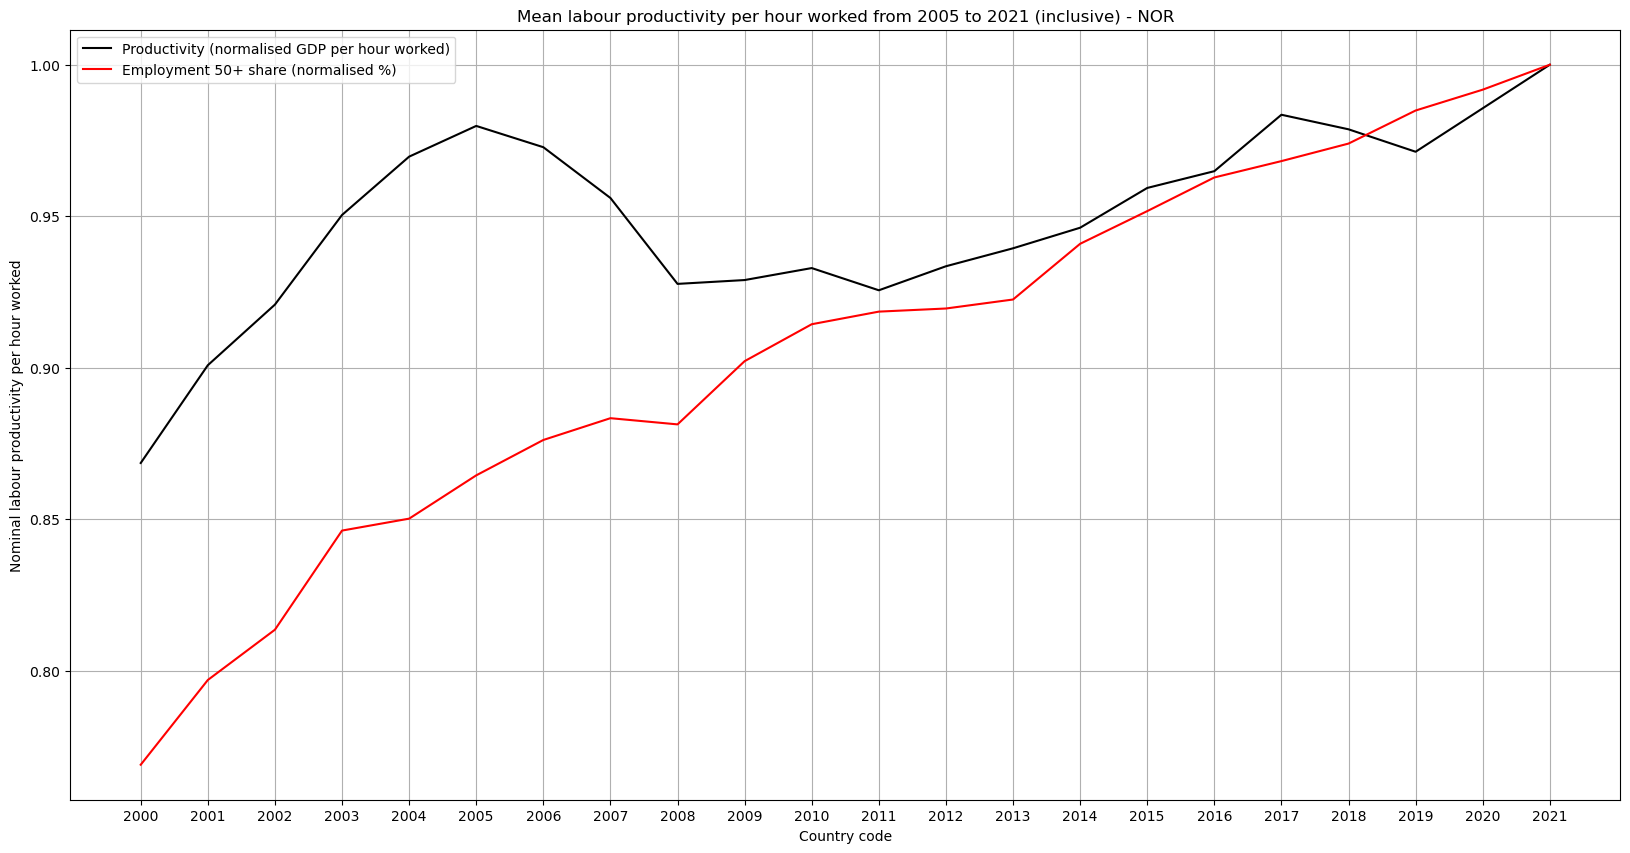

0.9476501106833167


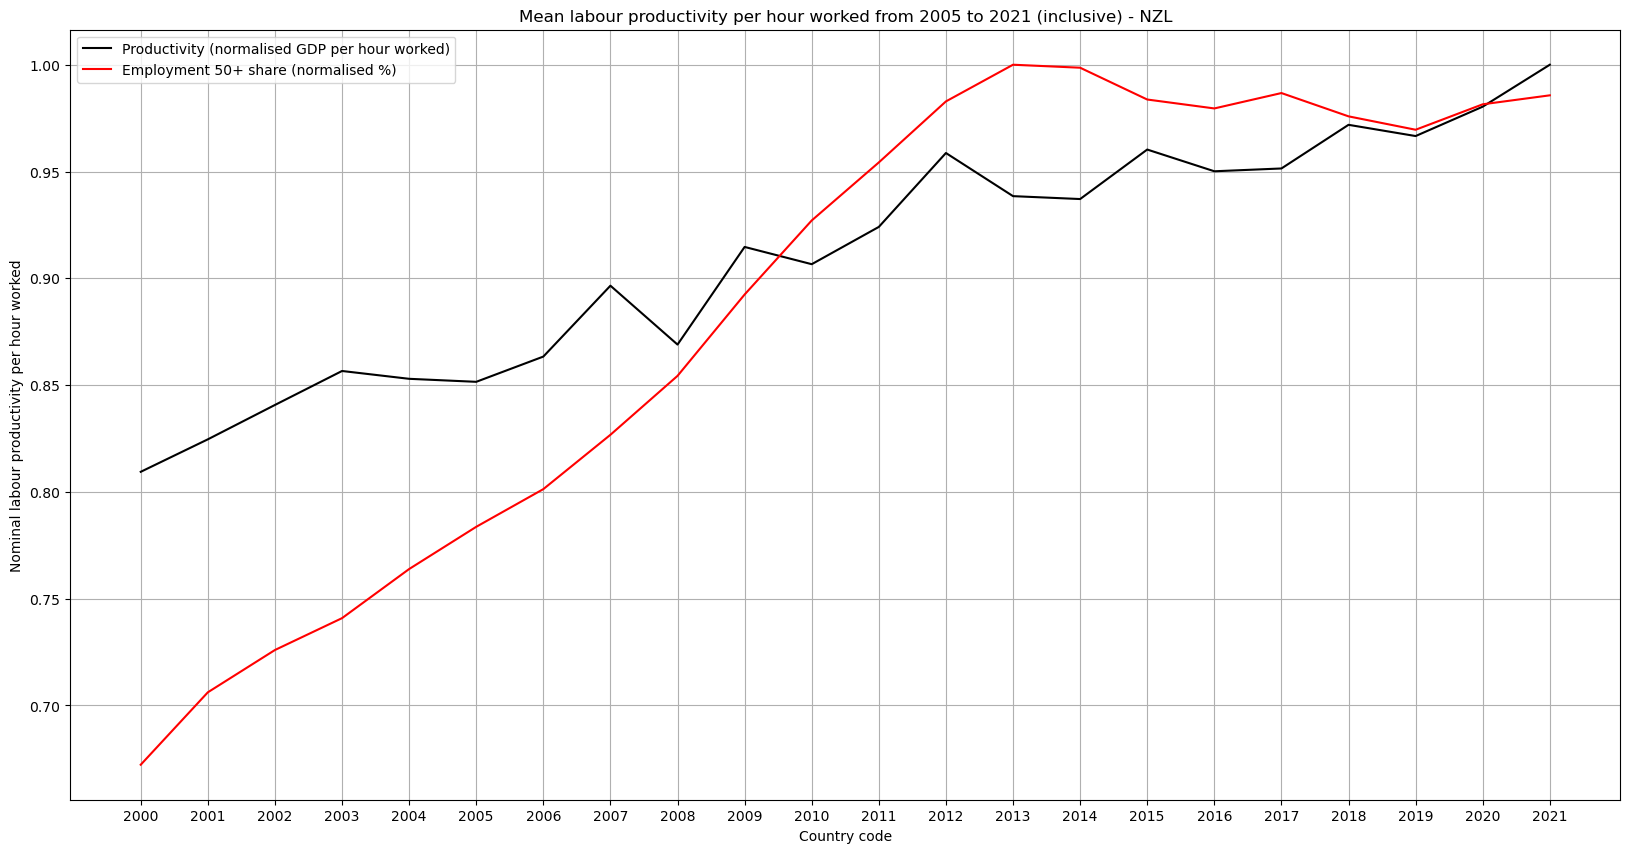

0.9275419417980337


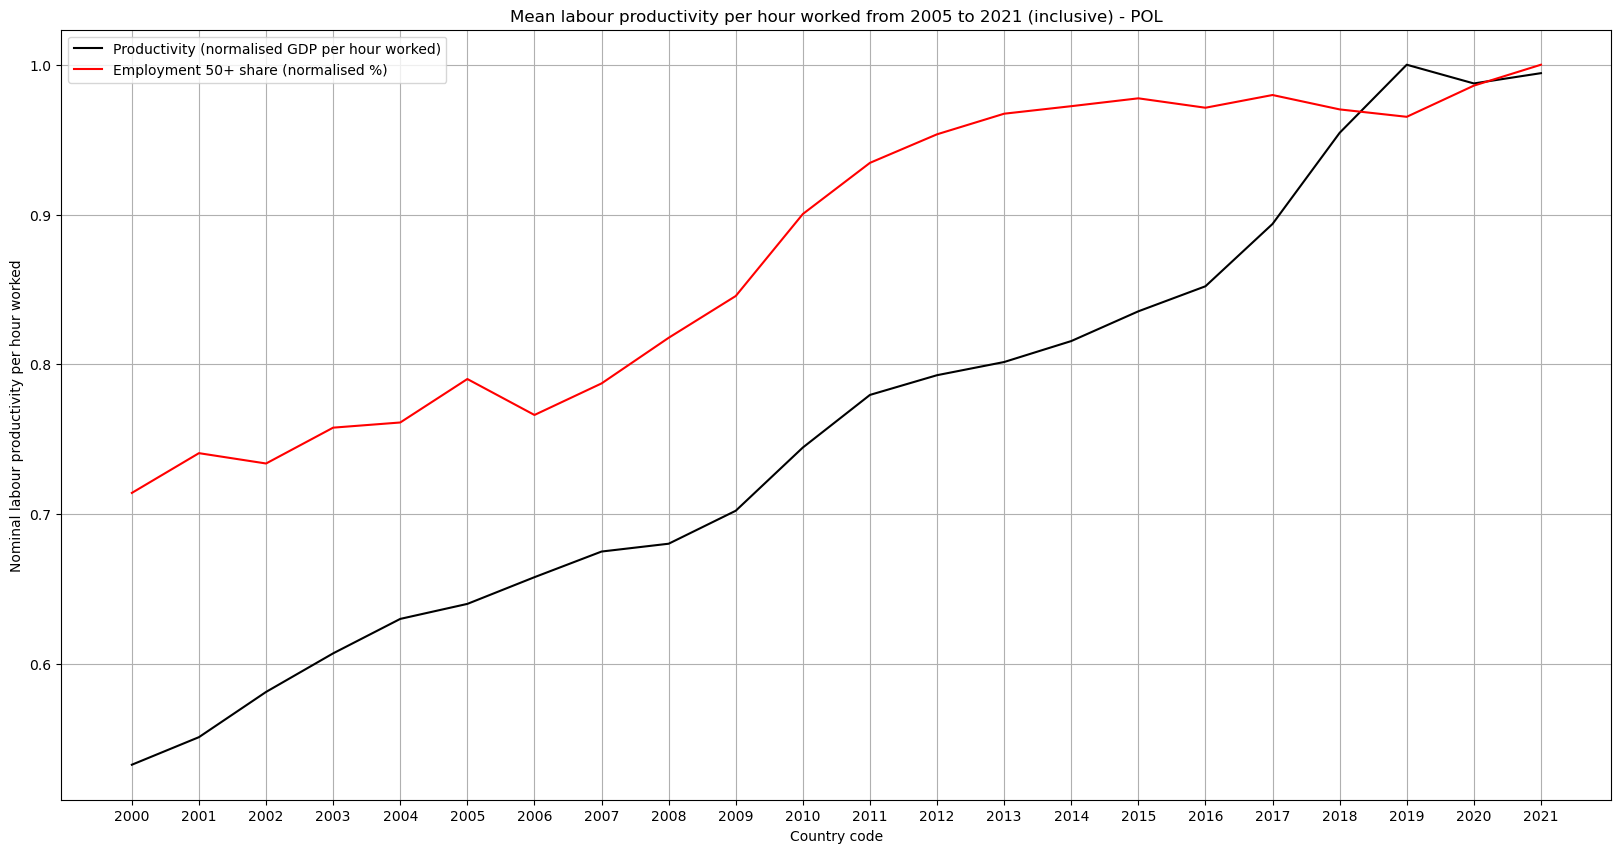

0.8139709737945265


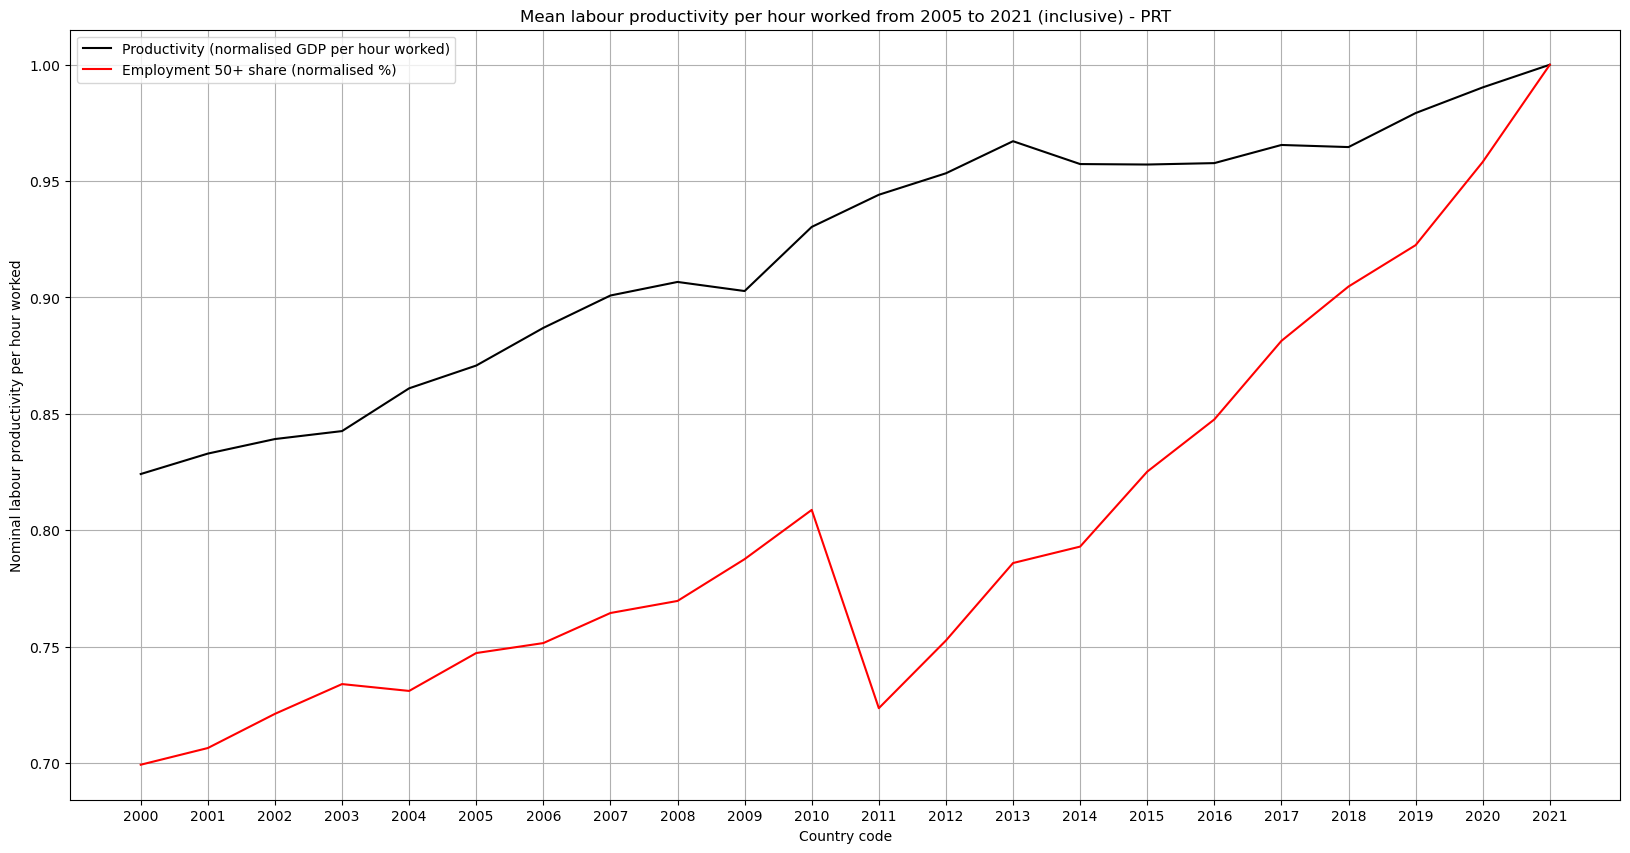

0.6672718351910707


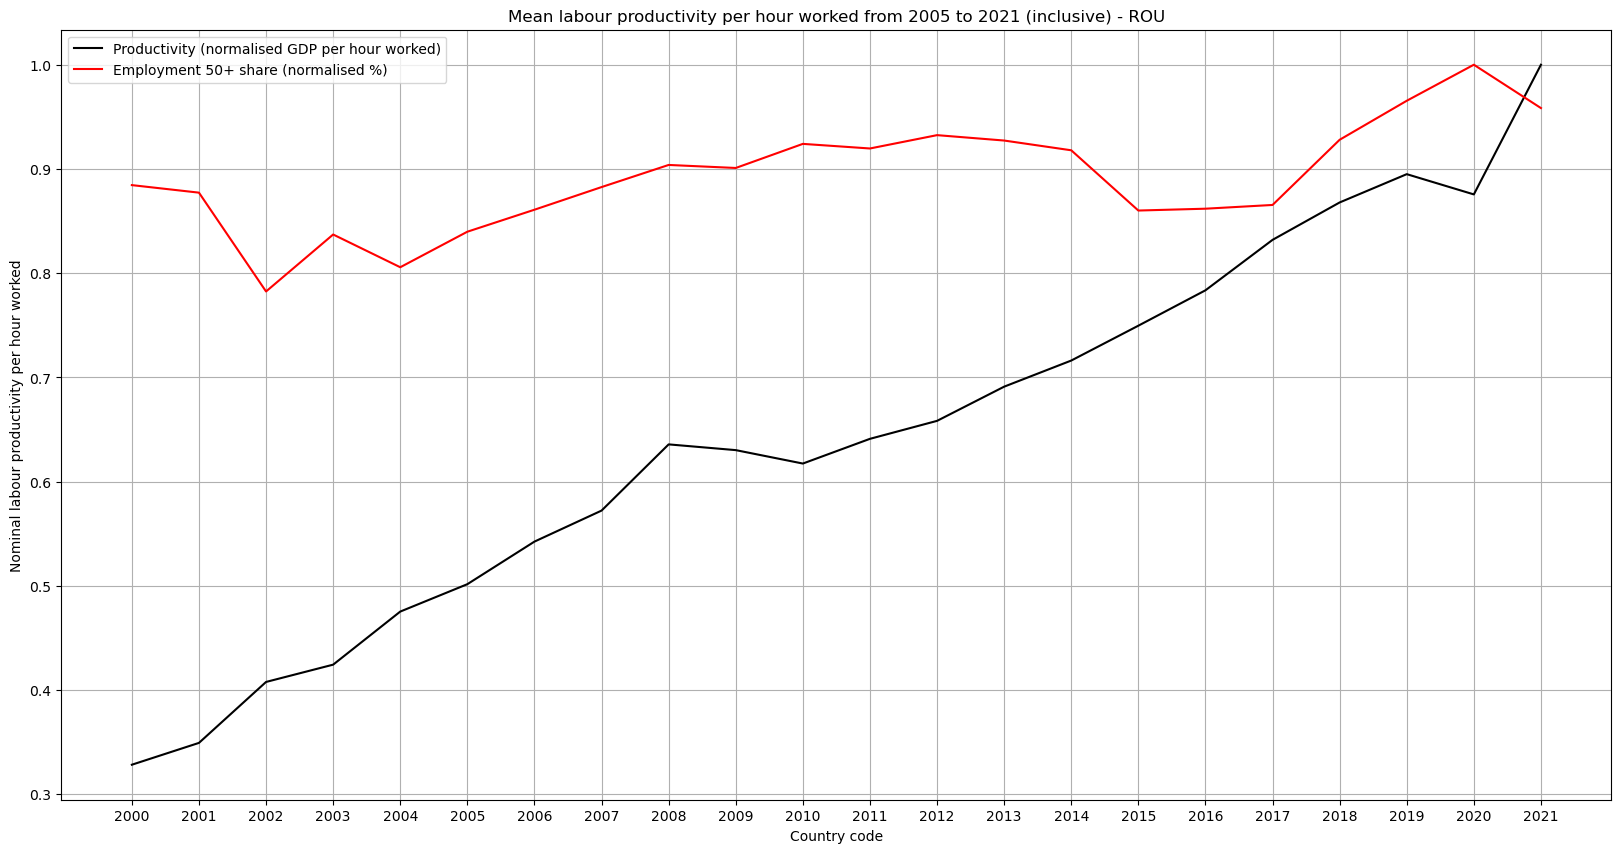

0.978464208869101


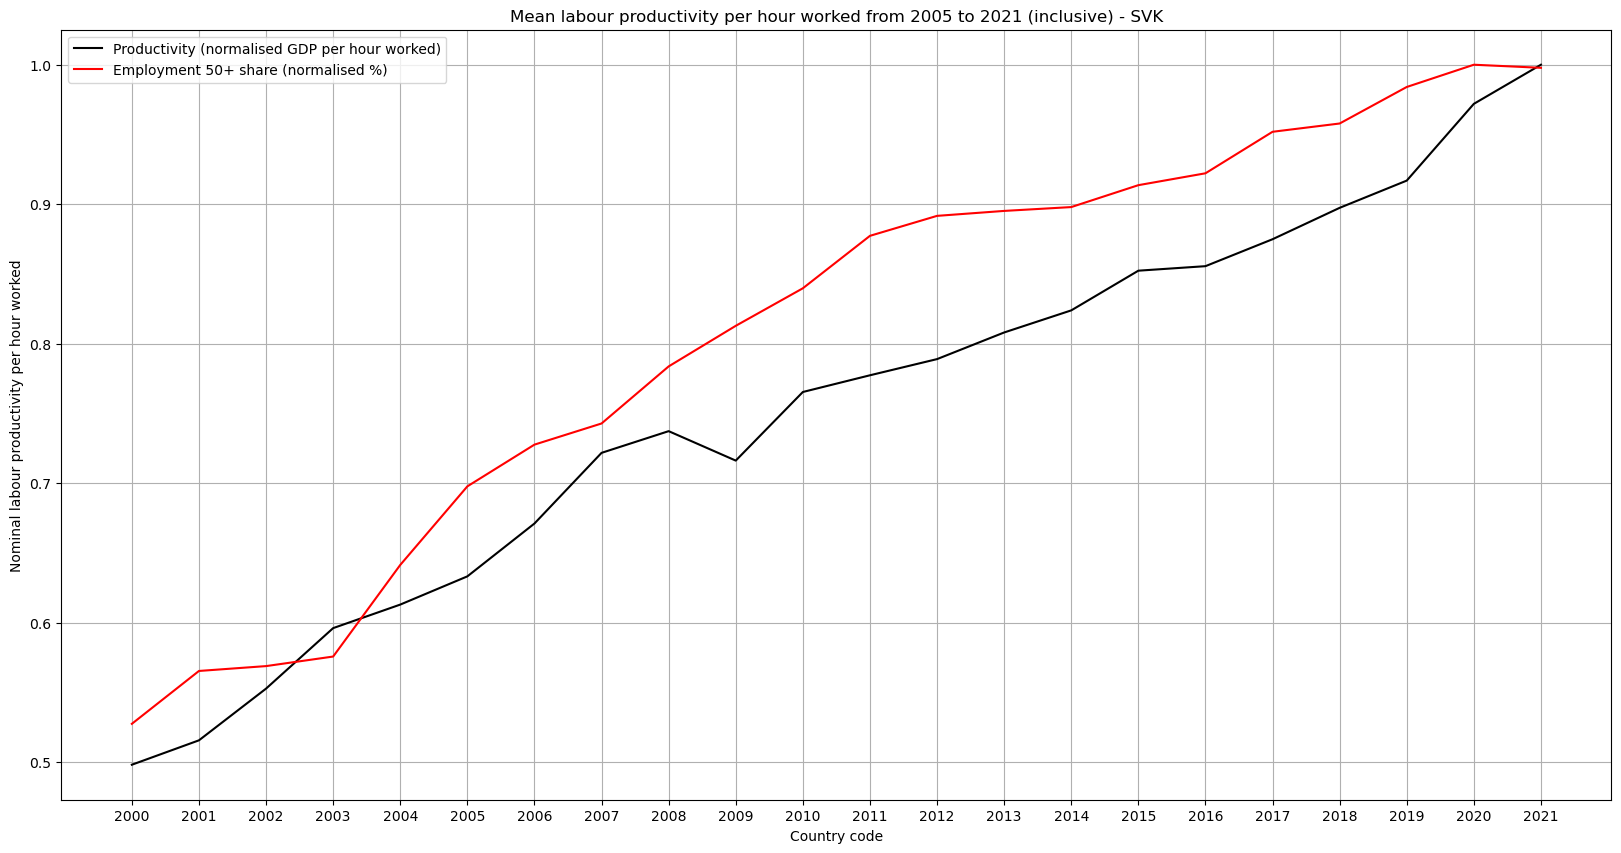

0.9575204621258618


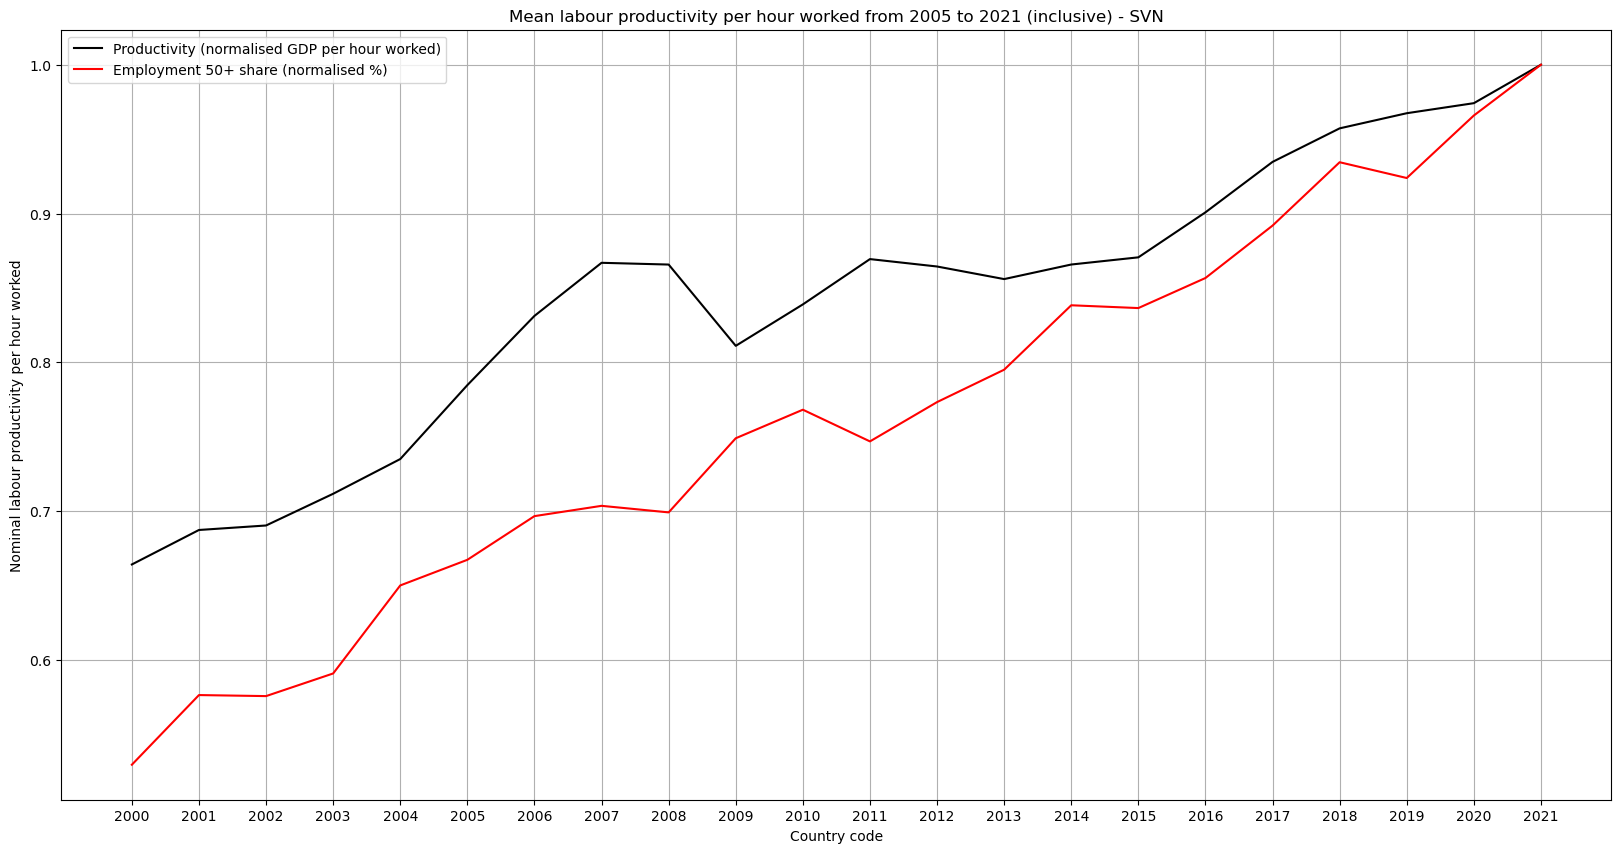

0.932562473039598


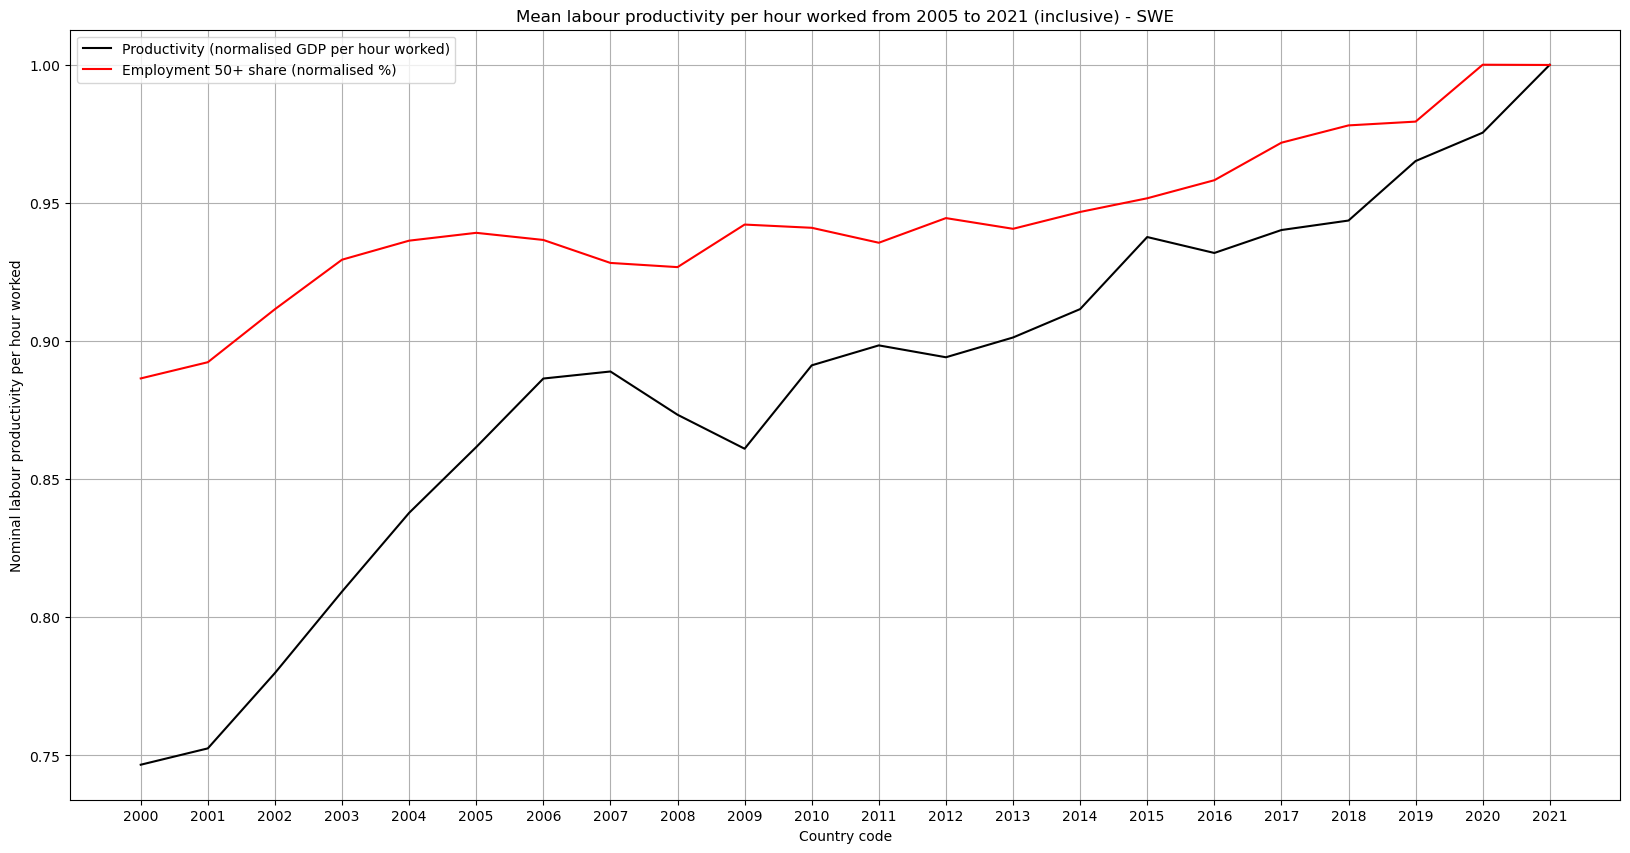

0.8972685337025391


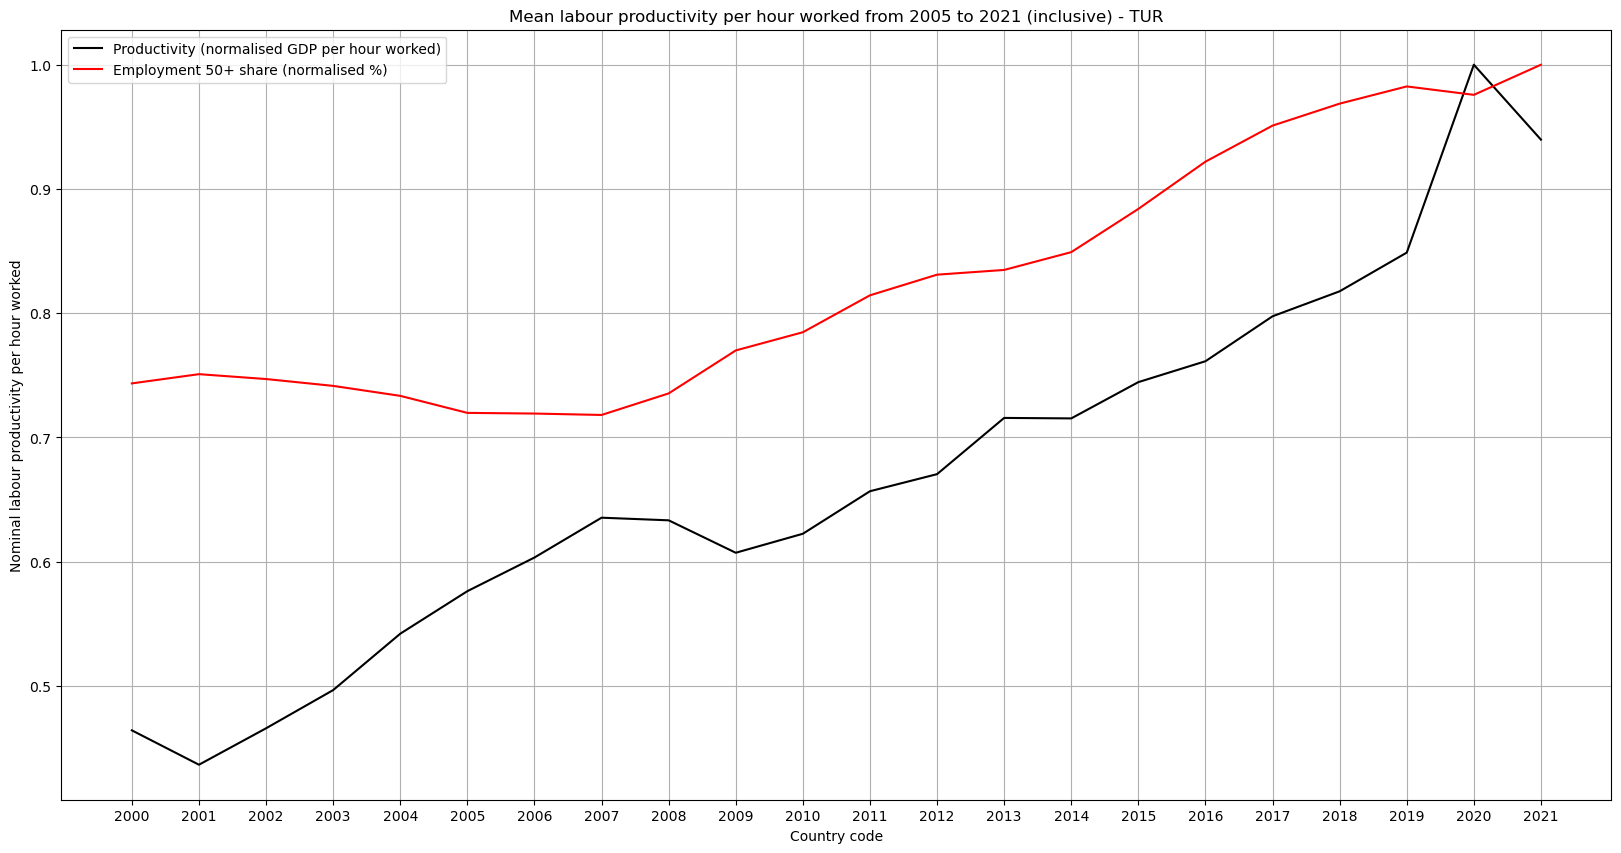

0.965115945859093


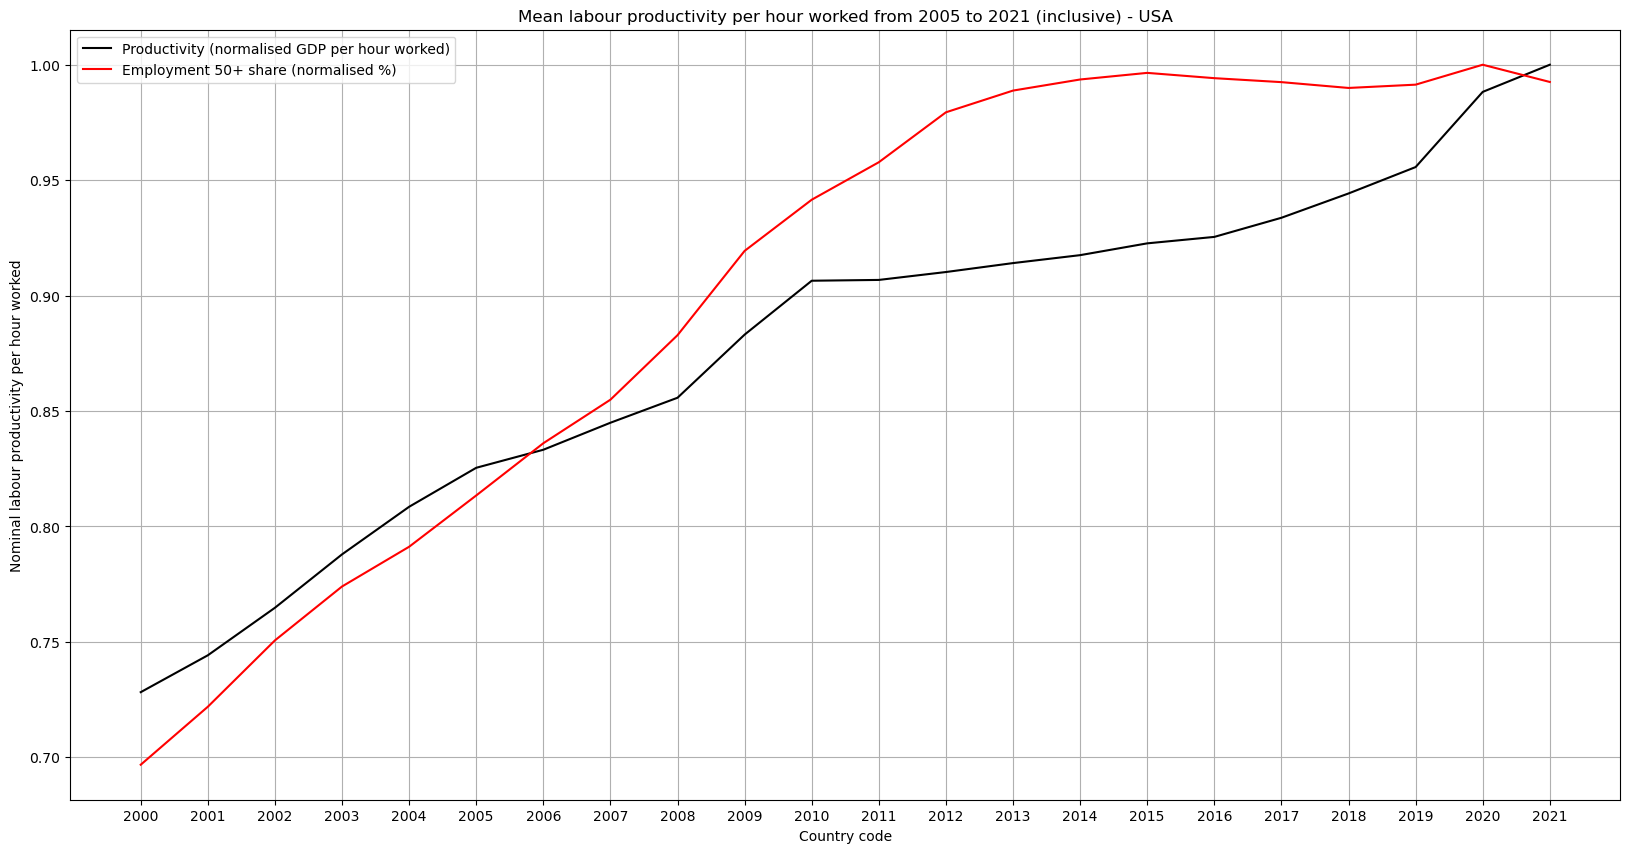

In [19]:
# plots each country's productivity and 50-74 share of employment and calculates their correlation

correlationByCountry = []

for country in compatibleData['COUNTRY'].unique():
    if country in cleanedProductivityData['COUNTRY'].unique():
        countryProductivity = np.array(cleanedProductivityData.loc[cleanedProductivityData['COUNTRY'] == country].iloc[0][1:-1]).astype(float)
        country50overEmploymentShare = np.array(compatibleData.loc[compatibleData['COUNTRY'] == country].iloc[0][1:]).astype(float)

        correlation = np.corrcoef(countryProductivity, country50overEmploymentShare)[0][1]
        print(correlation)
        correlationByCountry.append(correlation)

        plt.figure(figsize=(20, 10))
        plt.plot(cleanedProductivityData.columns[1:-1], countryProductivity/max(countryProductivity), c='black', label='Productivity (normalised GDP per hour worked)')
        plt.plot(cleanedProductivityData.columns[1:-1], country50overEmploymentShare/max(country50overEmploymentShare), c='red', label='Employment 50+ share (normalised %)')
        
        plt.grid()
        plt.legend()
        plt.xlabel('Country code') 
        plt.ylabel('Nominal labour productivity per hour worked') 
        plt.title("Mean labour productivity per hour worked from 2005 to 2021 (inclusive) - " + country)

        plt.show()

In [14]:
print("Number of countries in both datasets: " + str(len(correlationByCountry)))
print("Mean correlation between each country's 50-74 share of employment and GDP per hour worked (productivity): " + str(np.mean(correlationByCountry)))

Number of countries in both datasets: 40
Mean correlation between each country's 50-74 share of employment and GDP per hour worked (productivity): 0.8368687133365385


In [15]:
# saves the cleaned labour force composition dataset under the Datasets folder

cleanedData.to_csv("../Datasets/cleaned_LFS.csv", index=False)